In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_user = np.argmax(state[:4])
        action_mod = 1
        new_loc, reward_user, reward_mod, done = env.step(action_user, action_mod, target_loc, curr_loc)
        
        return new_loc, reward_user, done

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.9 0.6]
 [0.5 0. ]
 [0.  0.2]
 [0.2 0.9]
 [0.7 0.4]
 [0.  0.4]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
________

In [5]:
state = [0.1,0.1,0.3,0.3]
state = np.array(state)
next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
print(next_state, reward,done)

user_agent.replay_buffer.print()

print(user_agent.model(np.array([state])))

[0.1, 0.2, 0.3, 0.3] 1 0
deque([array([0.1, 0.1, 0.3, 0.3])], maxlen=1024)
deque([3], maxlen=1024)
deque([1], maxlen=1024)
deque([[0.1, 0.2, 0.3, 0.3]], maxlen=1024)
deque([0], maxlen=1024)
tf.Tensor([[-0.01052976 -0.02835854  0.02761557 -0.046931  ]], shape=(1, 4), dtype=float32)


  0%|                                                                             | 109/100000 [00:01<20:46, 80.14it/s]

Updated Weights
Mean Reward = -0.9207920792079208
16


  0%|▏                                                                            | 209/100000 [00:02<21:42, 76.64it/s]

Updated Weights
Mean Reward = -2.06
12


  0%|▏                                                                            | 308/100000 [00:03<26:34, 62.54it/s]

Updated Weights
Mean Reward = -0.6
20


  0%|▎                                                                            | 407/100000 [00:05<28:06, 59.06it/s]

Updated Weights
Mean Reward = 0.37
21


  0%|▍                                                                            | 499/100000 [00:06<27:11, 61.00it/s]

Updated Weights
Mean Reward = 0.07
17


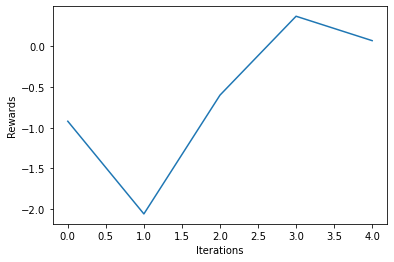

  1%|▍                                                                            | 607/100000 [00:09<32:26, 51.07it/s]

Updated Weights
Mean Reward = 0.02
20


  1%|▌                                                                            | 710/100000 [00:11<32:44, 50.55it/s]

Updated Weights
Mean Reward = 1.66
22


  1%|▌                                                                            | 807/100000 [00:13<37:35, 43.97it/s]

Updated Weights
Mean Reward = 1.09
30


  1%|▋                                                                            | 905/100000 [00:15<37:49, 43.66it/s]

Updated Weights
Mean Reward = 0.09
21


  1%|▊                                                                            | 995/100000 [00:17<36:24, 45.32it/s]

Updated Weights
Mean Reward = 3.76
33


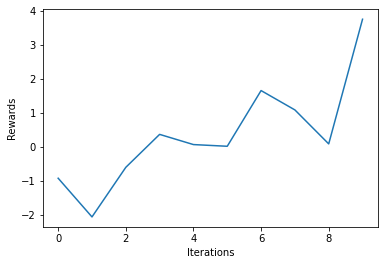

  1%|▊                                                                           | 1106/100000 [00:20<37:59, 43.39it/s]

Updated Weights
Mean Reward = 0.61
25


  1%|▉                                                                           | 1206/100000 [00:23<39:37, 41.56it/s]

Updated Weights
Mean Reward = 3.02
33


  1%|▉                                                                           | 1304/100000 [00:25<39:56, 41.18it/s]

Updated Weights
Mean Reward = 5.04
39


  1%|█                                                                           | 1406/100000 [00:28<42:04, 39.06it/s]

Updated Weights
Mean Reward = 2.34
35


  1%|█▏                                                                          | 1498/100000 [00:30<37:47, 43.43it/s]

Updated Weights
Mean Reward = 3.5
35


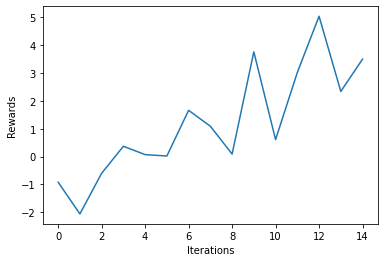

  2%|█▏                                                                          | 1608/100000 [00:33<39:10, 41.85it/s]

Updated Weights
Mean Reward = 4.84
49


  2%|█▎                                                                          | 1706/100000 [00:35<40:48, 40.14it/s]

Updated Weights
Mean Reward = 1.7
31


  2%|█▎                                                                          | 1804/100000 [00:38<45:42, 35.81it/s]

Updated Weights
Mean Reward = 4.52
32


  2%|█▍                                                                          | 1906/100000 [00:40<43:06, 37.93it/s]

Updated Weights
Mean Reward = 2.09
23


  2%|█▌                                                                          | 1999/100000 [00:43<48:30, 33.67it/s]

Updated Weights
Mean Reward = 3.54
21


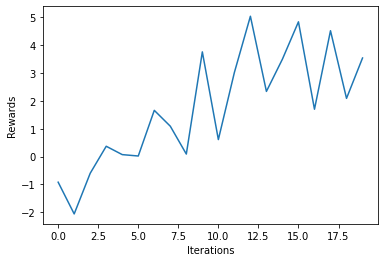

  2%|█▌                                                                          | 2105/100000 [00:46<52:11, 31.27it/s]

Updated Weights
Mean Reward = -1.95
12


  2%|█▋                                                                          | 2205/100000 [00:49<51:50, 31.44it/s]

Updated Weights
Mean Reward = 0.31
17


  2%|█▊                                                                          | 2304/100000 [00:52<53:38, 30.35it/s]

Updated Weights
Mean Reward = 0.67
14


  2%|█▊                                                                          | 2406/100000 [00:56<56:53, 28.59it/s]

Updated Weights
Mean Reward = -1.3
7


  2%|█▉                                                                          | 2499/100000 [00:59<47:53, 33.94it/s]

Updated Weights
Mean Reward = 2.02
24


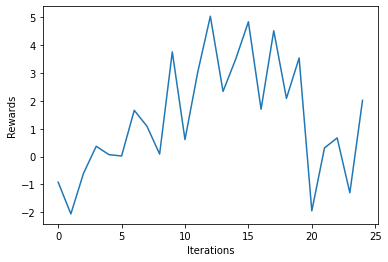

  3%|█▉                                                                          | 2606/100000 [01:02<49:50, 32.57it/s]

Updated Weights
Mean Reward = -1.05
18


  3%|██                                                                          | 2704/100000 [01:05<54:33, 29.72it/s]

Updated Weights
Mean Reward = 0.05
22


  3%|██▏                                                                         | 2804/100000 [01:09<44:40, 36.26it/s]

Updated Weights
Mean Reward = 3.99
18


  3%|██▏                                                                         | 2906/100000 [01:12<49:12, 32.89it/s]

Updated Weights
Mean Reward = 4.48
38


  3%|██▎                                                                         | 2998/100000 [01:15<51:47, 31.21it/s]

Updated Weights
Mean Reward = 3.56
29


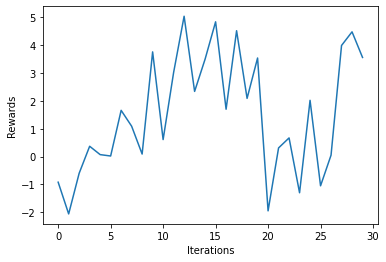

  3%|██▎                                                                         | 3107/100000 [01:19<52:56, 30.50it/s]

Updated Weights
Mean Reward = 1.69
20


  3%|██▍                                                                         | 3205/100000 [01:22<53:13, 30.31it/s]

Updated Weights
Mean Reward = 4.54
27


  3%|██▌                                                                         | 3304/100000 [01:25<49:00, 32.89it/s]

Updated Weights
Mean Reward = 5.74
40


  3%|██▌                                                                         | 3406/100000 [01:28<49:59, 32.21it/s]

Updated Weights
Mean Reward = 5.09
40


  4%|██▋                                                                         | 3500/100000 [01:31<58:25, 27.53it/s]

Updated Weights
Mean Reward = 2.87
37


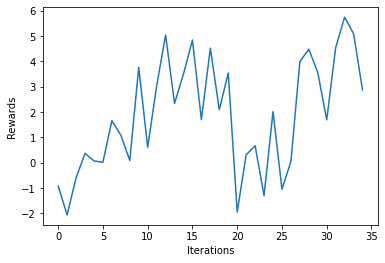

  4%|██▋                                                                       | 3602/100000 [01:35<1:07:26, 23.82it/s]

Updated Weights
Mean Reward = 3.11
16


  4%|██▋                                                                       | 3704/100000 [01:40<1:21:43, 19.64it/s]

Updated Weights
Mean Reward = 4.84
25


  4%|██▊                                                                       | 3802/100000 [01:44<1:21:18, 19.72it/s]

Updated Weights
Mean Reward = 3.7
30


  4%|██▉                                                                       | 3904/100000 [01:49<1:09:02, 23.20it/s]

Updated Weights
Mean Reward = 3.67
33


  4%|██▉                                                                       | 3997/100000 [01:52<1:01:15, 26.12it/s]

Updated Weights
Mean Reward = 4.74
31


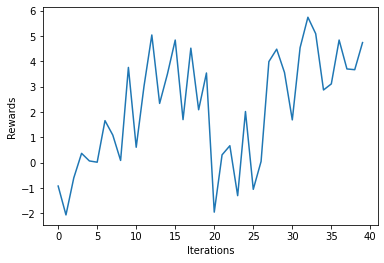

  4%|███                                                                       | 4103/100000 [01:56<1:02:36, 25.53it/s]

Updated Weights
Mean Reward = 1.7
36


  4%|███                                                                       | 4203/100000 [02:01<1:04:06, 24.90it/s]

Updated Weights
Mean Reward = 1.4
26


  4%|███▏                                                                      | 4304/100000 [02:05<1:02:27, 25.53it/s]

Updated Weights
Mean Reward = 1.38
23


  4%|███▎                                                                      | 4406/100000 [02:09<1:07:00, 23.78it/s]

Updated Weights
Mean Reward = 3.32
14


  4%|███▎                                                                      | 4499/100000 [02:13<1:04:44, 24.58it/s]

Updated Weights
Mean Reward = 0.89
14


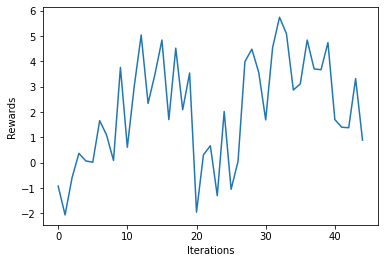

  5%|███▍                                                                        | 4604/100000 [02:17<59:51, 26.56it/s]

Updated Weights
Mean Reward = 3.15
20


  5%|███▌                                                                        | 4704/100000 [02:21<52:59, 29.98it/s]

Updated Weights
Mean Reward = 4.1
28


  5%|███▌                                                                      | 4804/100000 [02:25<1:16:16, 20.80it/s]

Updated Weights
Mean Reward = -4.03
28


  5%|███▋                                                                      | 4902/100000 [02:30<1:14:43, 21.21it/s]

Updated Weights
Mean Reward = -0.55
8


  5%|███▋                                                                      | 5000/100000 [02:34<1:05:46, 24.07it/s]

Updated Weights
Mean Reward = 3.33
15


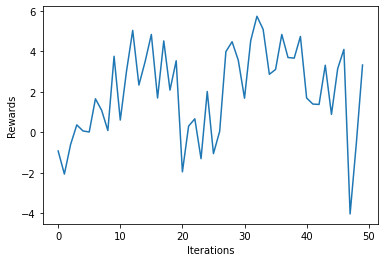

  5%|███▊                                                                      | 5104/100000 [02:39<1:06:02, 23.95it/s]

Updated Weights
Mean Reward = 3.34
17


  5%|███▊                                                                      | 5204/100000 [02:44<1:09:45, 22.65it/s]

Updated Weights
Mean Reward = 2.4
14


  5%|███▉                                                                      | 5305/100000 [02:48<1:02:55, 25.08it/s]

Updated Weights
Mean Reward = 4.78
28


  5%|███▉                                                                      | 5402/100000 [02:52<1:02:04, 25.40it/s]

Updated Weights
Mean Reward = 2.7
15


  6%|████                                                                      | 5500/100000 [02:56<1:00:33, 26.01it/s]

Updated Weights
Mean Reward = 2.99
29


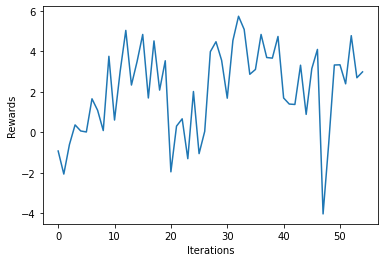

  6%|████▏                                                                     | 5603/100000 [03:01<1:10:23, 22.35it/s]

Updated Weights
Mean Reward = 3.5
9


  6%|████▏                                                                     | 5702/100000 [03:05<1:14:26, 21.11it/s]

Updated Weights
Mean Reward = 4.26
11


  6%|████▎                                                                     | 5804/100000 [03:10<1:17:04, 20.37it/s]

Updated Weights
Mean Reward = 3.76
9


  6%|████▎                                                                     | 5904/100000 [03:15<1:07:32, 23.22it/s]

Updated Weights
Mean Reward = 3.79
11


  6%|████▍                                                                     | 6000/100000 [03:19<1:05:03, 24.08it/s]

Updated Weights
Mean Reward = 3.4
10


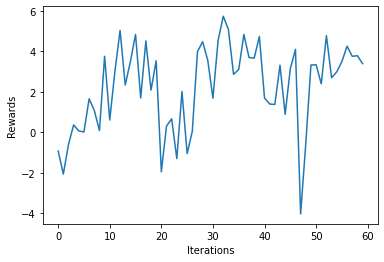

  6%|████▌                                                                     | 6105/100000 [03:23<1:02:19, 25.11it/s]

Updated Weights
Mean Reward = 3.53
27


  6%|████▋                                                                       | 6206/100000 [03:27<53:38, 29.14it/s]

Updated Weights
Mean Reward = 1.31
18


  6%|████▊                                                                       | 6306/100000 [03:30<59:35, 26.21it/s]

Updated Weights
Mean Reward = 4.97
23


  6%|████▋                                                                     | 6404/100000 [03:34<1:03:09, 24.70it/s]

Updated Weights
Mean Reward = 4.35
33


  6%|████▊                                                                     | 6498/100000 [03:38<1:04:51, 24.03it/s]

Updated Weights
Mean Reward = 1.71
14


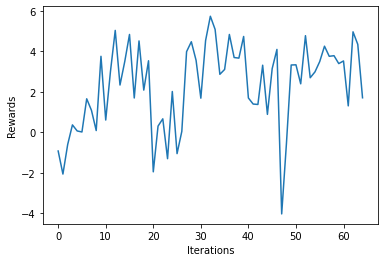

  7%|█████                                                                       | 6603/100000 [03:42<53:21, 29.17it/s]

Updated Weights
Mean Reward = 3.59
37


  7%|█████                                                                       | 6702/100000 [03:46<58:57, 26.38it/s]

Updated Weights
Mean Reward = 3.46
27


  7%|█████▏                                                                      | 6803/100000 [03:50<54:59, 28.25it/s]

Updated Weights
Mean Reward = 3.52
42


  7%|█████                                                                     | 6905/100000 [03:55<1:13:13, 21.19it/s]

Updated Weights
Mean Reward = 0.53
16


  7%|█████▏                                                                    | 6998/100000 [04:00<1:30:02, 17.21it/s]

Updated Weights
Mean Reward = 2.1
11


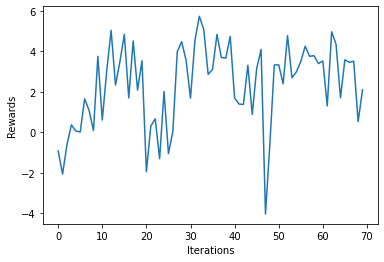

  7%|█████▎                                                                    | 7103/100000 [04:05<1:03:58, 24.20it/s]

Updated Weights
Mean Reward = 3.09
11


  7%|█████▎                                                                    | 7203/100000 [04:09<1:11:01, 21.78it/s]

Updated Weights
Mean Reward = 3.06
11


  7%|█████▍                                                                    | 7304/100000 [04:14<1:05:37, 23.54it/s]

Updated Weights
Mean Reward = 3.01
15


  7%|█████▋                                                                      | 7405/100000 [04:17<58:51, 26.22it/s]

Updated Weights
Mean Reward = 3.69
22


  8%|█████▌                                                                    | 7500/100000 [04:22<1:18:16, 19.70it/s]

Updated Weights
Mean Reward = 3.02
14


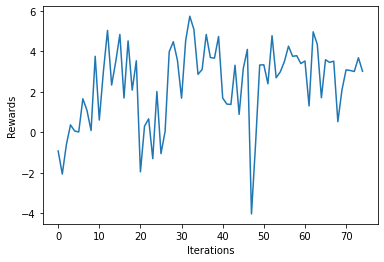

  8%|█████▊                                                                      | 7607/100000 [04:26<52:07, 29.54it/s]

Updated Weights
Mean Reward = 6.01
30


  8%|█████▋                                                                    | 7704/100000 [04:30<1:00:39, 25.36it/s]

Updated Weights
Mean Reward = 3.58
34


  8%|█████▊                                                                    | 7803/100000 [04:35<1:10:10, 21.90it/s]

Updated Weights
Mean Reward = 3.93
16


  8%|█████▊                                                                    | 7902/100000 [04:39<1:13:16, 20.95it/s]

Updated Weights
Mean Reward = 3.01
25


  8%|█████▉                                                                    | 7998/100000 [04:43<1:12:22, 21.19it/s]

Updated Weights
Mean Reward = 1.9
21


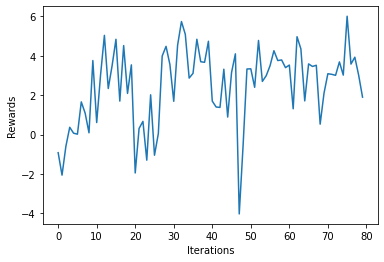

  8%|█████▉                                                                    | 8105/100000 [04:49<1:07:12, 22.79it/s]

Updated Weights
Mean Reward = 4.55
18


  8%|██████▏                                                                     | 8203/100000 [04:53<51:58, 29.43it/s]

Updated Weights
Mean Reward = 5.22
29


  8%|██████▏                                                                   | 8304/100000 [04:58<1:09:34, 21.96it/s]

Updated Weights
Mean Reward = 2.21
24


  8%|██████▏                                                                   | 8403/100000 [05:03<1:07:35, 22.58it/s]

Updated Weights
Mean Reward = 4.22
21


  8%|██████▎                                                                   | 8500/100000 [05:07<1:12:39, 20.99it/s]

Updated Weights
Mean Reward = 5.08
33


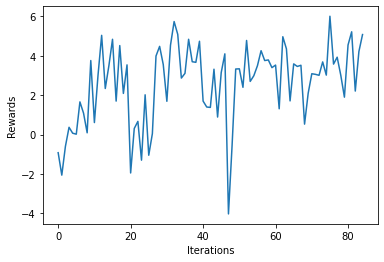

  9%|██████▎                                                                   | 8604/100000 [05:12<1:10:12, 21.70it/s]

Updated Weights
Mean Reward = 5.85
33


  9%|██████▍                                                                   | 8703/100000 [05:16<1:05:51, 23.10it/s]

Updated Weights
Mean Reward = 4.15
26


  9%|██████▌                                                                   | 8804/100000 [05:21<1:14:14, 20.47it/s]

Updated Weights
Mean Reward = 0.75
19


  9%|██████▌                                                                   | 8905/100000 [05:26<1:07:45, 22.41it/s]

Updated Weights
Mean Reward = 4.94
19


  9%|██████▋                                                                   | 8999/100000 [05:30<1:12:06, 21.03it/s]

Updated Weights
Mean Reward = 7.23
28


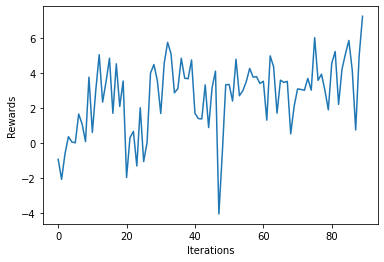

  9%|██████▋                                                                   | 9105/100000 [05:34<1:04:13, 23.59it/s]

Updated Weights
Mean Reward = 4.39
36


  9%|██████▊                                                                   | 9204/100000 [05:39<1:12:46, 20.79it/s]

Updated Weights
Mean Reward = 4.24
30


  9%|██████▉                                                                   | 9304/100000 [05:43<1:09:39, 21.70it/s]

Updated Weights
Mean Reward = 4.47
22


  9%|██████▉                                                                   | 9406/100000 [05:48<1:00:25, 24.99it/s]

Updated Weights
Mean Reward = 4.48
19


 10%|███████                                                                   | 9500/100000 [05:52<1:17:44, 19.40it/s]

Updated Weights
Mean Reward = 2.59
27


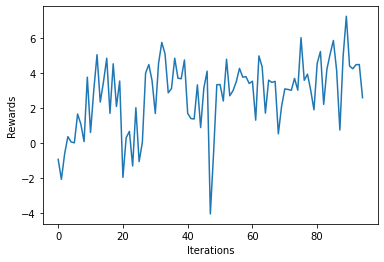

 10%|███████                                                                   | 9604/100000 [05:57<1:04:08, 23.49it/s]

Updated Weights
Mean Reward = 6.72
32


 10%|███████▏                                                                  | 9704/100000 [06:02<1:26:24, 17.42it/s]

Updated Weights
Mean Reward = 3.7
21


 10%|███████▎                                                                  | 9804/100000 [06:07<1:15:35, 19.89it/s]

Updated Weights
Mean Reward = 3.9
27


 10%|███████▎                                                                  | 9903/100000 [06:12<1:10:38, 21.26it/s]

Updated Weights
Mean Reward = 3.54
19


 10%|███████▍                                                                  | 9999/100000 [06:16<1:01:58, 24.21it/s]

Updated Weights
Mean Reward = 3.35
22


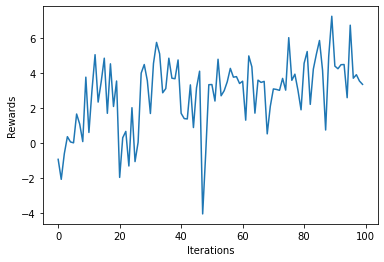

 10%|███████▍                                                                 | 10104/100000 [06:24<1:27:41, 17.09it/s]

Updated Weights
Mean Reward = 0.74
15


 10%|███████▍                                                                 | 10203/100000 [06:31<1:55:58, 12.90it/s]

Updated Weights
Mean Reward = 1.82
24


 10%|███████▌                                                                 | 10304/100000 [06:39<2:02:10, 12.24it/s]

Updated Weights
Mean Reward = 0.88
16


 10%|███████▌                                                                 | 10403/100000 [06:46<1:39:23, 15.02it/s]

Updated Weights
Mean Reward = 3.21
19


 10%|███████▋                                                                 | 10500/100000 [06:52<1:54:33, 13.02it/s]

Updated Weights
Mean Reward = 1.2
17


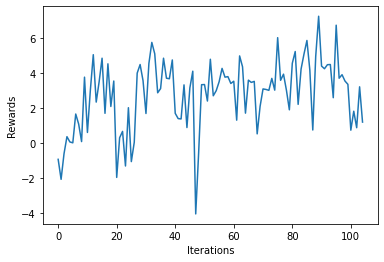

 11%|███████▋                                                                 | 10602/100000 [06:59<1:35:48, 15.55it/s]

Updated Weights
Mean Reward = 3.15
12


 11%|███████▊                                                                 | 10702/100000 [07:04<1:24:44, 17.56it/s]

Updated Weights
Mean Reward = 3.16
11


 11%|███████▉                                                                 | 10803/100000 [07:09<1:03:29, 23.41it/s]

Updated Weights
Mean Reward = 5.56
26


 11%|███████▉                                                                 | 10904/100000 [07:14<1:21:39, 18.18it/s]

Updated Weights
Mean Reward = 4.26
29


 11%|████████                                                                 | 11000/100000 [07:19<1:08:35, 21.63it/s]

Updated Weights
Mean Reward = 3.2
27


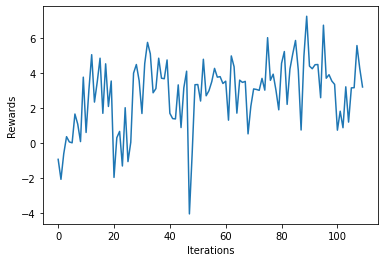

 11%|████████                                                                 | 11103/100000 [07:25<1:21:38, 18.15it/s]

Updated Weights
Mean Reward = 0.66
15


 11%|████████▏                                                                | 11203/100000 [07:30<1:19:52, 18.53it/s]

Updated Weights
Mean Reward = 3.78
19


 11%|████████▎                                                                | 11302/100000 [07:36<1:18:06, 18.93it/s]

Updated Weights
Mean Reward = 3.03
13


 11%|████████▎                                                                | 11404/100000 [07:41<1:27:51, 16.81it/s]

Updated Weights
Mean Reward = 3.16
16


 12%|████████▍                                                                | 11500/100000 [07:46<1:28:36, 16.65it/s]

Updated Weights
Mean Reward = 3.67
23


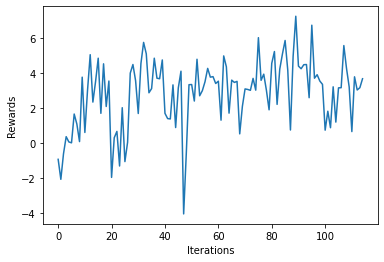

 12%|████████▍                                                                | 11602/100000 [07:52<1:35:04, 15.50it/s]

Updated Weights
Mean Reward = 2.2
10


 12%|████████▌                                                                | 11703/100000 [07:58<1:25:16, 17.26it/s]

Updated Weights
Mean Reward = 2.95
20


 12%|████████▌                                                                | 11803/100000 [08:03<1:29:55, 16.35it/s]

Updated Weights
Mean Reward = 1.4
11


 12%|████████▋                                                                | 11904/100000 [08:08<1:14:24, 19.73it/s]

Updated Weights
Mean Reward = 2.58
30


 12%|████████▊                                                                | 11998/100000 [08:13<1:04:50, 22.62it/s]

Updated Weights
Mean Reward = 1.93
24


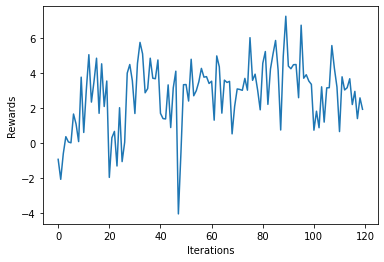

 12%|████████▊                                                                | 12104/100000 [08:18<1:05:24, 22.39it/s]

Updated Weights
Mean Reward = 2.52
22


 12%|████████▉                                                                | 12204/100000 [08:23<1:04:31, 22.67it/s]

Updated Weights
Mean Reward = 6.56
35


 12%|████████▉                                                                | 12304/100000 [08:28<1:08:07, 21.45it/s]

Updated Weights
Mean Reward = 1.15
30


 12%|█████████                                                                | 12404/100000 [08:33<1:23:40, 17.45it/s]

Updated Weights
Mean Reward = 2.04
10


 12%|█████████▏                                                               | 12500/100000 [08:38<1:23:00, 17.57it/s]

Updated Weights
Mean Reward = 3.97
18


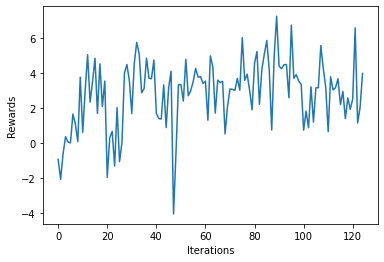

 13%|█████████▏                                                               | 12603/100000 [08:44<1:12:34, 20.07it/s]

Updated Weights
Mean Reward = 3.6
13


 13%|█████████▎                                                               | 12702/100000 [08:48<1:04:39, 22.50it/s]

Updated Weights
Mean Reward = 4.79
28


 13%|█████████▎                                                               | 12803/100000 [08:53<1:07:41, 21.47it/s]

Updated Weights
Mean Reward = 1.93
23


 13%|█████████▍                                                               | 12902/100000 [08:57<1:06:51, 21.71it/s]

Updated Weights
Mean Reward = 3.54
22


 13%|█████████▍                                                               | 12999/100000 [09:01<1:00:58, 23.78it/s]

Updated Weights
Mean Reward = 2.93
18


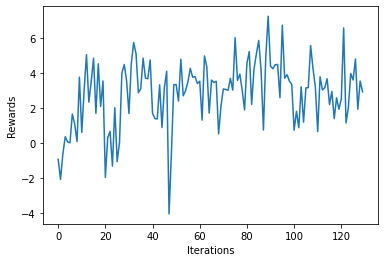

 13%|█████████▊                                                                 | 13108/100000 [09:05<47:15, 30.64it/s]

Updated Weights
Mean Reward = 3.31
19


 13%|█████████▋                                                               | 13205/100000 [09:09<1:00:21, 23.97it/s]

Updated Weights
Mean Reward = 2.69
21


 13%|█████████▉                                                                 | 13304/100000 [09:13<57:24, 25.17it/s]

Updated Weights
Mean Reward = 3.05
13


 13%|██████████                                                                 | 13403/100000 [09:17<59:08, 24.40it/s]

Updated Weights
Mean Reward = 2.37
15


 14%|██████████▏                                                                | 13500/100000 [09:21<52:43, 27.34it/s]

Updated Weights
Mean Reward = 2.52
15


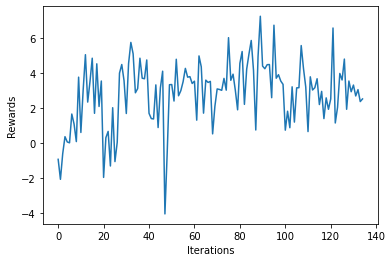

 14%|██████████▏                                                                | 13605/100000 [09:25<53:48, 26.76it/s]

Updated Weights
Mean Reward = 3.47
18


 14%|██████████▎                                                                | 13703/100000 [09:28<55:22, 25.98it/s]

Updated Weights
Mean Reward = 3.48
24


 14%|██████████                                                               | 13803/100000 [09:32<1:00:34, 23.71it/s]

Updated Weights
Mean Reward = 0.83
12


 14%|██████████▍                                                                | 13903/100000 [09:36<57:13, 25.07it/s]

Updated Weights
Mean Reward = -5.39
10


 14%|██████████▌                                                                | 14000/100000 [09:40<58:02, 24.70it/s]

Updated Weights
Mean Reward = 0.8
11


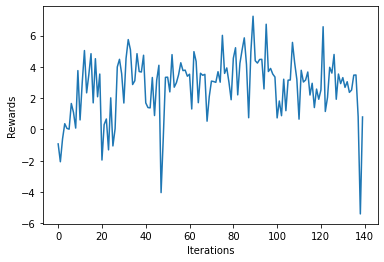

 14%|██████████▌                                                                | 14104/100000 [09:44<57:31, 24.89it/s]

Updated Weights
Mean Reward = 4.92
23


 14%|██████████▋                                                                | 14204/100000 [09:48<53:06, 26.92it/s]

Updated Weights
Mean Reward = 4.13
10


 14%|██████████▋                                                                | 14302/100000 [09:52<58:51, 24.26it/s]

Updated Weights
Mean Reward = 4.87
27


 14%|██████████▌                                                              | 14402/100000 [09:56<1:04:40, 22.06it/s]

Updated Weights
Mean Reward = 4.42
25


 14%|██████████▌                                                              | 14498/100000 [10:00<1:06:55, 21.29it/s]

Updated Weights
Mean Reward = 4.53
19


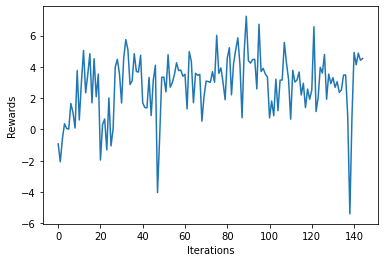

 15%|██████████▋                                                              | 14604/100000 [10:06<1:04:47, 21.97it/s]

Updated Weights
Mean Reward = 3.22
18


 15%|██████████▋                                                              | 14704/100000 [10:10<1:10:25, 20.19it/s]

Updated Weights
Mean Reward = 5.72
24


 15%|███████████                                                                | 14804/100000 [10:14<56:32, 25.12it/s]

Updated Weights
Mean Reward = 3.86
25


 15%|██████████▉                                                              | 14903/100000 [10:19<1:07:43, 20.94it/s]

Updated Weights
Mean Reward = -3.53
13


 15%|██████████▉                                                              | 15000/100000 [10:24<1:05:18, 21.69it/s]

Updated Weights
Mean Reward = 3.33
18


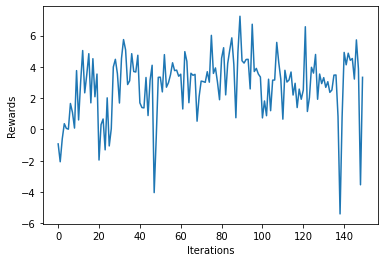

 15%|███████████                                                              | 15103/100000 [10:28<1:01:25, 23.03it/s]

Updated Weights
Mean Reward = 5.09
34


 15%|███████████                                                              | 15202/100000 [10:32<1:03:05, 22.40it/s]

Updated Weights
Mean Reward = 0.33
20


 15%|███████████▍                                                               | 15305/100000 [10:36<57:00, 24.76it/s]

Updated Weights
Mean Reward = 4.28
29


 15%|███████████▌                                                               | 15405/100000 [10:40<49:21, 28.56it/s]

Updated Weights
Mean Reward = 5.12
32


 16%|███████████▋                                                               | 15500/100000 [10:43<45:43, 30.80it/s]

Updated Weights
Mean Reward = 5.17
39


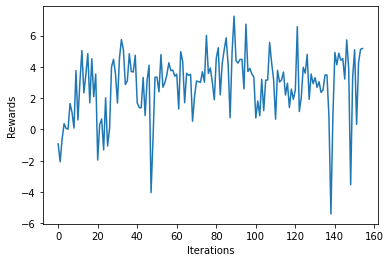

 16%|███████████▋                                                               | 15605/100000 [10:48<59:08, 23.78it/s]

Updated Weights
Mean Reward = 3.45
25


 16%|███████████▊                                                               | 15704/100000 [10:52<54:57, 25.56it/s]

Updated Weights
Mean Reward = 3.3
29


 16%|███████████▊                                                               | 15802/100000 [10:55<51:24, 27.30it/s]

Updated Weights
Mean Reward = 4.83
28


 16%|███████████▉                                                               | 15906/100000 [10:59<55:58, 25.04it/s]

Updated Weights
Mean Reward = 3.52
29


 16%|████████████                                                               | 16000/100000 [11:03<52:44, 26.55it/s]

Updated Weights
Mean Reward = 3.74
28


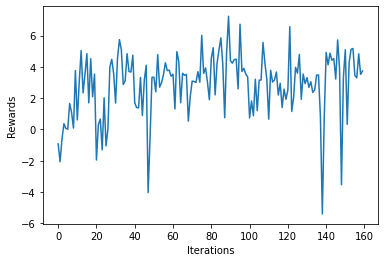

 16%|████████████                                                               | 16106/100000 [11:07<59:02, 23.68it/s]

Updated Weights
Mean Reward = 2.21
23


 16%|████████████▏                                                              | 16204/100000 [11:11<48:27, 28.82it/s]

Updated Weights
Mean Reward = 5.17
37


 16%|████████████▏                                                              | 16305/100000 [11:15<50:27, 27.65it/s]

Updated Weights
Mean Reward = 4.29
25


 16%|███████████▉                                                             | 16405/100000 [11:19<1:00:41, 22.96it/s]

Updated Weights
Mean Reward = 3.62
24


 16%|████████████▎                                                              | 16499/100000 [11:22<55:27, 25.09it/s]

Updated Weights
Mean Reward = 4.33
22


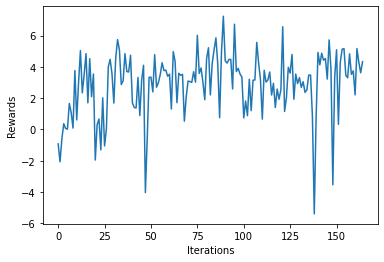

 17%|████████████▍                                                              | 16606/100000 [11:27<57:41, 24.09it/s]

Updated Weights
Mean Reward = 3.24
23


 17%|████████████▌                                                              | 16704/100000 [11:31<52:57, 26.21it/s]

Updated Weights
Mean Reward = 5.19
30


 17%|████████████▌                                                              | 16806/100000 [11:35<49:41, 27.90it/s]

Updated Weights
Mean Reward = 4.18
26


 17%|████████████▋                                                              | 16904/100000 [11:38<48:52, 28.33it/s]

Updated Weights
Mean Reward = 5.06
39


 17%|████████████▋                                                              | 16999/100000 [11:42<52:09, 26.52it/s]

Updated Weights
Mean Reward = 4.97
40


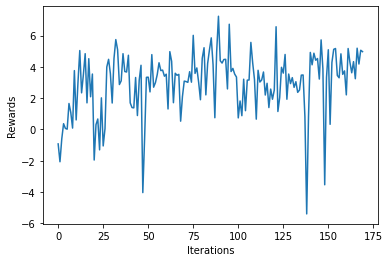

 17%|████████████▍                                                            | 17102/100000 [11:46<1:08:13, 20.25it/s]

Updated Weights
Mean Reward = 4.15
44


 17%|████████████▌                                                            | 17204/100000 [11:50<1:03:56, 21.58it/s]

Updated Weights
Mean Reward = 1.91
25


 17%|████████████▉                                                              | 17305/100000 [11:55<57:21, 24.03it/s]

Updated Weights
Mean Reward = 3.45
13


 17%|█████████████                                                              | 17403/100000 [11:59<57:13, 24.06it/s]

Updated Weights
Mean Reward = 4.09
15


 18%|████████████▊                                                            | 17500/100000 [12:04<1:09:01, 19.92it/s]

Updated Weights
Mean Reward = 3.92
22


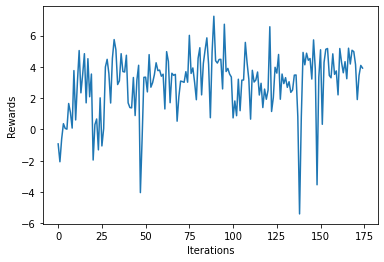

 18%|█████████████▏                                                             | 17607/100000 [12:08<45:43, 30.03it/s]

Updated Weights
Mean Reward = 5.75
36


 18%|█████████████▎                                                             | 17704/100000 [12:11<54:31, 25.15it/s]

Updated Weights
Mean Reward = 3.87
27


 18%|████████████▉                                                            | 17804/100000 [12:15<1:09:15, 19.78it/s]

Updated Weights
Mean Reward = 3.08
24


 18%|█████████████▍                                                             | 17903/100000 [12:19<49:42, 27.53it/s]

Updated Weights
Mean Reward = 3.43
18


 18%|█████████████▍                                                             | 17997/100000 [12:22<49:01, 27.88it/s]

Updated Weights
Mean Reward = 6.54
32


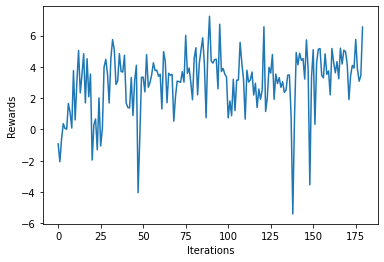

 18%|█████████████▌                                                             | 18105/100000 [12:26<41:04, 33.24it/s]

Updated Weights
Mean Reward = 6.0
34


 18%|█████████████▋                                                             | 18205/100000 [12:30<39:34, 34.45it/s]

Updated Weights
Mean Reward = 4.27
27


 18%|█████████████▋                                                             | 18304/100000 [12:33<44:17, 30.74it/s]

Updated Weights
Mean Reward = 5.86
41


 18%|█████████████▊                                                             | 18405/100000 [12:37<48:45, 27.89it/s]

Updated Weights
Mean Reward = 3.23
22


 18%|█████████████▉                                                             | 18500/100000 [12:40<50:16, 27.02it/s]

Updated Weights
Mean Reward = 4.41
17


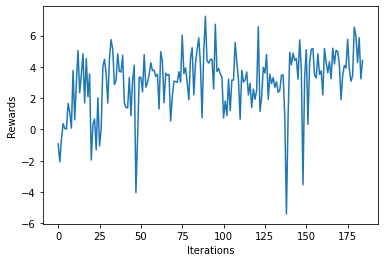

 19%|█████████████▉                                                             | 18605/100000 [12:45<48:45, 27.83it/s]

Updated Weights
Mean Reward = 5.63
25


 19%|██████████████                                                             | 18705/100000 [12:48<44:50, 30.21it/s]

Updated Weights
Mean Reward = 3.87
29


 19%|██████████████                                                             | 18803/100000 [12:51<43:51, 30.86it/s]

Updated Weights
Mean Reward = 4.57
35


 19%|██████████████▏                                                            | 18905/100000 [12:55<48:34, 27.82it/s]

Updated Weights
Mean Reward = 3.33
25


 19%|██████████████▏                                                            | 18999/100000 [12:58<48:08, 28.04it/s]

Updated Weights
Mean Reward = 3.53
26


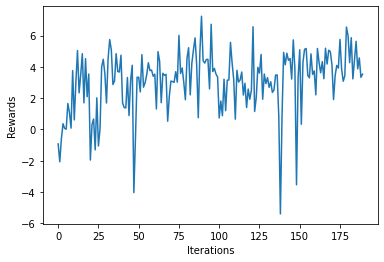

 19%|██████████████▎                                                            | 19105/100000 [13:02<51:13, 26.32it/s]

Updated Weights
Mean Reward = 3.89
28


 19%|██████████████▍                                                            | 19203/100000 [13:06<57:17, 23.51it/s]

Updated Weights
Mean Reward = 3.72
17


 19%|██████████████▍                                                            | 19304/100000 [13:10<52:09, 25.79it/s]

Updated Weights
Mean Reward = 2.74
19


 19%|██████████████▌                                                            | 19404/100000 [13:14<54:53, 24.47it/s]

Updated Weights
Mean Reward = 1.19
11


 20%|██████████████▋                                                            | 19500/100000 [13:17<45:21, 29.58it/s]

Updated Weights
Mean Reward = 3.9
20


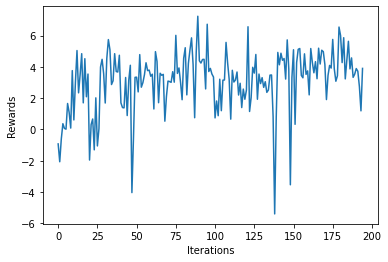

 20%|██████████████▋                                                            | 19606/100000 [13:21<48:42, 27.51it/s]

Updated Weights
Mean Reward = 5.51
28


 20%|██████████████▊                                                            | 19703/100000 [13:25<51:05, 26.19it/s]

Updated Weights
Mean Reward = 4.72
22


 20%|██████████████▊                                                            | 19807/100000 [13:28<46:03, 29.02it/s]

Updated Weights
Mean Reward = 3.32
24


 20%|██████████████▉                                                            | 19905/100000 [13:32<50:28, 26.45it/s]

Updated Weights
Mean Reward = 5.56
28


 20%|██████████████▉                                                            | 19999/100000 [13:36<55:11, 24.16it/s]

Updated Weights
Mean Reward = 2.71
10


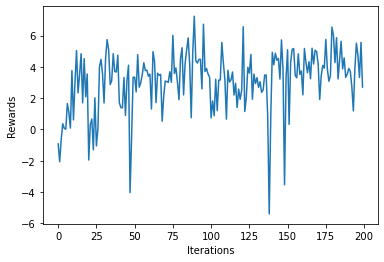

 20%|███████████████                                                            | 20105/100000 [13:40<50:03, 26.60it/s]

Updated Weights
Mean Reward = 3.4
20


 20%|███████████████▏                                                           | 20202/100000 [13:44<54:05, 24.59it/s]

Updated Weights
Mean Reward = 2.75
21


 20%|███████████████▏                                                           | 20304/100000 [13:47<47:13, 28.12it/s]

Updated Weights
Mean Reward = 5.7
27


 20%|███████████████▎                                                           | 20403/100000 [13:51<49:28, 26.81it/s]

Updated Weights
Mean Reward = 3.5
27


 20%|███████████████▎                                                           | 20498/100000 [13:55<52:15, 25.35it/s]

Updated Weights
Mean Reward = 1.62
18


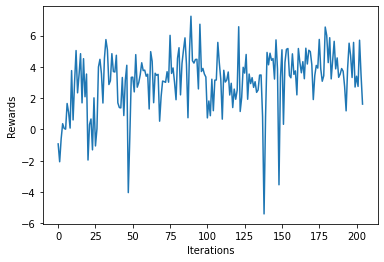

 21%|███████████████▍                                                           | 20604/100000 [13:59<49:46, 26.58it/s]

Updated Weights
Mean Reward = 1.72
14


 21%|███████████████▌                                                           | 20703/100000 [14:03<42:59, 30.74it/s]

Updated Weights
Mean Reward = 3.86
19


 21%|███████████████▌                                                           | 20803/100000 [14:06<49:56, 26.43it/s]

Updated Weights
Mean Reward = 5.24
30


 21%|███████████████▋                                                           | 20905/100000 [14:11<41:41, 31.62it/s]

Updated Weights
Mean Reward = 4.98
28


 21%|███████████████▋                                                           | 20998/100000 [14:15<57:32, 22.88it/s]

Updated Weights
Mean Reward = 5.92
40


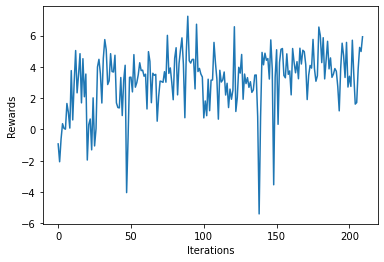

 21%|███████████████▍                                                         | 21103/100000 [14:20<1:01:21, 21.43it/s]

Updated Weights
Mean Reward = 2.05
22


 21%|███████████████▍                                                         | 21205/100000 [14:24<1:05:09, 20.15it/s]

Updated Weights
Mean Reward = 6.25
33


 21%|███████████████▌                                                         | 21303/100000 [14:29<1:17:39, 16.89it/s]

Updated Weights
Mean Reward = 5.06
34


 21%|████████████████                                                           | 21403/100000 [14:35<58:48, 22.27it/s]

Updated Weights
Mean Reward = 2.84
28


 22%|███████████████▋                                                         | 21500/100000 [14:39<1:01:54, 21.14it/s]

Updated Weights
Mean Reward = 3.72
25


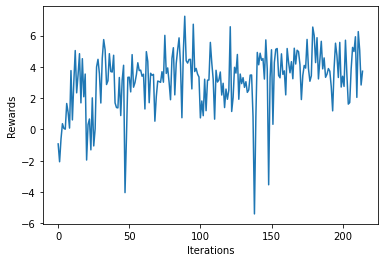

 22%|████████████████▏                                                          | 21604/100000 [14:43<57:20, 22.79it/s]

Updated Weights
Mean Reward = 4.49
30


 22%|████████████████▎                                                          | 21704/100000 [14:47<56:23, 23.14it/s]

Updated Weights
Mean Reward = 3.58
18


 22%|████████████████▎                                                          | 21803/100000 [14:52<56:05, 23.23it/s]

Updated Weights
Mean Reward = 3.75
22


 22%|███████████████▉                                                         | 21903/100000 [14:56<1:03:13, 20.59it/s]

Updated Weights
Mean Reward = 4.37
23


 22%|████████████████▍                                                          | 21999/100000 [15:00<56:02, 23.20it/s]

Updated Weights
Mean Reward = 4.99
28


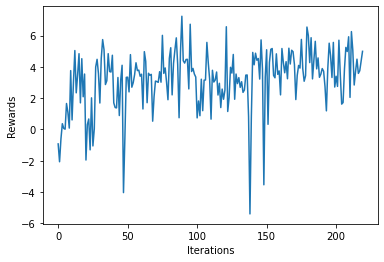

 22%|████████████████▌                                                          | 22105/100000 [15:05<52:05, 24.92it/s]

Updated Weights
Mean Reward = 3.68
21


 22%|████████████████▋                                                          | 22204/100000 [15:09<50:23, 25.73it/s]

Updated Weights
Mean Reward = 5.13
35


 22%|████████████████▋                                                          | 22304/100000 [15:13<55:38, 23.27it/s]

Updated Weights
Mean Reward = 5.93
36


 22%|████████████████▎                                                        | 22405/100000 [15:18<1:02:14, 20.78it/s]

Updated Weights
Mean Reward = 2.18
26


 22%|████████████████▊                                                          | 22499/100000 [15:22<58:46, 21.98it/s]

Updated Weights
Mean Reward = 3.16
18


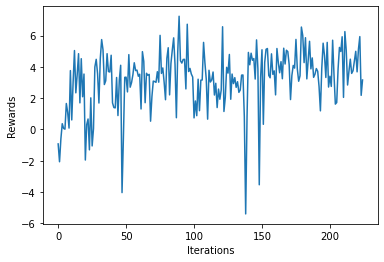

 23%|████████████████▍                                                        | 22602/100000 [15:28<1:03:21, 20.36it/s]

Updated Weights
Mean Reward = 2.09
12


 23%|█████████████████                                                          | 22704/100000 [15:32<53:21, 24.14it/s]

Updated Weights
Mean Reward = 4.07
25


 23%|█████████████████                                                          | 22805/100000 [15:37<53:19, 24.12it/s]

Updated Weights
Mean Reward = 4.12
25


 23%|█████████████████▏                                                         | 22904/100000 [15:41<45:57, 27.96it/s]

Updated Weights
Mean Reward = 4.36
30


 23%|█████████████████▏                                                         | 22999/100000 [15:45<58:02, 22.11it/s]

Updated Weights
Mean Reward = 4.94
29


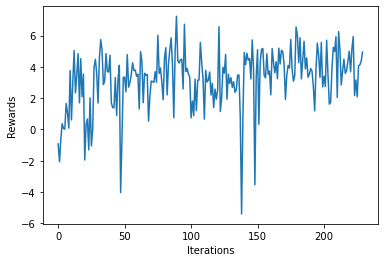

 23%|█████████████████▎                                                         | 23104/100000 [15:50<58:28, 21.92it/s]

Updated Weights
Mean Reward = 4.6
28


 23%|█████████████████▍                                                         | 23204/100000 [15:55<57:13, 22.37it/s]

Updated Weights
Mean Reward = 1.82
22


 23%|█████████████████                                                        | 23303/100000 [15:59<1:01:11, 20.89it/s]

Updated Weights
Mean Reward = -1.6
20


 23%|█████████████████                                                        | 23404/100000 [16:04<1:06:09, 19.30it/s]

Updated Weights
Mean Reward = 2.28
14


 24%|█████████████████▏                                                       | 23500/100000 [16:09<1:00:01, 21.24it/s]

Updated Weights
Mean Reward = 0.91
9


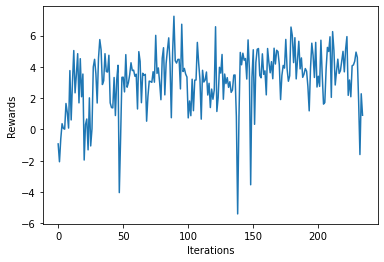

 24%|█████████████████▋                                                         | 23603/100000 [16:14<54:56, 23.17it/s]

Updated Weights
Mean Reward = -0.01
14


 24%|█████████████████▎                                                       | 23701/100000 [16:19<1:03:42, 19.96it/s]

Updated Weights
Mean Reward = 2.17
13


 24%|█████████████████▍                                                       | 23804/100000 [16:24<1:04:17, 19.75it/s]

Updated Weights
Mean Reward = 2.12
15


 24%|█████████████████▉                                                         | 23907/100000 [16:29<52:23, 24.21it/s]

Updated Weights
Mean Reward = 4.06
20


 24%|█████████████████▌                                                       | 23999/100000 [16:33<1:00:11, 21.05it/s]

Updated Weights
Mean Reward = 5.13
36


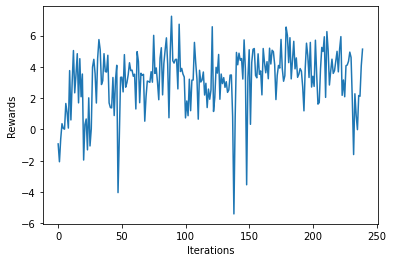

 24%|█████████████████▌                                                       | 24102/100000 [16:38<1:08:43, 18.40it/s]

Updated Weights
Mean Reward = 3.89
21


 24%|█████████████████▋                                                       | 24204/100000 [16:44<1:00:37, 20.83it/s]

Updated Weights
Mean Reward = 3.73
22


 24%|█████████████████▋                                                       | 24301/100000 [16:49<1:01:46, 20.42it/s]

Updated Weights
Mean Reward = 3.78
20


 24%|██████████████████▎                                                        | 24405/100000 [16:54<59:48, 21.07it/s]

Updated Weights
Mean Reward = 3.05
22


 24%|██████████████████▎                                                        | 24498/100000 [16:58<57:54, 21.73it/s]

Updated Weights
Mean Reward = 5.78
35


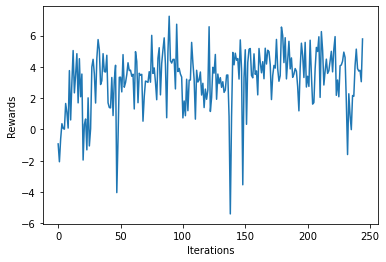

 25%|█████████████████▉                                                       | 24603/100000 [17:05<1:25:41, 14.66it/s]

Updated Weights
Mean Reward = 3.85
21


 25%|██████████████████                                                       | 24703/100000 [17:10<1:08:11, 18.40it/s]

Updated Weights
Mean Reward = 5.16
30


 25%|██████████████████                                                       | 24803/100000 [17:16<1:18:52, 15.89it/s]

Updated Weights
Mean Reward = 4.7
23


 25%|██████████████████▋                                                        | 24903/100000 [17:21<55:49, 22.42it/s]

Updated Weights
Mean Reward = 5.58
34


 25%|██████████████████▋                                                        | 24999/100000 [17:25<55:23, 22.57it/s]

Updated Weights
Mean Reward = 5.71
32


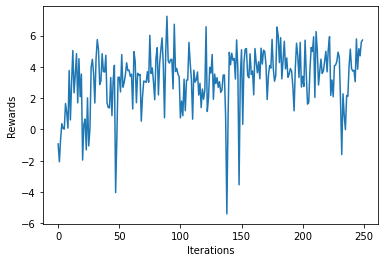

 25%|██████████████████▊                                                        | 25103/100000 [17:30<58:19, 21.40it/s]

Updated Weights
Mean Reward = 5.43
31


 25%|██████████████████▍                                                      | 25202/100000 [17:35<1:11:11, 17.51it/s]

Updated Weights
Mean Reward = 2.53
16


 25%|██████████████████▍                                                      | 25303/100000 [17:41<1:24:30, 14.73it/s]

Updated Weights
Mean Reward = 3.52
18


 25%|██████████████████▌                                                      | 25401/100000 [17:47<1:04:11, 19.37it/s]

Updated Weights
Mean Reward = 5.64
30


 26%|██████████████████▌                                                      | 25500/100000 [17:53<1:07:10, 18.48it/s]

Updated Weights
Mean Reward = 3.86
16


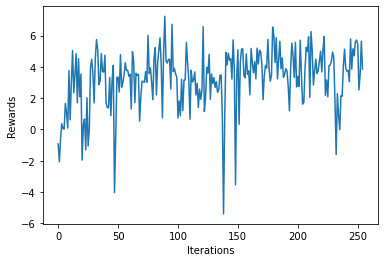

 26%|██████████████████▋                                                      | 25603/100000 [17:58<1:01:01, 20.32it/s]

Updated Weights
Mean Reward = 6.55
35


 26%|███████████████████▎                                                       | 25704/100000 [18:03<57:05, 21.69it/s]

Updated Weights
Mean Reward = 5.61
37


 26%|██████████████████▊                                                      | 25802/100000 [18:10<1:21:40, 15.14it/s]

Updated Weights
Mean Reward = 1.8
11


 26%|██████████████████▉                                                      | 25902/100000 [18:16<1:19:26, 15.55it/s]

Updated Weights
Mean Reward = 3.32
13


 26%|██████████████████▉                                                      | 26000/100000 [18:22<1:10:15, 17.55it/s]

Updated Weights
Mean Reward = 1.22
18


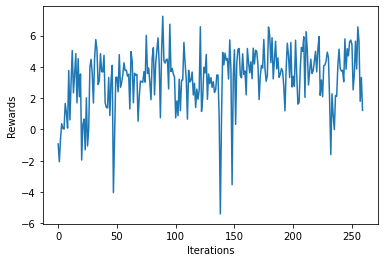

 26%|███████████████████                                                      | 26103/100000 [18:27<1:08:45, 17.91it/s]

Updated Weights
Mean Reward = 4.71
27


 26%|███████████████████▏                                                     | 26203/100000 [18:34<1:06:17, 18.55it/s]

Updated Weights
Mean Reward = -1.38
11


 26%|███████████████████▋                                                       | 26304/100000 [18:38<56:01, 21.93it/s]

Updated Weights
Mean Reward = 2.5
17


 26%|███████████████████▊                                                       | 26405/100000 [18:43<53:06, 23.10it/s]

Updated Weights
Mean Reward = 3.22
14


 26%|███████████████████▊                                                       | 26499/100000 [18:47<57:02, 21.48it/s]

Updated Weights
Mean Reward = 4.18
19


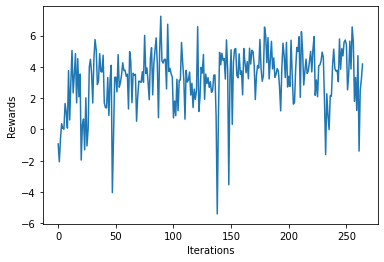

 27%|███████████████████▉                                                       | 26603/100000 [18:52<58:45, 20.82it/s]

Updated Weights
Mean Reward = 2.74
21


 27%|████████████████████                                                       | 26704/100000 [18:57<56:13, 21.73it/s]

Updated Weights
Mean Reward = 4.66
25


 27%|████████████████████                                                       | 26804/100000 [19:01<50:16, 24.27it/s]

Updated Weights
Mean Reward = 4.02
29


 27%|████████████████████▏                                                      | 26906/100000 [19:06<47:20, 25.73it/s]

Updated Weights
Mean Reward = 3.6
19


 27%|███████████████████▋                                                     | 26998/100000 [19:09<1:02:21, 19.51it/s]

Updated Weights
Mean Reward = 4.0
26


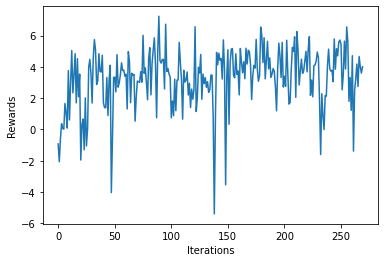

 27%|███████████████████▊                                                     | 27101/100000 [19:14<1:02:47, 19.35it/s]

Updated Weights
Mean Reward = 5.41
32


 27%|███████████████████▊                                                     | 27203/100000 [19:19<1:04:46, 18.73it/s]

Updated Weights
Mean Reward = 3.54
13


 27%|████████████████████▍                                                      | 27303/100000 [19:23<51:17, 23.62it/s]

Updated Weights
Mean Reward = 4.39
22


 27%|████████████████████▌                                                      | 27405/100000 [19:27<43:31, 27.80it/s]

Updated Weights
Mean Reward = 5.02
25


 27%|████████████████████                                                     | 27499/100000 [19:31<1:00:42, 19.90it/s]

Updated Weights
Mean Reward = 4.68
27


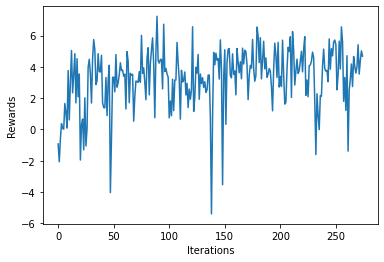

 28%|████████████████████▏                                                    | 27602/100000 [19:36<1:07:27, 17.89it/s]

Updated Weights
Mean Reward = 4.89
25


 28%|████████████████████▊                                                      | 27705/100000 [19:41<42:57, 28.04it/s]

Updated Weights
Mean Reward = 5.73
27


 28%|████████████████████▊                                                      | 27805/100000 [19:45<57:43, 20.84it/s]

Updated Weights
Mean Reward = 5.03
29


 28%|████████████████████▉                                                      | 27905/100000 [19:50<54:01, 22.24it/s]

Updated Weights
Mean Reward = 2.68
17


 28%|█████████████████████                                                      | 28000/100000 [19:54<54:02, 22.21it/s]

Updated Weights
Mean Reward = 4.12
24


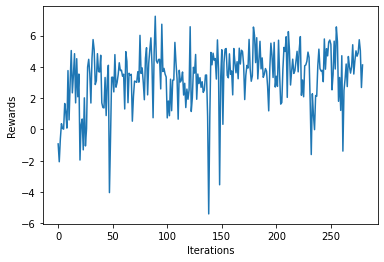

 28%|█████████████████████                                                      | 28105/100000 [19:58<50:52, 23.56it/s]

Updated Weights
Mean Reward = 4.81
24


 28%|█████████████████████▏                                                     | 28202/100000 [20:02<48:32, 24.65it/s]

Updated Weights
Mean Reward = 3.56
25


 28%|█████████████████████▏                                                     | 28303/100000 [20:06<37:43, 31.67it/s]

Updated Weights
Mean Reward = 5.01
29


 28%|█████████████████████▎                                                     | 28404/100000 [20:10<53:51, 22.16it/s]

Updated Weights
Mean Reward = 2.72
20


 28%|█████████████████████▎                                                     | 28499/100000 [20:13<45:53, 25.97it/s]

Updated Weights
Mean Reward = -0.59
20


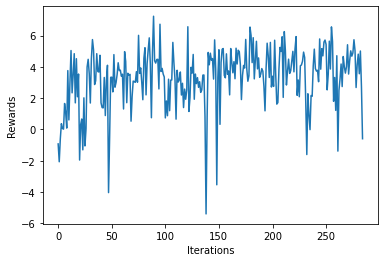

 29%|█████████████████████▍                                                     | 28604/100000 [20:17<43:52, 27.12it/s]

Updated Weights
Mean Reward = 5.96
28


 29%|█████████████████████▌                                                     | 28705/100000 [20:21<50:29, 23.53it/s]

Updated Weights
Mean Reward = 4.6
22


 29%|█████████████████████▌                                                     | 28803/100000 [20:25<46:59, 25.25it/s]

Updated Weights
Mean Reward = 4.96
27


 29%|█████████████████████▋                                                     | 28905/100000 [20:29<47:18, 25.05it/s]

Updated Weights
Mean Reward = 4.54
21


 29%|█████████████████████▊                                                     | 29000/100000 [20:32<42:45, 27.68it/s]

Updated Weights
Mean Reward = 4.89
23


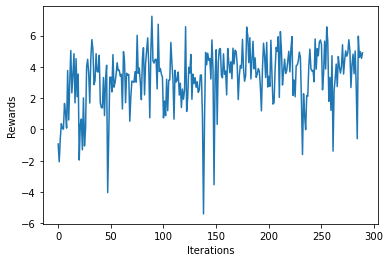

 29%|█████████████████████▊                                                     | 29106/100000 [20:36<39:09, 30.17it/s]

Updated Weights
Mean Reward = 4.63
28


 29%|█████████████████████▉                                                     | 29204/100000 [20:40<43:25, 27.18it/s]

Updated Weights
Mean Reward = 5.4
29


 29%|█████████████████████▉                                                     | 29308/100000 [20:43<36:39, 32.14it/s]

Updated Weights
Mean Reward = 5.11
27


 29%|██████████████████████                                                     | 29403/100000 [20:47<48:33, 24.23it/s]

Updated Weights
Mean Reward = 5.0
32


 30%|██████████████████████▏                                                    | 29500/100000 [20:50<37:43, 31.15it/s]

Updated Weights
Mean Reward = 5.01
30


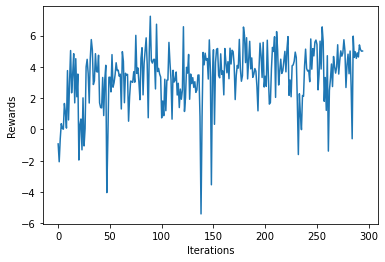

 30%|██████████████████████▏                                                    | 29604/100000 [20:54<42:41, 27.48it/s]

Updated Weights
Mean Reward = 4.9
24


 30%|██████████████████████▎                                                    | 29706/100000 [20:58<45:25, 25.79it/s]

Updated Weights
Mean Reward = 3.29
23


 30%|██████████████████████▎                                                    | 29804/100000 [21:02<41:36, 28.12it/s]

Updated Weights
Mean Reward = 4.76
26


 30%|██████████████████████▍                                                    | 29904/100000 [21:05<44:21, 26.34it/s]

Updated Weights
Mean Reward = 4.18
24


 30%|██████████████████████▌                                                    | 30000/100000 [21:09<41:35, 28.05it/s]

Updated Weights
Mean Reward = 3.97
27


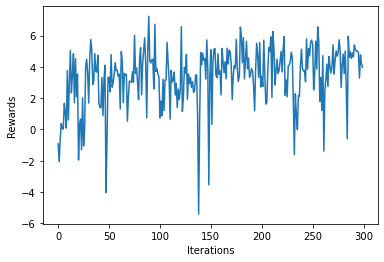

 30%|██████████████████████▌                                                    | 30106/100000 [21:13<45:01, 25.87it/s]

Updated Weights
Mean Reward = 4.18
21


 30%|██████████████████████▋                                                    | 30206/100000 [21:17<39:52, 29.17it/s]

Updated Weights
Mean Reward = 2.63
19


 30%|██████████████████████▋                                                    | 30306/100000 [21:21<42:21, 27.42it/s]

Updated Weights
Mean Reward = 4.35
23


 30%|██████████████████████▊                                                    | 30405/100000 [21:24<43:41, 26.54it/s]

Updated Weights
Mean Reward = 4.26
24


 30%|██████████████████████▊                                                    | 30498/100000 [21:28<43:28, 26.64it/s]

Updated Weights
Mean Reward = 3.18
24


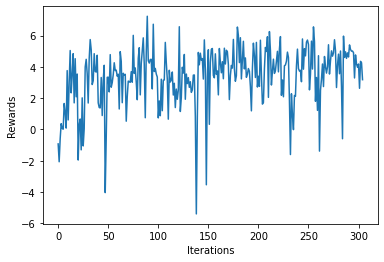

 31%|██████████████████████▉                                                    | 30603/100000 [21:32<35:25, 32.65it/s]

Updated Weights
Mean Reward = 3.75
23


 31%|███████████████████████                                                    | 30705/100000 [21:36<42:28, 27.19it/s]

Updated Weights
Mean Reward = 3.34
20


 31%|███████████████████████                                                    | 30804/100000 [21:39<43:36, 26.45it/s]

Updated Weights
Mean Reward = 4.29
34


 31%|███████████████████████▏                                                   | 30903/100000 [21:43<42:52, 26.86it/s]

Updated Weights
Mean Reward = 1.79
15


 31%|███████████████████████▏                                                   | 30998/100000 [21:46<44:57, 25.58it/s]

Updated Weights
Mean Reward = 4.01
27


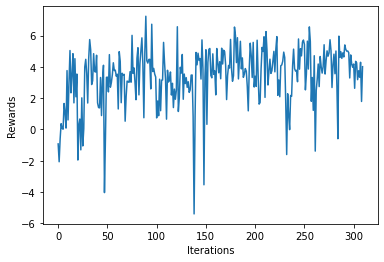

 31%|███████████████████████▎                                                   | 31104/100000 [21:50<41:18, 27.80it/s]

Updated Weights
Mean Reward = 4.73
33


 31%|███████████████████████▍                                                   | 31204/100000 [21:54<47:05, 24.35it/s]

Updated Weights
Mean Reward = 4.36
30


 31%|███████████████████████▍                                                   | 31305/100000 [21:58<45:02, 25.42it/s]

Updated Weights
Mean Reward = 3.42
26


 31%|███████████████████████▌                                                   | 31404/100000 [22:01<46:31, 24.57it/s]

Updated Weights
Mean Reward = 5.27
26


 32%|███████████████████████▋                                                   | 31500/100000 [22:05<43:47, 26.07it/s]

Updated Weights
Mean Reward = 4.15
23


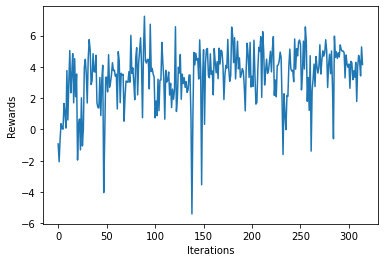

 32%|███████████████████████▋                                                   | 31603/100000 [22:08<40:33, 28.11it/s]

Updated Weights
Mean Reward = 5.1
30


 32%|███████████████████████▊                                                   | 31703/100000 [22:12<47:10, 24.13it/s]

Updated Weights
Mean Reward = 3.17
21


 32%|███████████████████████▊                                                   | 31806/100000 [22:16<42:40, 26.63it/s]

Updated Weights
Mean Reward = 3.1
19


 32%|███████████████████████▉                                                   | 31904/100000 [22:20<42:21, 26.80it/s]

Updated Weights
Mean Reward = 3.15
25


 32%|███████████████████████▉                                                   | 31999/100000 [22:23<40:17, 28.13it/s]

Updated Weights
Mean Reward = 3.76
17


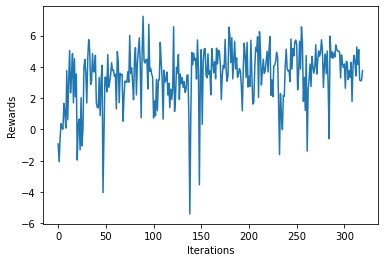

 32%|████████████████████████                                                   | 32104/100000 [22:27<43:24, 26.07it/s]

Updated Weights
Mean Reward = 4.8
24


 32%|████████████████████████▏                                                  | 32202/100000 [22:31<46:11, 24.46it/s]

Updated Weights
Mean Reward = 1.52
14


 32%|████████████████████████▏                                                  | 32305/100000 [22:35<47:48, 23.60it/s]

Updated Weights
Mean Reward = 3.54
18


 32%|████████████████████████▎                                                  | 32405/100000 [22:39<40:56, 27.51it/s]

Updated Weights
Mean Reward = 3.06
17


 32%|████████████████████████▎                                                  | 32498/100000 [22:42<45:44, 24.60it/s]

Updated Weights
Mean Reward = 4.28
26


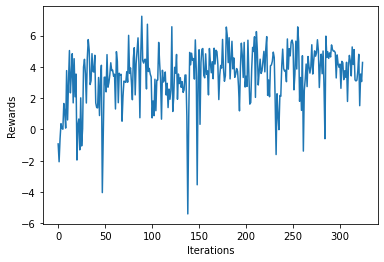

 33%|████████████████████████▍                                                  | 32604/100000 [22:46<47:38, 23.58it/s]

Updated Weights
Mean Reward = 4.21
23


 33%|████████████████████████▌                                                  | 32707/100000 [22:50<42:07, 26.62it/s]

Updated Weights
Mean Reward = 3.91
19


 33%|████████████████████████▌                                                  | 32806/100000 [22:54<42:25, 26.40it/s]

Updated Weights
Mean Reward = 1.96
17


 33%|████████████████████████▋                                                  | 32904/100000 [22:58<41:32, 26.92it/s]

Updated Weights
Mean Reward = 4.37
30


 33%|████████████████████████▊                                                  | 33000/100000 [23:01<43:33, 25.63it/s]

Updated Weights
Mean Reward = 3.83
22


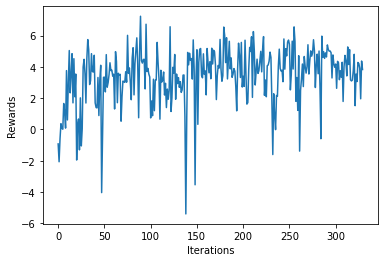

 33%|████████████████████████▊                                                  | 33103/100000 [23:05<36:33, 30.50it/s]

Updated Weights
Mean Reward = 3.38
32


 33%|████████████████████████▉                                                  | 33204/100000 [23:09<41:59, 26.52it/s]

Updated Weights
Mean Reward = 5.77
27


 33%|████████████████████████▉                                                  | 33303/100000 [23:12<38:04, 29.20it/s]

Updated Weights
Mean Reward = 6.09
35


 33%|█████████████████████████                                                  | 33405/100000 [23:16<38:11, 29.06it/s]

Updated Weights
Mean Reward = 3.7
20


 33%|█████████████████████████                                                  | 33498/100000 [23:19<44:01, 25.18it/s]

Updated Weights
Mean Reward = 3.61
20


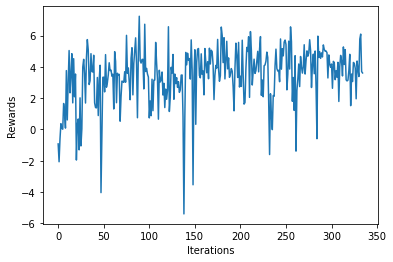

 34%|█████████████████████████▏                                                 | 33605/100000 [23:24<44:23, 24.93it/s]

Updated Weights
Mean Reward = 3.21
19


 34%|█████████████████████████▎                                                 | 33705/100000 [23:27<38:56, 28.37it/s]

Updated Weights
Mean Reward = 3.99
25


 34%|█████████████████████████▎                                                 | 33803/100000 [23:31<44:02, 25.05it/s]

Updated Weights
Mean Reward = 3.5
20


 34%|█████████████████████████▍                                                 | 33904/100000 [23:34<38:25, 28.66it/s]

Updated Weights
Mean Reward = 3.64
29


 34%|█████████████████████████▍                                                 | 33997/100000 [23:38<35:38, 30.86it/s]

Updated Weights
Mean Reward = 3.86
28


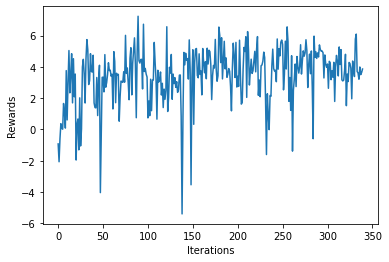

 34%|█████████████████████████▌                                                 | 34103/100000 [23:42<40:22, 27.21it/s]

Updated Weights
Mean Reward = 3.36
26


 34%|█████████████████████████▋                                                 | 34206/100000 [23:46<39:44, 27.59it/s]

Updated Weights
Mean Reward = 4.02
22


 34%|█████████████████████████▋                                                 | 34303/100000 [23:49<46:13, 23.69it/s]

Updated Weights
Mean Reward = 3.5
19


 34%|█████████████████████████▊                                                 | 34403/100000 [23:53<41:28, 26.36it/s]

Updated Weights
Mean Reward = 2.05
15


 34%|█████████████████████████▊                                                 | 34499/100000 [23:57<40:31, 26.94it/s]

Updated Weights
Mean Reward = 1.35
17


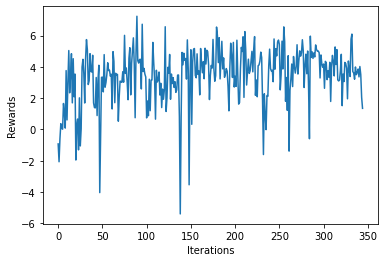

 35%|█████████████████████████▉                                                 | 34605/100000 [24:01<43:05, 25.30it/s]

Updated Weights
Mean Reward = 2.94
22


 35%|██████████████████████████                                                 | 34704/100000 [24:05<42:17, 25.73it/s]

Updated Weights
Mean Reward = 3.97
15


 35%|██████████████████████████                                                 | 34805/100000 [24:08<34:52, 31.16it/s]

Updated Weights
Mean Reward = 6.37
27


 35%|██████████████████████████▏                                                | 34903/100000 [24:12<46:05, 23.54it/s]

Updated Weights
Mean Reward = 5.52
26


 35%|██████████████████████████▏                                                | 34997/100000 [24:16<36:22, 29.78it/s]

Updated Weights
Mean Reward = 7.11
37


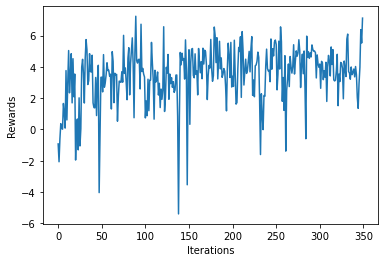

 35%|██████████████████████████▎                                                | 35106/100000 [24:20<42:27, 25.47it/s]

Updated Weights
Mean Reward = 5.94
25


 35%|██████████████████████████▍                                                | 35203/100000 [24:24<49:08, 21.98it/s]

Updated Weights
Mean Reward = 5.79
24


 35%|██████████████████████████▍                                                | 35302/100000 [24:28<50:44, 21.25it/s]

Updated Weights
Mean Reward = 2.77
14


 35%|██████████████████████████▌                                                | 35405/100000 [24:33<42:37, 25.26it/s]

Updated Weights
Mean Reward = 5.03
18


 35%|██████████████████████████▌                                                | 35499/100000 [24:37<41:45, 25.74it/s]

Updated Weights
Mean Reward = 5.53
23


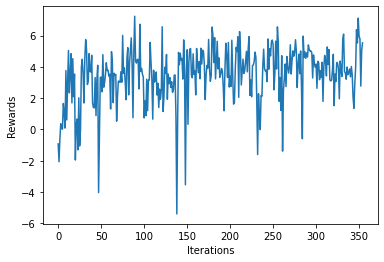

 36%|██████████████████████████▋                                                | 35602/100000 [24:41<45:05, 23.80it/s]

Updated Weights
Mean Reward = 5.53
28


 36%|██████████████████████████▊                                                | 35702/100000 [24:45<49:38, 21.59it/s]

Updated Weights
Mean Reward = 3.61
13


 36%|██████████████████████████▊                                                | 35804/100000 [24:50<46:05, 23.21it/s]

Updated Weights
Mean Reward = 3.92
17


 36%|██████████████████████████▉                                                | 35902/100000 [24:54<49:53, 21.41it/s]

Updated Weights
Mean Reward = 4.6
15


 36%|███████████████████████████                                                | 36000/100000 [24:59<49:25, 21.58it/s]

Updated Weights
Mean Reward = 2.35
11


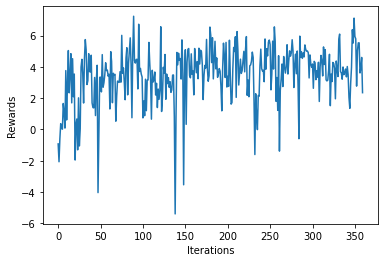

 36%|███████████████████████████                                                | 36103/100000 [25:04<53:01, 20.08it/s]

Updated Weights
Mean Reward = 1.65
14


 36%|███████████████████████████▏                                               | 36202/100000 [25:09<42:21, 25.10it/s]

Updated Weights
Mean Reward = 1.98
15


 36%|███████████████████████████▏                                               | 36302/100000 [25:14<51:13, 20.73it/s]

Updated Weights
Mean Reward = 2.98
11


 36%|███████████████████████████▎                                               | 36403/100000 [25:18<49:20, 21.48it/s]

Updated Weights
Mean Reward = -2.33
28


 36%|███████████████████████████▎                                               | 36499/100000 [25:23<52:00, 20.35it/s]

Updated Weights
Mean Reward = 3.91
25


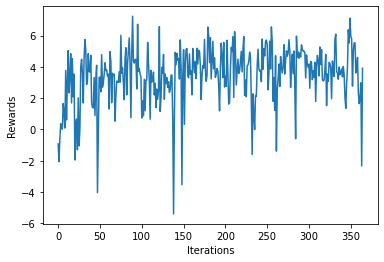

 37%|███████████████████████████▍                                               | 36604/100000 [25:28<38:00, 27.80it/s]

Updated Weights
Mean Reward = 7.33
32


 37%|███████████████████████████▌                                               | 36704/100000 [25:32<52:21, 20.15it/s]

Updated Weights
Mean Reward = 1.58
21


 37%|███████████████████████████▌                                               | 36804/100000 [25:37<54:02, 19.49it/s]

Updated Weights
Mean Reward = 3.5
8


 37%|███████████████████████████▋                                               | 36904/100000 [25:42<55:32, 18.93it/s]

Updated Weights
Mean Reward = 2.55
7


 37%|███████████████████████████▋                                               | 36998/100000 [25:47<51:02, 20.57it/s]

Updated Weights
Mean Reward = 4.95
19


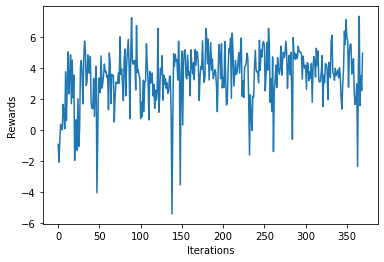

 37%|███████████████████████████▊                                               | 37103/100000 [25:52<46:20, 22.62it/s]

Updated Weights
Mean Reward = 6.18
24


 37%|███████████████████████████▉                                               | 37205/100000 [25:56<47:26, 22.06it/s]

Updated Weights
Mean Reward = 5.75
23


 37%|███████████████████████████▉                                               | 37302/100000 [26:01<46:57, 22.25it/s]

Updated Weights
Mean Reward = 4.77
22


 37%|████████████████████████████                                               | 37403/100000 [26:05<45:56, 22.71it/s]

Updated Weights
Mean Reward = 6.01
27


 38%|████████████████████████████▏                                              | 37500/100000 [26:09<47:59, 21.70it/s]

Updated Weights
Mean Reward = 5.75
29


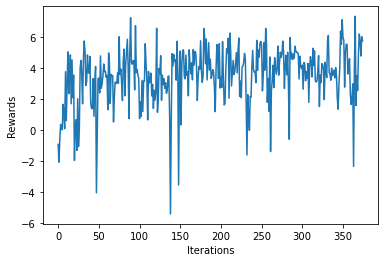

 38%|████████████████████████████▏                                              | 37603/100000 [26:14<52:23, 19.85it/s]

Updated Weights
Mean Reward = 2.66
20


 38%|████████████████████████████▎                                              | 37704/100000 [26:19<54:26, 19.07it/s]

Updated Weights
Mean Reward = 1.6
13


 38%|████████████████████████████▎                                              | 37804/100000 [26:23<48:28, 21.38it/s]

Updated Weights
Mean Reward = 4.67
20


 38%|████████████████████████████▍                                              | 37904/100000 [26:28<47:18, 21.88it/s]

Updated Weights
Mean Reward = 5.84
25


 38%|████████████████████████████▍                                              | 37999/100000 [26:32<48:33, 21.28it/s]

Updated Weights
Mean Reward = 5.39
28


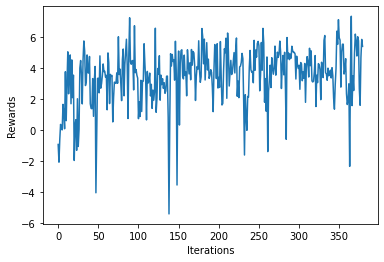

 38%|████████████████████████████▌                                              | 38105/100000 [26:37<46:08, 22.35it/s]

Updated Weights
Mean Reward = 5.53
27


 38%|████████████████████████████▋                                              | 38205/100000 [26:41<41:19, 24.93it/s]

Updated Weights
Mean Reward = 6.36
26


 38%|████████████████████████████▋                                              | 38303/100000 [26:46<51:28, 19.98it/s]

Updated Weights
Mean Reward = 3.24
15


 38%|████████████████████████████▊                                              | 38403/100000 [26:51<48:46, 21.05it/s]

Updated Weights
Mean Reward = 4.78
17


 38%|████████████████████████████▉                                              | 38500/100000 [26:55<37:36, 27.26it/s]

Updated Weights
Mean Reward = 7.34
31


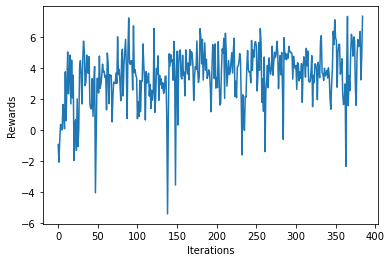

 39%|████████████████████████████▉                                              | 38605/100000 [27:00<41:01, 24.95it/s]

Updated Weights
Mean Reward = 6.65
23


 39%|█████████████████████████████                                              | 38704/100000 [27:04<45:33, 22.43it/s]

Updated Weights
Mean Reward = 5.77
25


 39%|█████████████████████████████                                              | 38803/100000 [27:09<47:36, 21.42it/s]

Updated Weights
Mean Reward = 3.78
20


 39%|█████████████████████████████▏                                             | 38902/100000 [27:13<41:56, 24.28it/s]

Updated Weights
Mean Reward = 5.75
32


 39%|█████████████████████████████▏                                             | 38998/100000 [27:17<49:13, 20.65it/s]

Updated Weights
Mean Reward = 2.5
18


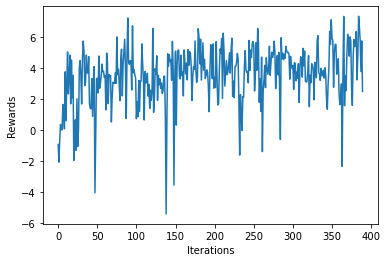

 39%|█████████████████████████████▎                                             | 39104/100000 [27:22<47:57, 21.16it/s]

Updated Weights
Mean Reward = 4.24
26


 39%|█████████████████████████████▍                                             | 39202/100000 [27:27<52:03, 19.46it/s]

Updated Weights
Mean Reward = 4.21
20


 39%|█████████████████████████████▍                                             | 39304/100000 [27:32<49:15, 20.53it/s]

Updated Weights
Mean Reward = 5.09
19


 39%|█████████████████████████████▌                                             | 39402/100000 [27:36<47:20, 21.34it/s]

Updated Weights
Mean Reward = 5.96
21


 39%|█████████████████████████████▌                                             | 39499/100000 [27:41<43:45, 23.04it/s]

Updated Weights
Mean Reward = 6.27
23


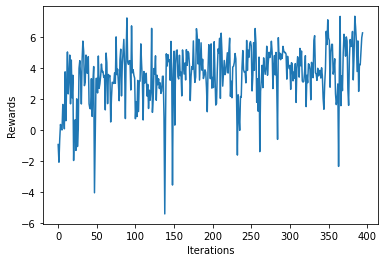

 40%|█████████████████████████████▋                                             | 39603/100000 [27:45<43:54, 22.92it/s]

Updated Weights
Mean Reward = 5.14
24


 40%|█████████████████████████████▊                                             | 39704/100000 [27:50<49:03, 20.49it/s]

Updated Weights
Mean Reward = 6.61
32


 40%|█████████████████████████████▊                                             | 39803/100000 [27:54<48:39, 20.62it/s]

Updated Weights
Mean Reward = 2.27
14


 40%|█████████████████████████████▉                                             | 39902/100000 [27:59<46:11, 21.68it/s]

Updated Weights
Mean Reward = 3.85
23


 40%|██████████████████████████████                                             | 40000/100000 [28:03<46:19, 21.59it/s]

Updated Weights
Mean Reward = 2.5
19


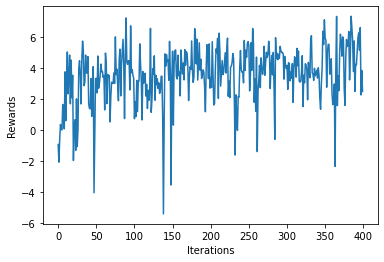

 40%|██████████████████████████████                                             | 40103/100000 [28:08<47:32, 20.99it/s]

Updated Weights
Mean Reward = 5.36
24


 40%|██████████████████████████████▏                                            | 40202/100000 [28:12<40:40, 24.50it/s]

Updated Weights
Mean Reward = 6.34
29


 40%|██████████████████████████████▏                                            | 40302/100000 [28:17<41:26, 24.01it/s]

Updated Weights
Mean Reward = 7.33
31


 40%|██████████████████████████████▎                                            | 40403/100000 [28:21<33:11, 29.93it/s]

Updated Weights
Mean Reward = 7.08
33


 40%|██████████████████████████████▎                                            | 40499/100000 [28:25<45:50, 21.64it/s]

Updated Weights
Mean Reward = 5.46
22


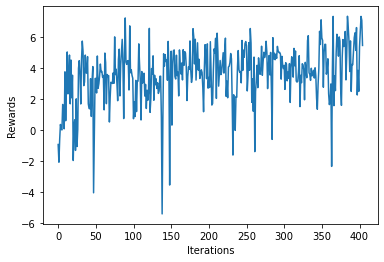

 41%|██████████████████████████████▍                                            | 40604/100000 [28:29<46:21, 21.36it/s]

Updated Weights
Mean Reward = 3.39
13


 41%|██████████████████████████████▌                                            | 40706/100000 [28:34<38:15, 25.84it/s]

Updated Weights
Mean Reward = 5.64
24


 41%|██████████████████████████████▌                                            | 40806/100000 [28:37<36:27, 27.07it/s]

Updated Weights
Mean Reward = 7.43
30


 41%|██████████████████████████████▋                                            | 40906/100000 [28:41<33:39, 29.26it/s]

Updated Weights
Mean Reward = 5.96
24


 41%|██████████████████████████████▋                                            | 40998/100000 [28:44<36:13, 27.15it/s]

Updated Weights
Mean Reward = 6.57
22


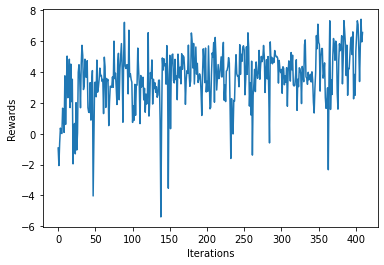

 41%|██████████████████████████████▊                                            | 41105/100000 [28:48<37:23, 26.26it/s]

Updated Weights
Mean Reward = 6.26
30


 41%|██████████████████████████████▉                                            | 41203/100000 [28:52<36:41, 26.71it/s]

Updated Weights
Mean Reward = 6.38
33


 41%|██████████████████████████████▉                                            | 41305/100000 [28:55<38:33, 25.37it/s]

Updated Weights
Mean Reward = 5.65
29


 41%|███████████████████████████████                                            | 41404/100000 [29:00<45:23, 21.52it/s]

Updated Weights
Mean Reward = 3.54
20


 41%|███████████████████████████████                                            | 41497/100000 [29:04<49:23, 19.74it/s]

Updated Weights
Mean Reward = 5.2
21


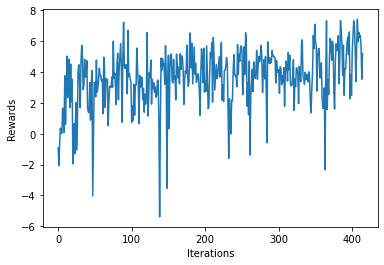

 42%|███████████████████████████████▏                                           | 41603/100000 [29:10<52:04, 18.69it/s]

Updated Weights
Mean Reward = 6.61
22


 42%|███████████████████████████████▎                                           | 41702/100000 [29:14<46:16, 21.00it/s]

Updated Weights
Mean Reward = 7.9
44


 42%|███████████████████████████████▎                                           | 41805/100000 [29:18<37:49, 25.64it/s]

Updated Weights
Mean Reward = 7.23
35


 42%|███████████████████████████████▍                                           | 41905/100000 [29:22<42:14, 22.92it/s]

Updated Weights
Mean Reward = 4.73
40


 42%|███████████████████████████████▍                                           | 41998/100000 [29:26<41:32, 23.27it/s]

Updated Weights
Mean Reward = 6.75
34


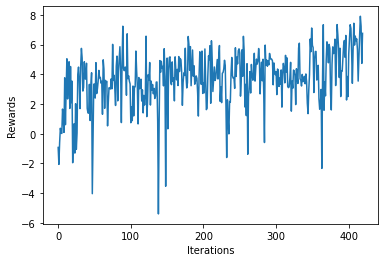

 42%|███████████████████████████████▌                                           | 42104/100000 [29:30<42:40, 22.61it/s]

Updated Weights
Mean Reward = 6.62
39


 42%|███████████████████████████████▋                                           | 42204/100000 [29:34<35:47, 26.91it/s]

Updated Weights
Mean Reward = 6.23
35


 42%|███████████████████████████████▋                                           | 42306/100000 [29:37<33:16, 28.90it/s]

Updated Weights
Mean Reward = 3.62
24


 42%|███████████████████████████████▊                                           | 42405/100000 [29:41<33:21, 28.77it/s]

Updated Weights
Mean Reward = 5.13
25


 42%|███████████████████████████████▊                                           | 42499/100000 [29:45<38:02, 25.20it/s]

Updated Weights
Mean Reward = 5.53
27


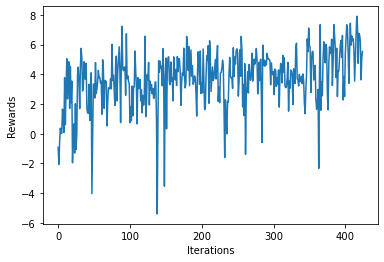

 43%|███████████████████████████████▉                                           | 42605/100000 [29:48<33:40, 28.41it/s]

Updated Weights
Mean Reward = 7.13
36


 43%|████████████████████████████████                                           | 42703/100000 [29:52<39:56, 23.91it/s]

Updated Weights
Mean Reward = 4.6
21


 43%|████████████████████████████████                                           | 42804/100000 [29:55<33:07, 28.77it/s]

Updated Weights
Mean Reward = 5.57
42


 43%|████████████████████████████████▏                                          | 42906/100000 [29:59<32:40, 29.13it/s]

Updated Weights
Mean Reward = 6.91
37


 43%|████████████████████████████████▏                                          | 42998/100000 [30:01<27:38, 34.38it/s]

Updated Weights
Mean Reward = 6.41
48


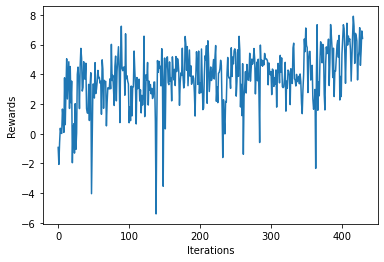

 43%|████████████████████████████████▎                                          | 43103/100000 [30:06<40:40, 23.31it/s]

Updated Weights
Mean Reward = 4.47
25


 43%|████████████████████████████████▍                                          | 43204/100000 [30:09<32:08, 29.46it/s]

Updated Weights
Mean Reward = 4.36
29


 43%|████████████████████████████████▍                                          | 43304/100000 [30:12<33:10, 28.49it/s]

Updated Weights
Mean Reward = 5.35
45


 43%|████████████████████████████████▌                                          | 43404/100000 [30:16<35:08, 26.84it/s]

Updated Weights
Mean Reward = 4.48
25


 43%|████████████████████████████████▌                                          | 43497/100000 [30:19<30:45, 30.61it/s]

Updated Weights
Mean Reward = 7.33
41


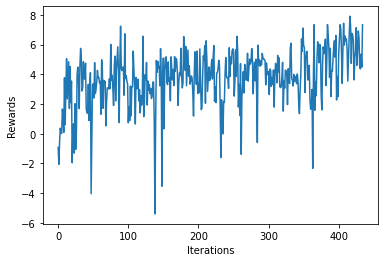

 44%|████████████████████████████████▋                                          | 43604/100000 [30:22<34:22, 27.35it/s]

Updated Weights
Mean Reward = 7.95
39


 44%|████████████████████████████████▊                                          | 43704/100000 [30:26<34:23, 27.28it/s]

Updated Weights
Mean Reward = 6.01
28


 44%|████████████████████████████████▊                                          | 43805/100000 [30:30<35:03, 26.72it/s]

Updated Weights
Mean Reward = 6.12
34


 44%|████████████████████████████████▉                                          | 43902/100000 [30:33<42:26, 22.03it/s]

Updated Weights
Mean Reward = 4.61
25


 44%|████████████████████████████████▉                                          | 43998/100000 [30:37<36:40, 25.45it/s]

Updated Weights
Mean Reward = 3.38
34


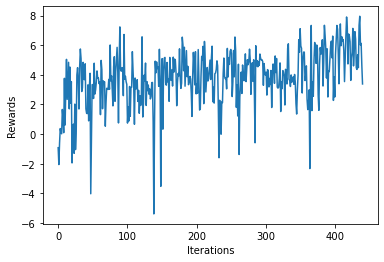

 44%|█████████████████████████████████                                          | 44106/100000 [30:41<31:57, 29.15it/s]

Updated Weights
Mean Reward = 7.3
36


 44%|█████████████████████████████████▏                                         | 44202/100000 [30:44<35:27, 26.23it/s]

Updated Weights
Mean Reward = 5.25
28


 44%|█████████████████████████████████▏                                         | 44305/100000 [30:48<31:40, 29.30it/s]

Updated Weights
Mean Reward = 7.06
33


 44%|█████████████████████████████████▎                                         | 44406/100000 [30:52<30:19, 30.55it/s]

Updated Weights
Mean Reward = 5.99
27


 44%|█████████████████████████████████▎                                         | 44497/100000 [30:55<32:13, 28.71it/s]

Updated Weights
Mean Reward = 7.16
37


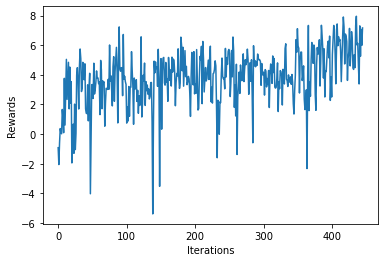

 45%|█████████████████████████████████▍                                         | 44605/100000 [30:59<30:04, 30.69it/s]

Updated Weights
Mean Reward = 6.27
35


 45%|█████████████████████████████████▌                                         | 44706/100000 [31:02<29:40, 31.05it/s]

Updated Weights
Mean Reward = 7.57
40


 45%|█████████████████████████████████▌                                         | 44805/100000 [31:05<34:09, 26.94it/s]

Updated Weights
Mean Reward = 5.28
37


 45%|█████████████████████████████████▋                                         | 44903/100000 [31:09<37:58, 24.18it/s]

Updated Weights
Mean Reward = -0.01
19


 45%|█████████████████████████████████▋                                         | 44998/100000 [31:13<40:46, 22.48it/s]

Updated Weights
Mean Reward = 0.96
14


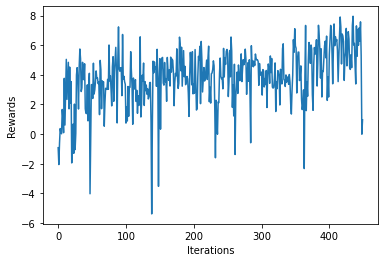

 45%|█████████████████████████████████▊                                         | 45103/100000 [31:17<34:19, 26.65it/s]

Updated Weights
Mean Reward = 1.02
21


 45%|█████████████████████████████████▉                                         | 45205/100000 [31:21<36:37, 24.93it/s]

Updated Weights
Mean Reward = 2.96
10


 45%|█████████████████████████████████▉                                         | 45303/100000 [31:25<35:32, 25.64it/s]

Updated Weights
Mean Reward = 4.64
18


 45%|██████████████████████████████████                                         | 45403/100000 [31:29<34:30, 26.37it/s]

Updated Weights
Mean Reward = 4.91
19


 46%|██████████████████████████████████▏                                        | 45500/100000 [31:32<34:45, 26.14it/s]

Updated Weights
Mean Reward = 5.93
20


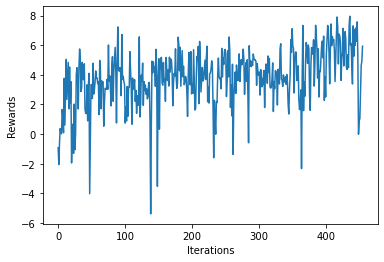

 46%|██████████████████████████████████▏                                        | 45604/100000 [31:36<36:52, 24.58it/s]

Updated Weights
Mean Reward = 6.19
22


 46%|██████████████████████████████████▎                                        | 45705/100000 [31:40<26:13, 34.51it/s]

Updated Weights
Mean Reward = 7.69
31


 46%|██████████████████████████████████▎                                        | 45805/100000 [31:43<34:43, 26.01it/s]

Updated Weights
Mean Reward = 6.51
28


 46%|██████████████████████████████████▍                                        | 45904/100000 [31:47<35:48, 25.18it/s]

Updated Weights
Mean Reward = 6.81
30


 46%|██████████████████████████████████▌                                        | 46000/100000 [31:50<27:05, 33.22it/s]

Updated Weights
Mean Reward = 7.03
43


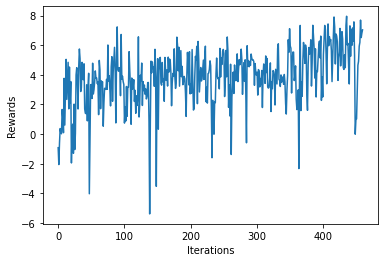

 46%|██████████████████████████████████▌                                        | 46105/100000 [31:54<30:43, 29.24it/s]

Updated Weights
Mean Reward = 4.12
26


 46%|██████████████████████████████████▋                                        | 46204/100000 [31:57<35:56, 24.94it/s]

Updated Weights
Mean Reward = 6.25
30


 46%|██████████████████████████████████▋                                        | 46304/100000 [32:01<35:23, 25.29it/s]

Updated Weights
Mean Reward = 7.18
29


 46%|██████████████████████████████████▊                                        | 46404/100000 [32:04<30:36, 29.18it/s]

Updated Weights
Mean Reward = 7.04
38


 46%|██████████████████████████████████▊                                        | 46497/100000 [32:08<36:11, 24.64it/s]

Updated Weights
Mean Reward = 5.82
28


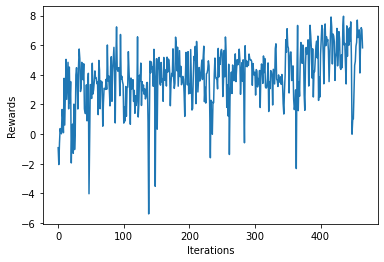

 47%|██████████████████████████████████▉                                        | 46606/100000 [32:11<31:32, 28.22it/s]

Updated Weights
Mean Reward = 6.56
48


 47%|███████████████████████████████████                                        | 46705/100000 [32:14<27:42, 32.05it/s]

Updated Weights
Mean Reward = 6.74
44


 47%|███████████████████████████████████                                        | 46804/100000 [32:18<33:36, 26.38it/s]

Updated Weights
Mean Reward = 5.66
28


 47%|███████████████████████████████████▏                                       | 46905/100000 [32:21<28:29, 31.05it/s]

Updated Weights
Mean Reward = 3.36
25


 47%|███████████████████████████████████▎                                       | 47000/100000 [32:25<32:15, 27.38it/s]

Updated Weights
Mean Reward = 6.21
31


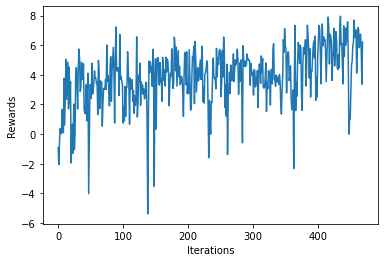

 47%|███████████████████████████████████▎                                       | 47104/100000 [32:28<27:02, 32.61it/s]

Updated Weights
Mean Reward = 7.0
36


 47%|███████████████████████████████████▍                                       | 47203/100000 [32:32<29:37, 29.70it/s]

Updated Weights
Mean Reward = 5.93
31


 47%|███████████████████████████████████▍                                       | 47305/100000 [32:35<32:59, 26.62it/s]

Updated Weights
Mean Reward = 6.98
33


 47%|███████████████████████████████████▌                                       | 47405/100000 [32:39<29:08, 30.08it/s]

Updated Weights
Mean Reward = 5.77
27


 47%|███████████████████████████████████▌                                       | 47497/100000 [32:42<34:06, 25.66it/s]

Updated Weights
Mean Reward = 7.52
46


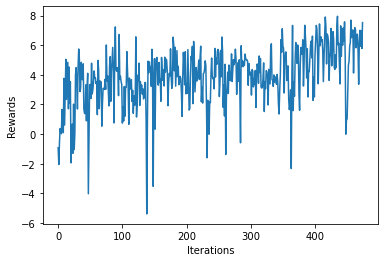

 48%|███████████████████████████████████▋                                       | 47604/100000 [32:46<30:01, 29.08it/s]

Updated Weights
Mean Reward = 5.18
25


 48%|███████████████████████████████████▊                                       | 47704/100000 [32:49<25:17, 34.46it/s]

Updated Weights
Mean Reward = 6.87
34


 48%|███████████████████████████████████▊                                       | 47805/100000 [32:53<35:36, 24.42it/s]

Updated Weights
Mean Reward = 4.76
23


 48%|███████████████████████████████████▉                                       | 47906/100000 [32:57<32:08, 27.02it/s]

Updated Weights
Mean Reward = 6.53
24


 48%|████████████████████████████████████                                       | 48000/100000 [33:00<33:50, 25.62it/s]

Updated Weights
Mean Reward = 5.06
20


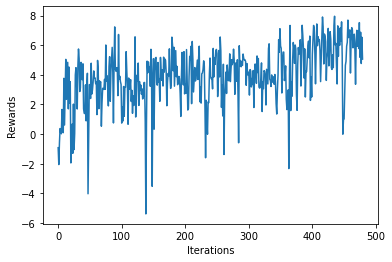

 48%|████████████████████████████████████                                       | 48105/100000 [33:04<32:54, 26.29it/s]

Updated Weights
Mean Reward = 5.34
27


 48%|████████████████████████████████████▏                                      | 48206/100000 [33:08<31:26, 27.45it/s]

Updated Weights
Mean Reward = 6.57
21


 48%|████████████████████████████████████▏                                      | 48307/100000 [33:12<28:16, 30.47it/s]

Updated Weights
Mean Reward = 8.02
34


 48%|████████████████████████████████████▎                                      | 48404/100000 [33:15<35:34, 24.17it/s]

Updated Weights
Mean Reward = 5.89
21


 48%|████████████████████████████████████▎                                      | 48497/100000 [33:19<27:23, 31.34it/s]

Updated Weights
Mean Reward = 9.69
43


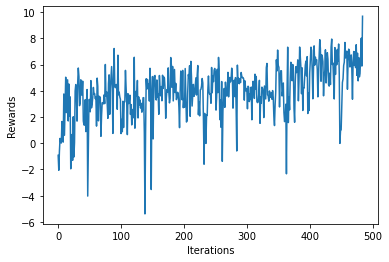

 49%|████████████████████████████████████▍                                      | 48604/100000 [33:23<36:09, 23.69it/s]

Updated Weights
Mean Reward = 6.57
20


 49%|████████████████████████████████████▌                                      | 48706/100000 [33:26<25:11, 33.94it/s]

Updated Weights
Mean Reward = 6.37
34


 49%|████████████████████████████████████▌                                      | 48803/100000 [33:29<25:46, 33.10it/s]

Updated Weights
Mean Reward = 6.81
40


 49%|████████████████████████████████████▋                                      | 48904/100000 [33:33<31:25, 27.10it/s]

Updated Weights
Mean Reward = 5.43
34


 49%|████████████████████████████████████▋                                      | 48999/100000 [33:36<27:27, 30.95it/s]

Updated Weights
Mean Reward = 6.35
35


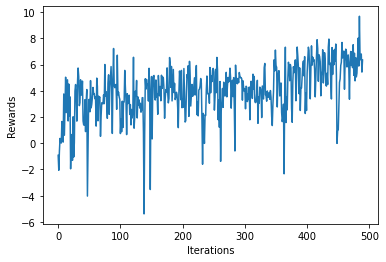

 49%|████████████████████████████████████▊                                      | 49105/100000 [33:40<28:57, 29.30it/s]

Updated Weights
Mean Reward = 5.56
27


 49%|████████████████████████████████████▉                                      | 49203/100000 [33:43<30:35, 27.68it/s]

Updated Weights
Mean Reward = 7.63
41


 49%|████████████████████████████████████▉                                      | 49304/100000 [33:47<30:25, 27.77it/s]

Updated Weights
Mean Reward = 1.89
32


 49%|█████████████████████████████████████                                      | 49404/100000 [33:50<34:27, 24.48it/s]

Updated Weights
Mean Reward = 4.79
18


 49%|█████████████████████████████████████                                      | 49498/100000 [33:54<33:48, 24.90it/s]

Updated Weights
Mean Reward = 4.1
13


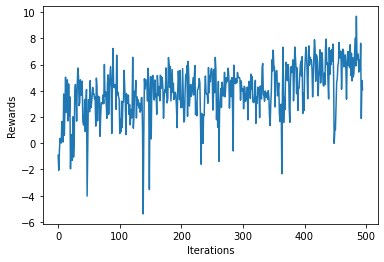

 50%|█████████████████████████████████████▏                                     | 49602/100000 [33:58<25:59, 32.32it/s]

Updated Weights
Mean Reward = 8.31
36


 50%|█████████████████████████████████████▎                                     | 49706/100000 [34:01<28:41, 29.21it/s]

Updated Weights
Mean Reward = 8.46
42


 50%|█████████████████████████████████████▎                                     | 49804/100000 [34:04<26:31, 31.55it/s]

Updated Weights
Mean Reward = 9.76
46


 50%|█████████████████████████████████████▍                                     | 49906/100000 [34:08<32:34, 25.64it/s]

Updated Weights
Mean Reward = 6.59
31


 50%|█████████████████████████████████████▍                                     | 49997/100000 [34:12<28:07, 29.62it/s]

Updated Weights
Mean Reward = 6.11
32


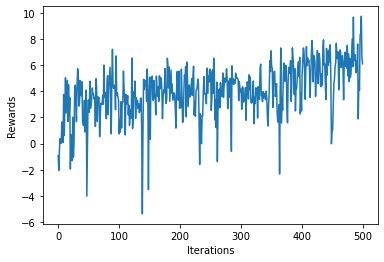

 50%|█████████████████████████████████████▌                                     | 50101/100000 [34:15<26:07, 31.83it/s]

Updated Weights
Mean Reward = 7.68
40


 50%|█████████████████████████████████████▋                                     | 50205/100000 [34:19<33:44, 24.59it/s]

Updated Weights
Mean Reward = 8.79
43


 50%|█████████████████████████████████████▋                                     | 50304/100000 [34:23<33:34, 24.67it/s]

Updated Weights
Mean Reward = 3.33
21


 50%|█████████████████████████████████████▊                                     | 50406/100000 [34:27<29:26, 28.08it/s]

Updated Weights
Mean Reward = 8.6
34


 50%|█████████████████████████████████████▉                                     | 50500/100000 [34:30<28:45, 28.69it/s]

Updated Weights
Mean Reward = 9.73
49


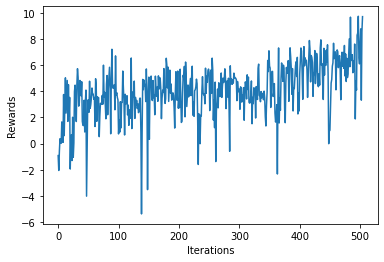

 51%|█████████████████████████████████████▉                                     | 50603/100000 [34:34<33:36, 24.50it/s]

Updated Weights
Mean Reward = 6.7
43


 51%|██████████████████████████████████████                                     | 50705/100000 [34:38<33:16, 24.69it/s]

Updated Weights
Mean Reward = 5.5
23


 51%|██████████████████████████████████████                                     | 50806/100000 [34:42<31:40, 25.88it/s]

Updated Weights
Mean Reward = 8.59
40


 51%|██████████████████████████████████████▏                                    | 50904/100000 [34:46<35:41, 22.93it/s]

Updated Weights
Mean Reward = 6.87
29


 51%|██████████████████████████████████████▎                                    | 51000/100000 [34:50<31:54, 25.60it/s]

Updated Weights
Mean Reward = 7.84
32


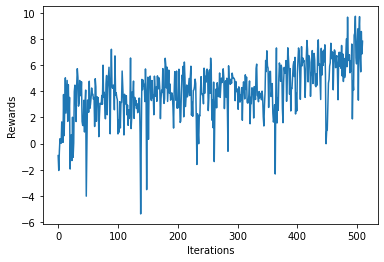

 51%|██████████████████████████████████████▎                                    | 51104/100000 [34:55<34:03, 23.93it/s]

Updated Weights
Mean Reward = 6.03
21


 51%|██████████████████████████████████████▍                                    | 51205/100000 [34:59<32:54, 24.71it/s]

Updated Weights
Mean Reward = 9.58
42


 51%|██████████████████████████████████████▍                                    | 51303/100000 [35:03<38:03, 21.33it/s]

Updated Weights
Mean Reward = 6.33
38


 51%|██████████████████████████████████████▌                                    | 51405/100000 [35:08<38:23, 21.09it/s]

Updated Weights
Mean Reward = 2.74
14


 52%|██████████████████████████████████████▋                                    | 51500/100000 [35:13<41:03, 19.69it/s]

Updated Weights
Mean Reward = 3.9
16


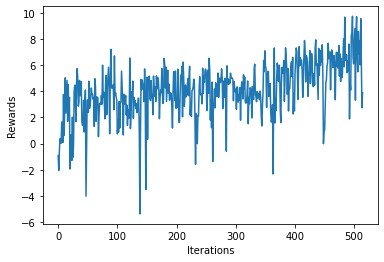

 52%|██████████████████████████████████████▋                                    | 51602/100000 [35:18<36:30, 22.10it/s]

Updated Weights
Mean Reward = 6.1
30


 52%|██████████████████████████████████████▊                                    | 51704/100000 [35:23<31:30, 25.55it/s]

Updated Weights
Mean Reward = 6.33
34


 52%|██████████████████████████████████████▊                                    | 51802/100000 [35:26<34:27, 23.31it/s]

Updated Weights
Mean Reward = 8.88
50


 52%|██████████████████████████████████████▉                                    | 51905/100000 [35:30<29:17, 27.37it/s]

Updated Weights
Mean Reward = 9.75
52


 52%|██████████████████████████████████████▉                                    | 51998/100000 [35:34<42:14, 18.94it/s]

Updated Weights
Mean Reward = 6.25
40


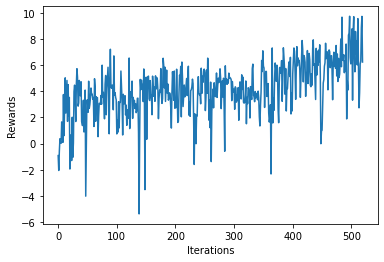

 52%|███████████████████████████████████████                                    | 52102/100000 [35:40<54:22, 14.68it/s]

Updated Weights
Mean Reward = 6.03
36


 52%|███████████████████████████████████████▏                                   | 52203/100000 [35:46<49:33, 16.07it/s]

Updated Weights
Mean Reward = 3.94
15


 52%|███████████████████████████████████████▏                                   | 52305/100000 [35:52<41:00, 19.38it/s]

Updated Weights
Mean Reward = 6.25
32


 52%|███████████████████████████████████████▎                                   | 52404/100000 [35:57<45:23, 17.48it/s]

Updated Weights
Mean Reward = 6.35
39


 52%|███████████████████████████████████████▎                                   | 52499/100000 [36:03<52:18, 15.13it/s]

Updated Weights
Mean Reward = 5.03
20


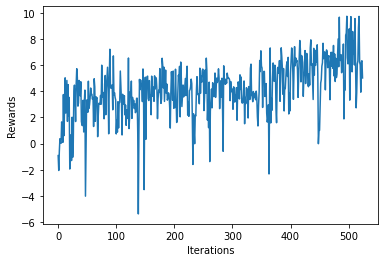

 53%|███████████████████████████████████████▍                                   | 52603/100000 [36:09<40:28, 19.52it/s]

Updated Weights
Mean Reward = 6.98
36


 53%|███████████████████████████████████████▌                                   | 52701/100000 [36:14<35:16, 22.35it/s]

Updated Weights
Mean Reward = 7.38
41


 53%|███████████████████████████████████████▌                                   | 52804/100000 [36:19<34:41, 22.67it/s]

Updated Weights
Mean Reward = 7.51
43


 53%|███████████████████████████████████████▋                                   | 52904/100000 [36:25<36:55, 21.26it/s]

Updated Weights
Mean Reward = 6.33
37


 53%|███████████████████████████████████████▊                                   | 53000/100000 [36:29<31:37, 24.78it/s]

Updated Weights
Mean Reward = 8.62
51


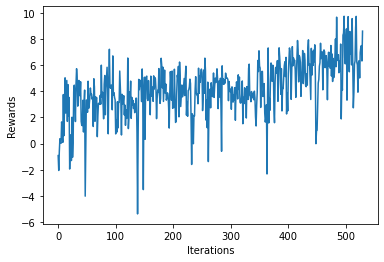

 53%|███████████████████████████████████████▊                                   | 53103/100000 [36:35<49:44, 15.71it/s]

Updated Weights
Mean Reward = 6.72
26


 53%|███████████████████████████████████████▉                                   | 53204/100000 [36:40<33:32, 23.25it/s]

Updated Weights
Mean Reward = 8.12
42


 53%|███████████████████████████████████████▉                                   | 53303/100000 [36:45<44:34, 17.46it/s]

Updated Weights
Mean Reward = 7.99
49


 53%|████████████████████████████████████████                                   | 53402/100000 [36:51<47:34, 16.33it/s]

Updated Weights
Mean Reward = 5.28
26


 53%|████████████████████████████████████████                                   | 53499/100000 [36:56<43:12, 17.93it/s]

Updated Weights
Mean Reward = 4.96
24


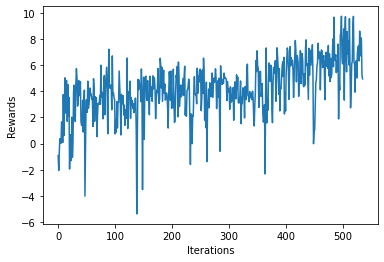

 54%|████████████████████████████████████████▏                                  | 53603/100000 [37:02<44:42, 17.29it/s]

Updated Weights
Mean Reward = 4.74
22


 54%|████████████████████████████████████████▎                                  | 53702/100000 [37:07<43:45, 17.64it/s]

Updated Weights
Mean Reward = 7.77
38


 54%|████████████████████████████████████████▎                                  | 53804/100000 [37:12<35:49, 21.49it/s]

Updated Weights
Mean Reward = 7.53
50


 54%|████████████████████████████████████████▍                                  | 53903/100000 [37:17<44:31, 17.25it/s]

Updated Weights
Mean Reward = 5.92
37


 54%|████████████████████████████████████████▌                                  | 54000/100000 [37:23<50:19, 15.23it/s]

Updated Weights
Mean Reward = 5.03
21


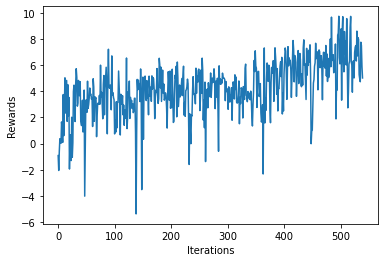

 54%|████████████████████████████████████████▌                                  | 54103/100000 [37:29<47:44, 16.02it/s]

Updated Weights
Mean Reward = 6.23
31


 54%|████████████████████████████████████████▋                                  | 54204/100000 [37:34<42:12, 18.08it/s]

Updated Weights
Mean Reward = 7.2
35


 54%|████████████████████████████████████████▋                                  | 54302/100000 [37:40<41:27, 18.37it/s]

Updated Weights
Mean Reward = 6.74
33


 54%|████████████████████████████████████████▊                                  | 54403/100000 [37:44<36:20, 20.91it/s]

Updated Weights
Mean Reward = 9.15
48


 55%|████████████████████████████████████████▉                                  | 54500/100000 [37:50<44:24, 17.08it/s]

Updated Weights
Mean Reward = 5.4
27


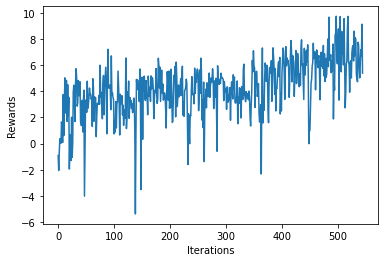

 55%|████████████████████████████████████████▉                                  | 54603/100000 [37:56<47:59, 15.76it/s]

Updated Weights
Mean Reward = 6.8
21


 55%|█████████████████████████████████████████                                  | 54705/100000 [38:01<32:59, 22.88it/s]

Updated Weights
Mean Reward = 8.41
39


 55%|█████████████████████████████████████████                                  | 54802/100000 [38:07<46:52, 16.07it/s]

Updated Weights
Mean Reward = 7.47
36


 55%|█████████████████████████████████████████▏                                 | 54904/100000 [38:12<31:36, 23.78it/s]

Updated Weights
Mean Reward = 5.03
27


 55%|█████████████████████████████████████████▏                                 | 54999/100000 [38:16<32:46, 22.89it/s]

Updated Weights
Mean Reward = 7.59
38


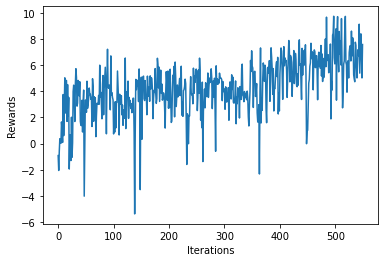

 55%|█████████████████████████████████████████▎                                 | 55102/100000 [38:20<32:53, 22.76it/s]

Updated Weights
Mean Reward = 7.75
47


 55%|█████████████████████████████████████████▍                                 | 55204/100000 [38:25<31:40, 23.57it/s]

Updated Weights
Mean Reward = 7.14
36


 55%|█████████████████████████████████████████▍                                 | 55303/100000 [38:28<26:32, 28.06it/s]

Updated Weights
Mean Reward = 8.8
46


 55%|█████████████████████████████████████████▌                                 | 55404/100000 [38:32<33:20, 22.30it/s]

Updated Weights
Mean Reward = 9.41
46


 56%|█████████████████████████████████████████▋                                 | 55500/100000 [38:36<28:30, 26.01it/s]

Updated Weights
Mean Reward = 9.85
55


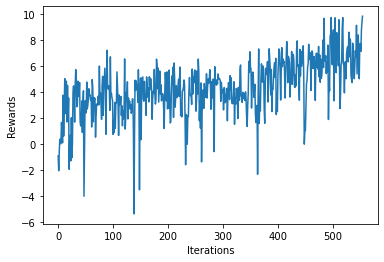

 56%|█████████████████████████████████████████▋                                 | 55605/100000 [38:40<33:17, 22.22it/s]

Updated Weights
Mean Reward = 6.27
45


 56%|█████████████████████████████████████████▊                                 | 55705/100000 [38:44<33:11, 22.24it/s]

Updated Weights
Mean Reward = 6.38
35


 56%|█████████████████████████████████████████▊                                 | 55804/100000 [38:49<39:06, 18.84it/s]

Updated Weights
Mean Reward = 4.47
18


 56%|█████████████████████████████████████████▉                                 | 55904/100000 [38:53<31:19, 23.46it/s]

Updated Weights
Mean Reward = 3.68
16


 56%|█████████████████████████████████████████▉                                 | 55999/100000 [38:57<26:40, 27.49it/s]

Updated Weights
Mean Reward = 7.67
40


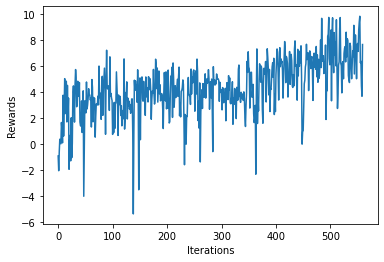

 56%|██████████████████████████████████████████                                 | 56104/100000 [39:01<29:21, 24.92it/s]

Updated Weights
Mean Reward = 6.64
46


 56%|██████████████████████████████████████████▏                                | 56202/100000 [39:05<34:21, 21.25it/s]

Updated Weights
Mean Reward = -10.68
10


 56%|██████████████████████████████████████████▏                                | 56303/100000 [39:09<28:44, 25.33it/s]

Updated Weights
Mean Reward = -7.62
11


 56%|██████████████████████████████████████████▎                                | 56404/100000 [39:14<26:55, 26.99it/s]

Updated Weights
Mean Reward = -1.86
19


 56%|██████████████████████████████████████████▎                                | 56499/100000 [39:18<33:54, 21.39it/s]

Updated Weights
Mean Reward = 2.67
22


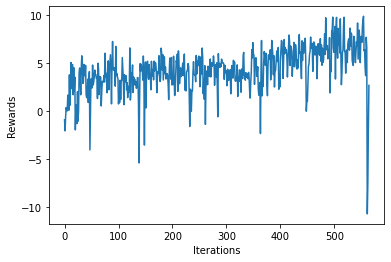

 57%|██████████████████████████████████████████▍                                | 56606/100000 [39:22<24:56, 28.99it/s]

Updated Weights
Mean Reward = 5.23
31


 57%|██████████████████████████████████████████▌                                | 56704/100000 [39:26<26:46, 26.96it/s]

Updated Weights
Mean Reward = 6.54
34


 57%|██████████████████████████████████████████▌                                | 56805/100000 [39:30<26:23, 27.28it/s]

Updated Weights
Mean Reward = 5.25
25


 57%|██████████████████████████████████████████▋                                | 56903/100000 [39:34<27:00, 26.59it/s]

Updated Weights
Mean Reward = 5.38
25


 57%|██████████████████████████████████████████▋                                | 56998/100000 [39:37<26:59, 26.56it/s]

Updated Weights
Mean Reward = 5.55
29


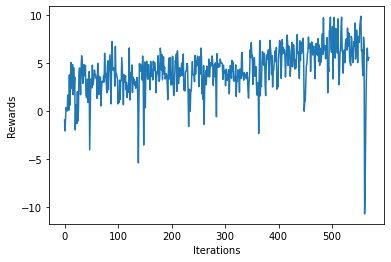

 57%|██████████████████████████████████████████▊                                | 57107/100000 [39:41<22:53, 31.23it/s]

Updated Weights
Mean Reward = 6.85
30


 57%|██████████████████████████████████████████▉                                | 57206/100000 [39:44<22:20, 31.92it/s]

Updated Weights
Mean Reward = 6.04
34


 57%|██████████████████████████████████████████▉                                | 57305/100000 [39:48<25:30, 27.90it/s]

Updated Weights
Mean Reward = 4.56
32


 57%|███████████████████████████████████████████                                | 57404/100000 [39:52<26:34, 26.72it/s]

Updated Weights
Mean Reward = 6.29
30


 57%|███████████████████████████████████████████                                | 57499/100000 [39:55<24:52, 28.48it/s]

Updated Weights
Mean Reward = 6.77
29


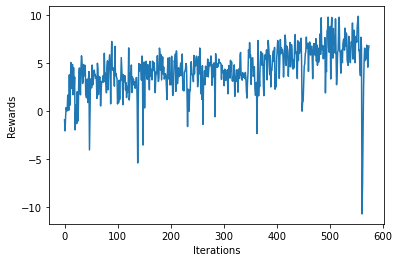

 58%|███████████████████████████████████████████▏                               | 57606/100000 [39:59<23:14, 30.39it/s]

Updated Weights
Mean Reward = 6.12
31


 58%|███████████████████████████████████████████▎                               | 57705/100000 [40:02<24:12, 29.12it/s]

Updated Weights
Mean Reward = 6.42
35


 58%|███████████████████████████████████████████▎                               | 57808/100000 [40:06<19:27, 36.13it/s]

Updated Weights
Mean Reward = 6.88
34


 58%|███████████████████████████████████████████▍                               | 57905/100000 [40:09<23:03, 30.43it/s]

Updated Weights
Mean Reward = 5.38
32


 58%|███████████████████████████████████████████▍                               | 57999/100000 [40:12<22:18, 31.39it/s]

Updated Weights
Mean Reward = 6.68
37


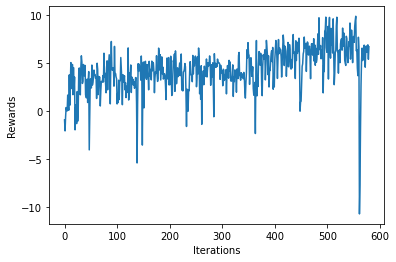

 58%|███████████████████████████████████████████▌                               | 58105/100000 [40:16<22:01, 31.69it/s]

Updated Weights
Mean Reward = 6.44
34


 58%|███████████████████████████████████████████▋                               | 58204/100000 [40:19<25:46, 27.02it/s]

Updated Weights
Mean Reward = 6.17
36


 58%|███████████████████████████████████████████▋                               | 58303/100000 [40:22<27:00, 25.74it/s]

Updated Weights
Mean Reward = 6.11
33


 58%|███████████████████████████████████████████▊                               | 58403/100000 [40:26<24:18, 28.52it/s]

Updated Weights
Mean Reward = 6.24
33


 58%|███████████████████████████████████████████▊                               | 58499/100000 [40:29<20:38, 33.51it/s]

Updated Weights
Mean Reward = 6.84
36


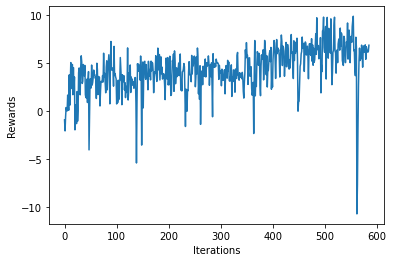

 59%|███████████████████████████████████████████▉                               | 58604/100000 [40:32<22:55, 30.10it/s]

Updated Weights
Mean Reward = 5.29
38


 59%|████████████████████████████████████████████                               | 58705/100000 [40:36<24:34, 28.01it/s]

Updated Weights
Mean Reward = 4.78
31


 59%|████████████████████████████████████████████                               | 58807/100000 [40:39<20:06, 34.13it/s]

Updated Weights
Mean Reward = 5.75
42


 59%|████████████████████████████████████████████▏                              | 58904/100000 [40:42<23:59, 28.54it/s]

Updated Weights
Mean Reward = 6.25
53


 59%|████████████████████████████████████████████▏                              | 58997/100000 [40:46<21:19, 32.05it/s]

Updated Weights
Mean Reward = 3.38
27


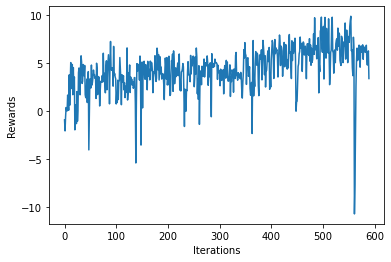

 59%|████████████████████████████████████████████▎                              | 59108/100000 [40:49<19:12, 35.47it/s]

Updated Weights
Mean Reward = 7.21
36


 59%|████████████████████████████████████████████▍                              | 59205/100000 [40:52<23:37, 28.78it/s]

Updated Weights
Mean Reward = 7.09
43


 59%|████████████████████████████████████████████▍                              | 59304/100000 [40:56<23:29, 28.87it/s]

Updated Weights
Mean Reward = 3.76
26


 59%|████████████████████████████████████████████▌                              | 59402/100000 [40:59<21:21, 31.67it/s]

Updated Weights
Mean Reward = 6.57
48


 59%|████████████████████████████████████████████▌                              | 59498/100000 [41:03<25:48, 26.15it/s]

Updated Weights
Mean Reward = 3.8
20


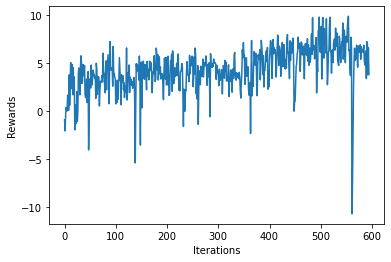

 60%|████████████████████████████████████████████▋                              | 59604/100000 [41:07<28:23, 23.71it/s]

Updated Weights
Mean Reward = 5.96
22


 60%|████████████████████████████████████████████▊                              | 59705/100000 [41:11<25:48, 26.03it/s]

Updated Weights
Mean Reward = 7.17
30


 60%|████████████████████████████████████████████▊                              | 59803/100000 [41:14<27:04, 24.74it/s]

Updated Weights
Mean Reward = 8.5
35


 60%|████████████████████████████████████████████▉                              | 59903/100000 [41:18<22:53, 29.20it/s]

Updated Weights
Mean Reward = 5.69
29


 60%|█████████████████████████████████████████████                              | 60000/100000 [41:21<22:28, 29.66it/s]

Updated Weights
Mean Reward = 8.8
45


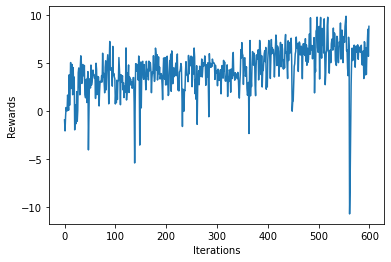

 60%|█████████████████████████████████████████████                              | 60103/100000 [41:24<21:20, 31.15it/s]

Updated Weights
Mean Reward = 8.81
42


 60%|█████████████████████████████████████████████▏                             | 60206/100000 [41:27<17:37, 37.62it/s]

Updated Weights
Mean Reward = 8.25
45


 60%|█████████████████████████████████████████████▏                             | 60305/100000 [41:31<25:46, 25.67it/s]

Updated Weights
Mean Reward = 4.57
30


 60%|█████████████████████████████████████████████▎                             | 60403/100000 [41:35<21:43, 30.38it/s]

Updated Weights
Mean Reward = 5.92
41


 60%|█████████████████████████████████████████████▎                             | 60499/100000 [41:38<22:48, 28.87it/s]

Updated Weights
Mean Reward = 5.13
31


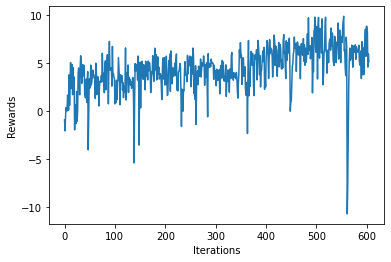

 61%|█████████████████████████████████████████████▍                             | 60603/100000 [41:42<26:06, 25.15it/s]

Updated Weights
Mean Reward = 6.13
31


 61%|█████████████████████████████████████████████▌                             | 60704/100000 [41:46<23:09, 28.27it/s]

Updated Weights
Mean Reward = 7.41
35


 61%|█████████████████████████████████████████████▌                             | 60805/100000 [41:49<21:17, 30.68it/s]

Updated Weights
Mean Reward = 6.77
41


 61%|█████████████████████████████████████████████▋                             | 60905/100000 [41:52<27:14, 23.92it/s]

Updated Weights
Mean Reward = 6.78
36


 61%|█████████████████████████████████████████████▋                             | 60998/100000 [41:56<21:18, 30.51it/s]

Updated Weights
Mean Reward = 5.83
32


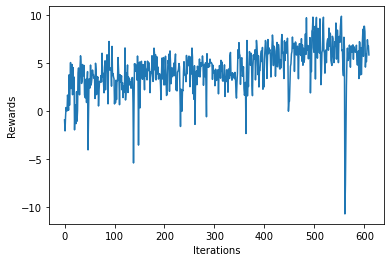

 61%|█████████████████████████████████████████████▊                             | 61106/100000 [41:59<17:34, 36.89it/s]

Updated Weights
Mean Reward = 9.51
56


 61%|█████████████████████████████████████████████▉                             | 61203/100000 [42:02<23:05, 28.00it/s]

Updated Weights
Mean Reward = 2.82
35


 61%|█████████████████████████████████████████████▉                             | 61307/100000 [42:06<20:42, 31.14it/s]

Updated Weights
Mean Reward = 4.56
21


 61%|██████████████████████████████████████████████                             | 61405/100000 [42:10<25:16, 25.45it/s]

Updated Weights
Mean Reward = 5.13
19


 61%|██████████████████████████████████████████████                             | 61498/100000 [42:13<22:00, 29.16it/s]

Updated Weights
Mean Reward = 5.25
22


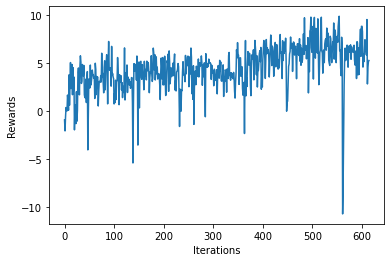

 62%|██████████████████████████████████████████████▏                            | 61604/100000 [42:17<23:58, 26.70it/s]

Updated Weights
Mean Reward = 6.27
25


 62%|██████████████████████████████████████████████▎                            | 61703/100000 [42:21<25:15, 25.26it/s]

Updated Weights
Mean Reward = 5.78
14


 62%|██████████████████████████████████████████████▎                            | 61805/100000 [42:25<20:31, 31.01it/s]

Updated Weights
Mean Reward = 7.4
35


 62%|██████████████████████████████████████████████▍                            | 61910/100000 [42:28<20:09, 31.50it/s]

Updated Weights
Mean Reward = 7.32
35


 62%|██████████████████████████████████████████████▌                            | 62000/100000 [42:31<23:30, 26.95it/s]

Updated Weights
Mean Reward = 6.41
34


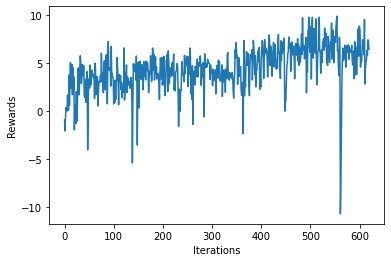

 62%|██████████████████████████████████████████████▌                            | 62104/100000 [42:35<26:07, 24.17it/s]

Updated Weights
Mean Reward = 7.58
33


 62%|██████████████████████████████████████████████▋                            | 62205/100000 [42:39<24:21, 25.86it/s]

Updated Weights
Mean Reward = 6.74
26


 62%|██████████████████████████████████████████████▋                            | 62304/100000 [42:43<22:27, 27.97it/s]

Updated Weights
Mean Reward = 6.83
30


 62%|██████████████████████████████████████████████▊                            | 62404/100000 [42:46<20:28, 30.59it/s]

Updated Weights
Mean Reward = 9.83
48


 62%|██████████████████████████████████████████████▉                            | 62500/100000 [42:49<21:58, 28.44it/s]

Updated Weights
Mean Reward = 6.25
38


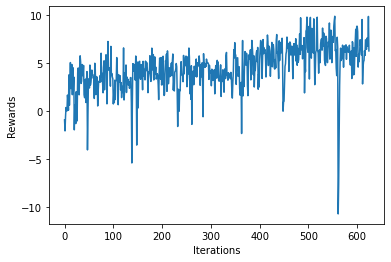

 63%|██████████████████████████████████████████████▉                            | 62604/100000 [42:53<22:14, 28.03it/s]

Updated Weights
Mean Reward = 4.25
32


 63%|███████████████████████████████████████████████                            | 62704/100000 [42:56<25:39, 24.22it/s]

Updated Weights
Mean Reward = 6.5
32


 63%|███████████████████████████████████████████████                            | 62805/100000 [43:00<24:57, 24.84it/s]

Updated Weights
Mean Reward = 7.67
29


 63%|███████████████████████████████████████████████▏                           | 62905/100000 [43:04<21:25, 28.85it/s]

Updated Weights
Mean Reward = 8.59
36


 63%|███████████████████████████████████████████████▎                           | 63000/100000 [43:07<16:22, 37.65it/s]

Updated Weights
Mean Reward = 8.93
49


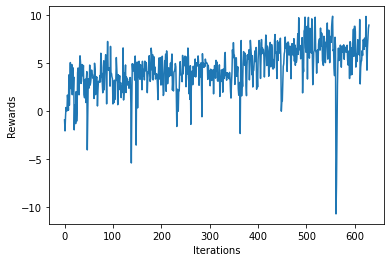

 63%|███████████████████████████████████████████████▎                           | 63105/100000 [43:11<25:33, 24.05it/s]

Updated Weights
Mean Reward = 4.64
23


 63%|███████████████████████████████████████████████▍                           | 63204/100000 [43:14<22:06, 27.74it/s]

Updated Weights
Mean Reward = 4.67
39


 63%|███████████████████████████████████████████████▍                           | 63305/100000 [43:18<21:00, 29.10it/s]

Updated Weights
Mean Reward = 3.81
16


 63%|███████████████████████████████████████████████▌                           | 63403/100000 [43:22<26:06, 23.37it/s]

Updated Weights
Mean Reward = 6.35
26


 63%|███████████████████████████████████████████████▌                           | 63499/100000 [43:25<24:59, 24.34it/s]

Updated Weights
Mean Reward = 4.25
12


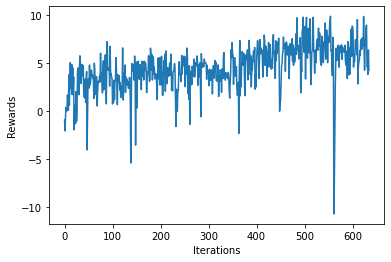

 64%|███████████████████████████████████████████████▋                           | 63608/100000 [43:30<19:39, 30.86it/s]

Updated Weights
Mean Reward = 6.02
22


 64%|███████████████████████████████████████████████▊                           | 63706/100000 [43:33<26:04, 23.20it/s]

Updated Weights
Mean Reward = 7.52
32


 64%|███████████████████████████████████████████████▊                           | 63803/100000 [43:37<26:08, 23.07it/s]

Updated Weights
Mean Reward = 6.11
21


 64%|███████████████████████████████████████████████▉                           | 63905/100000 [43:41<23:45, 25.32it/s]

Updated Weights
Mean Reward = 7.24
29


 64%|███████████████████████████████████████████████▉                           | 63998/100000 [43:44<22:37, 26.52it/s]

Updated Weights
Mean Reward = 7.0
30


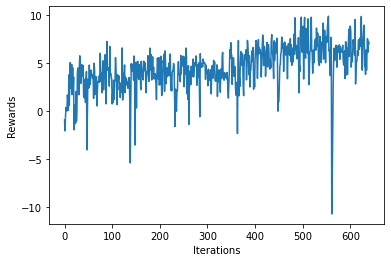

 64%|████████████████████████████████████████████████                           | 64107/100000 [43:48<19:41, 30.39it/s]

Updated Weights
Mean Reward = 7.23
29


 64%|████████████████████████████████████████████████▏                          | 64206/100000 [43:52<22:46, 26.19it/s]

Updated Weights
Mean Reward = 6.82
31


 64%|████████████████████████████████████████████████▏                          | 64305/100000 [43:55<17:08, 34.71it/s]

Updated Weights
Mean Reward = 9.41
49


 64%|████████████████████████████████████████████████▎                          | 64403/100000 [43:58<18:43, 31.69it/s]

Updated Weights
Mean Reward = 8.66
42


 64%|████████████████████████████████████████████████▎                          | 64498/100000 [44:01<18:28, 32.03it/s]

Updated Weights
Mean Reward = 7.69
49


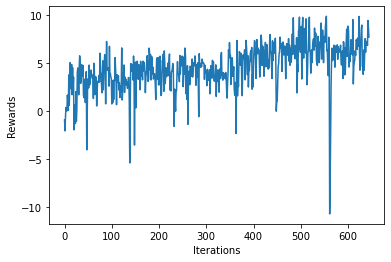

 65%|████████████████████████████████████████████████▍                          | 64604/100000 [44:05<21:14, 27.78it/s]

Updated Weights
Mean Reward = 7.73
33


 65%|████████████████████████████████████████████████▌                          | 64706/100000 [44:09<18:52, 31.16it/s]

Updated Weights
Mean Reward = 7.57
33


 65%|████████████████████████████████████████████████▌                          | 64807/100000 [44:12<14:52, 39.42it/s]

Updated Weights
Mean Reward = 9.91
47


 65%|████████████████████████████████████████████████▋                          | 64905/100000 [44:16<24:51, 23.53it/s]

Updated Weights
Mean Reward = 3.76
24


 65%|████████████████████████████████████████████████▋                          | 64998/100000 [44:19<25:57, 22.47it/s]

Updated Weights
Mean Reward = -5.15
15


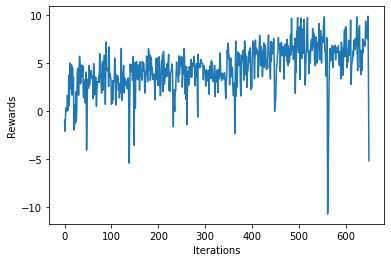

 65%|████████████████████████████████████████████████▊                          | 65102/100000 [44:25<34:06, 17.05it/s]

Updated Weights
Mean Reward = 4.34
18


 65%|████████████████████████████████████████████████▉                          | 65202/100000 [44:31<39:06, 14.83it/s]

Updated Weights
Mean Reward = 4.81
15


 65%|████████████████████████████████████████████████▉                          | 65302/100000 [44:36<36:03, 16.04it/s]

Updated Weights
Mean Reward = 6.37
24


 65%|█████████████████████████████████████████████████                          | 65402/100000 [44:42<35:10, 16.39it/s]

Updated Weights
Mean Reward = 6.48
21


 65%|█████████████████████████████████████████████████                          | 65498/100000 [44:46<26:07, 22.01it/s]

Updated Weights
Mean Reward = 9.27
43


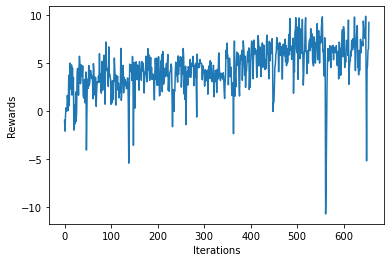

 66%|█████████████████████████████████████████████████▏                         | 65601/100000 [44:52<26:38, 21.52it/s]

Updated Weights
Mean Reward = 8.17
35


 66%|█████████████████████████████████████████████████▎                         | 65703/100000 [44:57<26:30, 21.56it/s]

Updated Weights
Mean Reward = 6.94
34


 66%|█████████████████████████████████████████████████▎                         | 65805/100000 [45:01<19:45, 28.85it/s]

Updated Weights
Mean Reward = 8.65
41


 66%|█████████████████████████████████████████████████▍                         | 65902/100000 [45:06<31:14, 18.19it/s]

Updated Weights
Mean Reward = 6.59
27


 66%|█████████████████████████████████████████████████▍                         | 65999/100000 [45:12<34:24, 16.47it/s]

Updated Weights
Mean Reward = 4.74
15


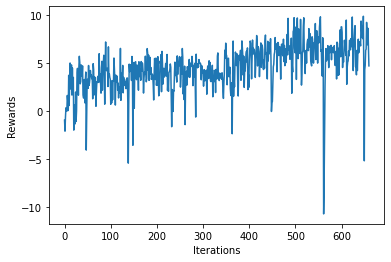

 66%|█████████████████████████████████████████████████▌                         | 66103/100000 [45:17<32:30, 17.38it/s]

Updated Weights
Mean Reward = 8.32
32


 66%|█████████████████████████████████████████████████▋                         | 66203/100000 [45:23<37:17, 15.10it/s]

Updated Weights
Mean Reward = 8.15
35


 66%|█████████████████████████████████████████████████▋                         | 66302/100000 [45:28<29:17, 19.17it/s]

Updated Weights
Mean Reward = 9.92
42


 66%|█████████████████████████████████████████████████▊                         | 66404/100000 [45:33<34:23, 16.28it/s]

Updated Weights
Mean Reward = 6.67
28


 66%|█████████████████████████████████████████████████▊                         | 66499/100000 [45:38<23:42, 23.56it/s]

Updated Weights
Mean Reward = 7.1
44


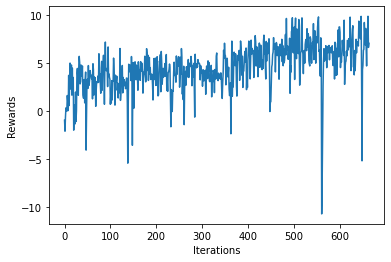

 67%|█████████████████████████████████████████████████▉                         | 66604/100000 [45:43<29:11, 19.07it/s]

Updated Weights
Mean Reward = 6.32
44


 67%|██████████████████████████████████████████████████                         | 66704/100000 [45:48<29:18, 18.94it/s]

Updated Weights
Mean Reward = 8.65
47


 67%|██████████████████████████████████████████████████                         | 66805/100000 [45:53<22:50, 24.21it/s]

Updated Weights
Mean Reward = 7.5
36


 67%|██████████████████████████████████████████████████▏                        | 66903/100000 [45:58<28:08, 19.60it/s]

Updated Weights
Mean Reward = 5.83
38


 67%|██████████████████████████████████████████████████▏                        | 66999/100000 [46:03<25:42, 21.39it/s]

Updated Weights
Mean Reward = 5.03
21


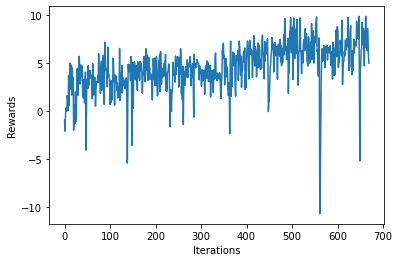

 67%|██████████████████████████████████████████████████▎                        | 67102/100000 [46:09<31:32, 17.38it/s]

Updated Weights
Mean Reward = 5.51
27


 67%|██████████████████████████████████████████████████▍                        | 67204/100000 [46:14<17:51, 30.62it/s]

Updated Weights
Mean Reward = 9.16
53


 67%|██████████████████████████████████████████████████▍                        | 67302/100000 [46:19<31:50, 17.11it/s]

Updated Weights
Mean Reward = 4.11
24


 67%|██████████████████████████████████████████████████▌                        | 67405/100000 [46:25<30:20, 17.91it/s]

Updated Weights
Mean Reward = 3.01
18


 67%|██████████████████████████████████████████████████▌                        | 67499/100000 [46:30<30:21, 17.85it/s]

Updated Weights
Mean Reward = 8.09
39


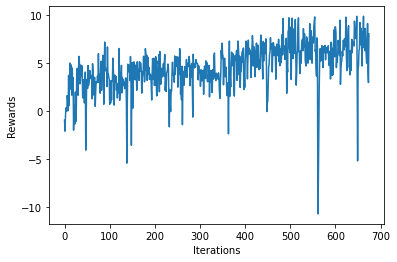

 68%|██████████████████████████████████████████████████▋                        | 67602/100000 [46:36<31:29, 17.14it/s]

Updated Weights
Mean Reward = 3.16
33


 68%|██████████████████████████████████████████████████▊                        | 67704/100000 [46:41<29:55, 17.99it/s]

Updated Weights
Mean Reward = 6.82
26


 68%|██████████████████████████████████████████████████▊                        | 67803/100000 [46:47<33:38, 15.95it/s]

Updated Weights
Mean Reward = 7.46
25


 68%|██████████████████████████████████████████████████▉                        | 67903/100000 [46:53<33:26, 16.00it/s]

Updated Weights
Mean Reward = 7.34
25


 68%|███████████████████████████████████████████████████                        | 68000/100000 [46:59<32:30, 16.40it/s]

Updated Weights
Mean Reward = 7.51
27


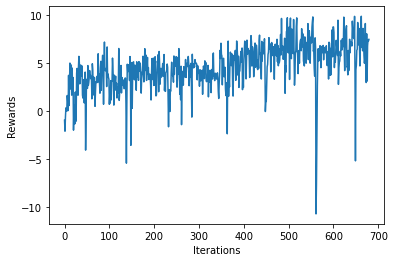

 68%|███████████████████████████████████████████████████                        | 68102/100000 [47:04<30:03, 17.69it/s]

Updated Weights
Mean Reward = 8.06
29


 68%|███████████████████████████████████████████████████▏                       | 68202/100000 [47:10<32:38, 16.24it/s]

Updated Weights
Mean Reward = 8.6
28


 68%|███████████████████████████████████████████████████▏                       | 68304/100000 [47:16<29:55, 17.65it/s]

Updated Weights
Mean Reward = 8.55
36


 68%|███████████████████████████████████████████████████▎                       | 68403/100000 [47:21<21:25, 24.59it/s]

Updated Weights
Mean Reward = 10.81
49


 68%|███████████████████████████████████████████████████▎                       | 68499/100000 [47:26<31:51, 16.48it/s]

Updated Weights
Mean Reward = 9.18
44


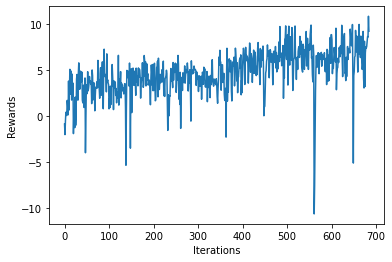

 69%|███████████████████████████████████████████████████▍                       | 68602/100000 [47:31<21:20, 24.52it/s]

Updated Weights
Mean Reward = 11.1
55


 69%|███████████████████████████████████████████████████▌                       | 68703/100000 [47:36<29:42, 17.56it/s]

Updated Weights
Mean Reward = 6.82
54


 69%|███████████████████████████████████████████████████▌                       | 68802/100000 [47:41<30:12, 17.22it/s]

Updated Weights
Mean Reward = 6.19
32


 69%|███████████████████████████████████████████████████▋                       | 68904/100000 [47:46<25:29, 20.33it/s]

Updated Weights
Mean Reward = 4.31
30


 69%|███████████████████████████████████████████████████▋                       | 69000/100000 [47:49<19:15, 26.83it/s]

Updated Weights
Mean Reward = 11.91
63


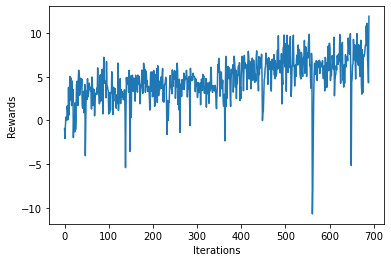

 69%|███████████████████████████████████████████████████▊                       | 69103/100000 [47:54<19:01, 27.07it/s]

Updated Weights
Mean Reward = 6.63
42


 69%|███████████████████████████████████████████████████▉                       | 69203/100000 [47:57<17:28, 29.38it/s]

Updated Weights
Mean Reward = 9.69
58


 69%|███████████████████████████████████████████████████▉                       | 69305/100000 [48:01<19:47, 25.86it/s]

Updated Weights
Mean Reward = 6.36
52


 69%|████████████████████████████████████████████████████                       | 69403/100000 [48:05<23:54, 21.33it/s]

Updated Weights
Mean Reward = 6.86
39


 69%|████████████████████████████████████████████████████                       | 69498/100000 [48:09<19:06, 26.61it/s]

Updated Weights
Mean Reward = 5.9
35


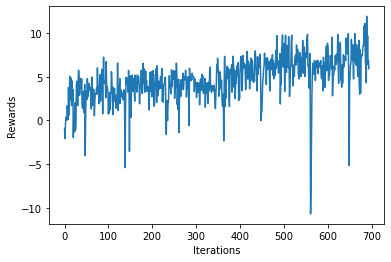

 70%|████████████████████████████████████████████████████▏                      | 69602/100000 [48:13<21:11, 23.92it/s]

Updated Weights
Mean Reward = 6.08
45


 70%|████████████████████████████████████████████████████▎                      | 69702/100000 [48:17<23:07, 21.84it/s]

Updated Weights
Mean Reward = 2.65
28


 70%|████████████████████████████████████████████████████▎                      | 69804/100000 [48:22<24:14, 20.76it/s]

Updated Weights
Mean Reward = 3.46
15


 70%|████████████████████████████████████████████████████▍                      | 69904/100000 [48:26<20:47, 24.13it/s]

Updated Weights
Mean Reward = 8.4
31


 70%|████████████████████████████████████████████████████▍                      | 69998/100000 [48:30<18:00, 27.75it/s]

Updated Weights
Mean Reward = 8.46
37


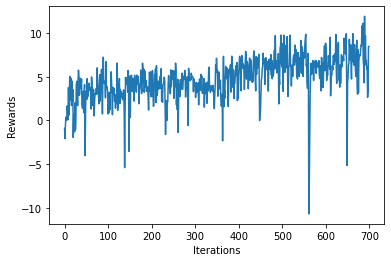

 70%|████████████████████████████████████████████████████▌                      | 70107/100000 [48:34<18:53, 26.36it/s]

Updated Weights
Mean Reward = 9.52
41


 70%|████████████████████████████████████████████████████▋                      | 70204/100000 [48:38<16:44, 29.65it/s]

Updated Weights
Mean Reward = 10.49
53


 70%|████████████████████████████████████████████████████▋                      | 70303/100000 [48:42<18:42, 26.46it/s]

Updated Weights
Mean Reward = 11.79
57


 70%|████████████████████████████████████████████████████▊                      | 70405/100000 [48:45<18:20, 26.89it/s]

Updated Weights
Mean Reward = 10.07
47


 70%|████████████████████████████████████████████████████▊                      | 70498/100000 [48:49<16:58, 28.97it/s]

Updated Weights
Mean Reward = 8.3
43


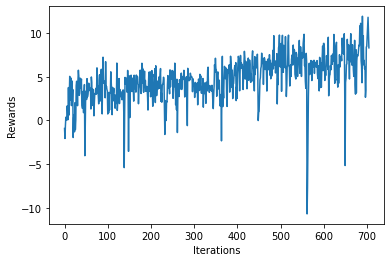

 71%|████████████████████████████████████████████████████▉                      | 70602/100000 [48:54<24:19, 20.14it/s]

Updated Weights
Mean Reward = 7.31
38


 71%|█████████████████████████████████████████████████████                      | 70705/100000 [48:59<21:06, 23.13it/s]

Updated Weights
Mean Reward = 8.8
51


 71%|█████████████████████████████████████████████████████                      | 70804/100000 [49:03<18:52, 25.78it/s]

Updated Weights
Mean Reward = 10.43
65


 71%|█████████████████████████████████████████████████████▏                     | 70903/100000 [49:07<25:12, 19.24it/s]

Updated Weights
Mean Reward = 8.09
56


 71%|█████████████████████████████████████████████████████▏                     | 70999/100000 [49:13<24:43, 19.54it/s]

Updated Weights
Mean Reward = 7.73
34


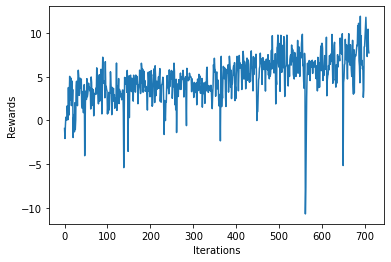

 71%|█████████████████████████████████████████████████████▎                     | 71105/100000 [49:18<23:06, 20.84it/s]

Updated Weights
Mean Reward = 4.38
27


 71%|█████████████████████████████████████████████████████▍                     | 71201/100000 [49:23<22:28, 21.35it/s]

Updated Weights
Mean Reward = 9.19
38


 71%|█████████████████████████████████████████████████████▍                     | 71303/100000 [49:28<20:21, 23.48it/s]

Updated Weights
Mean Reward = 8.63
36


 71%|█████████████████████████████████████████████████████▌                     | 71403/100000 [49:33<27:36, 17.27it/s]

Updated Weights
Mean Reward = 9.32
38


 72%|█████████████████████████████████████████████████████▋                     | 71500/100000 [49:38<25:22, 18.71it/s]

Updated Weights
Mean Reward = 9.67
51


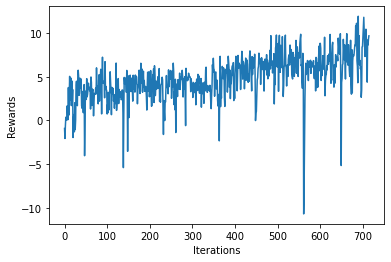

 72%|█████████████████████████████████████████████████████▋                     | 71605/100000 [49:43<20:01, 23.62it/s]

Updated Weights
Mean Reward = 9.35
46


 72%|█████████████████████████████████████████████████████▊                     | 71703/100000 [49:47<21:22, 22.06it/s]

Updated Weights
Mean Reward = 8.36
55


 72%|█████████████████████████████████████████████████████▊                     | 71804/100000 [49:51<21:18, 22.06it/s]

Updated Weights
Mean Reward = 9.47
57


 72%|█████████████████████████████████████████████████████▉                     | 71905/100000 [49:56<19:58, 23.44it/s]

Updated Weights
Mean Reward = 7.31
44


 72%|█████████████████████████████████████████████████████▉                     | 71998/100000 [50:00<24:20, 19.17it/s]

Updated Weights
Mean Reward = 6.45
50


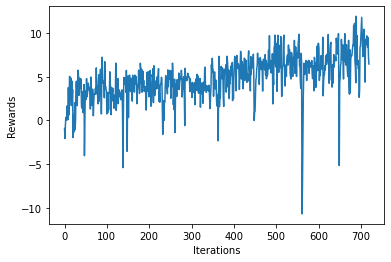

 72%|██████████████████████████████████████████████████████                     | 72102/100000 [50:05<21:39, 21.46it/s]

Updated Weights
Mean Reward = 9.19
50


 72%|██████████████████████████████████████████████████████▏                    | 72206/100000 [50:09<17:08, 27.02it/s]

Updated Weights
Mean Reward = 11.91
60


 72%|██████████████████████████████████████████████████████▏                    | 72302/100000 [50:13<22:41, 20.35it/s]

Updated Weights
Mean Reward = 9.49
58


 72%|██████████████████████████████████████████████████████▎                    | 72404/100000 [50:17<23:22, 19.67it/s]

Updated Weights
Mean Reward = 7.26
41


 72%|██████████████████████████████████████████████████████▎                    | 72499/100000 [50:22<28:03, 16.34it/s]

Updated Weights
Mean Reward = 4.34
29


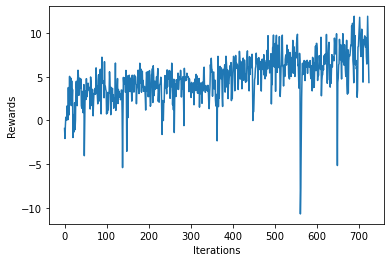

 73%|██████████████████████████████████████████████████████▍                    | 72605/100000 [50:27<17:08, 26.63it/s]

Updated Weights
Mean Reward = 7.25
41


 73%|██████████████████████████████████████████████████████▌                    | 72704/100000 [50:31<18:25, 24.69it/s]

Updated Weights
Mean Reward = 9.17
66


 73%|██████████████████████████████████████████████████████▌                    | 72802/100000 [50:35<17:35, 25.76it/s]

Updated Weights
Mean Reward = 8.9
61


 73%|██████████████████████████████████████████████████████▋                    | 72902/100000 [50:40<21:15, 21.24it/s]

Updated Weights
Mean Reward = 4.18
37


 73%|██████████████████████████████████████████████████████▊                    | 73000/100000 [50:43<14:23, 31.29it/s]

Updated Weights
Mean Reward = 9.89
49


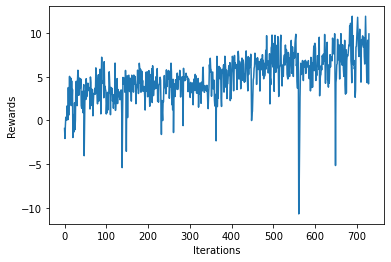

 73%|██████████████████████████████████████████████████████▊                    | 73105/100000 [50:46<15:57, 28.09it/s]

Updated Weights
Mean Reward = 6.24
41


 73%|██████████████████████████████████████████████████████▉                    | 73205/100000 [50:50<12:38, 35.31it/s]

Updated Weights
Mean Reward = 9.61
45


 73%|██████████████████████████████████████████████████████▉                    | 73303/100000 [50:53<14:12, 31.32it/s]

Updated Weights
Mean Reward = 7.78
44


 73%|███████████████████████████████████████████████████████                    | 73407/100000 [50:56<14:15, 31.09it/s]

Updated Weights
Mean Reward = 8.19
49


 73%|███████████████████████████████████████████████████████                    | 73497/100000 [50:59<11:50, 37.29it/s]

Updated Weights
Mean Reward = 9.09
54


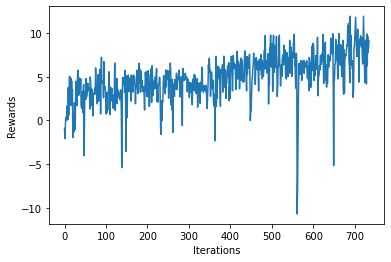

 74%|███████████████████████████████████████████████████████▏                   | 73604/100000 [51:03<16:09, 27.24it/s]

Updated Weights
Mean Reward = 6.6
39


 74%|███████████████████████████████████████████████████████▎                   | 73706/100000 [51:06<13:10, 33.27it/s]

Updated Weights
Mean Reward = 6.17
35


 74%|███████████████████████████████████████████████████████▎                   | 73806/100000 [51:10<15:27, 28.24it/s]

Updated Weights
Mean Reward = 4.81
30


 74%|███████████████████████████████████████████████████████▍                   | 73908/100000 [51:13<11:50, 36.73it/s]

Updated Weights
Mean Reward = 9.41
40


 74%|███████████████████████████████████████████████████████▍                   | 73998/100000 [51:16<12:20, 35.11it/s]

Updated Weights
Mean Reward = 11.01
57


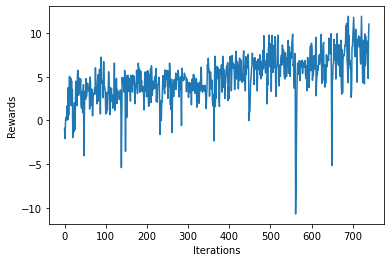

 74%|███████████████████████████████████████████████████████▌                   | 74106/100000 [51:19<09:55, 43.45it/s]

Updated Weights
Mean Reward = 9.99
62


 74%|███████████████████████████████████████████████████████▋                   | 74207/100000 [51:21<10:35, 40.62it/s]

Updated Weights
Mean Reward = 8.74
63


 74%|███████████████████████████████████████████████████████▋                   | 74307/100000 [51:25<12:19, 34.74it/s]

Updated Weights
Mean Reward = 4.51
42


 74%|███████████████████████████████████████████████████████▊                   | 74407/100000 [51:28<11:57, 35.65it/s]

Updated Weights
Mean Reward = 8.92
45


 74%|███████████████████████████████████████████████████████▊                   | 74495/100000 [51:30<12:11, 34.85it/s]

Updated Weights
Mean Reward = 11.41
60


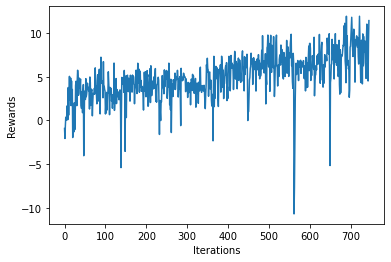

 75%|███████████████████████████████████████████████████████▉                   | 74603/100000 [51:35<17:21, 24.39it/s]

Updated Weights
Mean Reward = 3.59
27


 75%|████████████████████████████████████████████████████████                   | 74704/100000 [51:38<14:52, 28.34it/s]

Updated Weights
Mean Reward = 7.13
30


 75%|████████████████████████████████████████████████████████                   | 74804/100000 [51:42<15:47, 26.60it/s]

Updated Weights
Mean Reward = 8.54
33


 75%|████████████████████████████████████████████████████████▏                  | 74904/100000 [51:45<12:36, 33.17it/s]

Updated Weights
Mean Reward = 11.18
56


 75%|████████████████████████████████████████████████████████▎                  | 75000/100000 [51:49<15:17, 27.24it/s]

Updated Weights
Mean Reward = 8.45
38


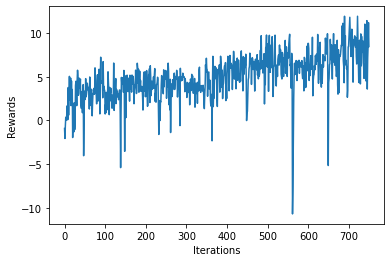

 75%|████████████████████████████████████████████████████████▎                  | 75105/100000 [51:52<13:55, 29.79it/s]

Updated Weights
Mean Reward = 8.08
37


 75%|████████████████████████████████████████████████████████▍                  | 75205/100000 [51:56<15:34, 26.54it/s]

Updated Weights
Mean Reward = 7.47
46


 75%|████████████████████████████████████████████████████████▍                  | 75304/100000 [51:59<12:12, 33.73it/s]

Updated Weights
Mean Reward = 9.44
43


 75%|████████████████████████████████████████████████████████▌                  | 75404/100000 [52:02<13:44, 29.84it/s]

Updated Weights
Mean Reward = 10.54
55


 76%|████████████████████████████████████████████████████████▋                  | 75500/100000 [52:05<13:23, 30.49it/s]

Updated Weights
Mean Reward = 10.32
49


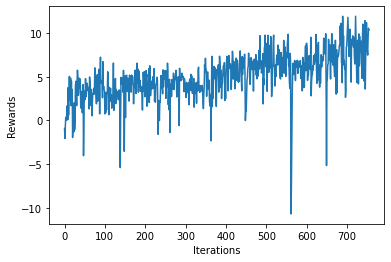

 76%|████████████████████████████████████████████████████████▋                  | 75606/100000 [52:08<14:12, 28.62it/s]

Updated Weights
Mean Reward = 8.13
50


 76%|████████████████████████████████████████████████████████▊                  | 75705/100000 [52:12<14:23, 28.14it/s]

Updated Weights
Mean Reward = 4.34
27


 76%|████████████████████████████████████████████████████████▊                  | 75802/100000 [52:16<14:13, 28.35it/s]

Updated Weights
Mean Reward = 9.64
43


 76%|████████████████████████████████████████████████████████▉                  | 75905/100000 [52:18<12:06, 33.16it/s]

Updated Weights
Mean Reward = 12.16
64


 76%|████████████████████████████████████████████████████████▉                  | 75997/100000 [52:21<13:46, 29.06it/s]

Updated Weights
Mean Reward = 9.75
48


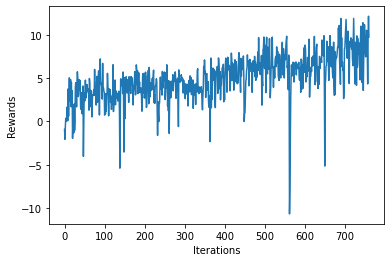

 76%|█████████████████████████████████████████████████████████                  | 76105/100000 [52:25<13:51, 28.72it/s]

Updated Weights
Mean Reward = 6.44
33


 76%|█████████████████████████████████████████████████████████▏                 | 76205/100000 [52:29<12:09, 32.63it/s]

Updated Weights
Mean Reward = 5.32
29


 76%|█████████████████████████████████████████████████████████▏                 | 76305/100000 [52:32<15:05, 26.17it/s]

Updated Weights
Mean Reward = 10.49
57


 76%|█████████████████████████████████████████████████████████▎                 | 76404/100000 [52:36<14:38, 26.86it/s]

Updated Weights
Mean Reward = 4.51
30


 76%|█████████████████████████████████████████████████████████▎                 | 76499/100000 [52:39<13:41, 28.59it/s]

Updated Weights
Mean Reward = 6.83
32


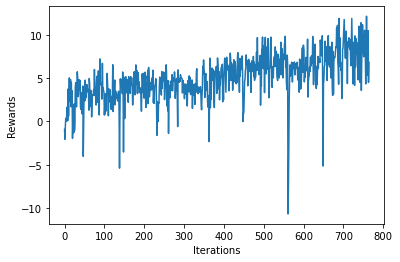

 77%|█████████████████████████████████████████████████████████▍                 | 76605/100000 [52:43<12:12, 31.94it/s]

Updated Weights
Mean Reward = 8.88
44


 77%|█████████████████████████████████████████████████████████▌                 | 76703/100000 [52:45<09:59, 38.83it/s]

Updated Weights
Mean Reward = 12.2
63


 77%|█████████████████████████████████████████████████████████▌                 | 76807/100000 [52:49<11:48, 32.73it/s]

Updated Weights
Mean Reward = 7.28
48


 77%|█████████████████████████████████████████████████████████▋                 | 76905/100000 [52:51<12:06, 31.78it/s]

Updated Weights
Mean Reward = 8.64
55


 77%|█████████████████████████████████████████████████████████▋                 | 76997/100000 [52:54<13:10, 29.09it/s]

Updated Weights
Mean Reward = 9.44
48


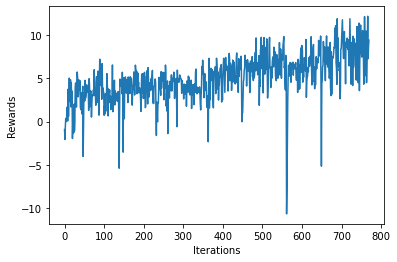

 77%|█████████████████████████████████████████████████████████▊                 | 77104/100000 [52:58<12:21, 30.88it/s]

Updated Weights
Mean Reward = 8.59
46


 77%|█████████████████████████████████████████████████████████▉                 | 77206/100000 [53:02<13:24, 28.32it/s]

Updated Weights
Mean Reward = 6.71
31


 77%|█████████████████████████████████████████████████████████▉                 | 77306/100000 [53:05<14:23, 26.30it/s]

Updated Weights
Mean Reward = 6.25
29


 77%|██████████████████████████████████████████████████████████                 | 77403/100000 [53:09<12:06, 31.11it/s]

Updated Weights
Mean Reward = 2.87
34


 77%|██████████████████████████████████████████████████████████                 | 77498/100000 [53:11<12:20, 30.40it/s]

Updated Weights
Mean Reward = 8.23
53


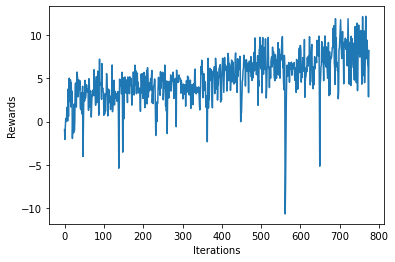

 78%|██████████████████████████████████████████████████████████▏                | 77603/100000 [53:15<09:59, 37.39it/s]

Updated Weights
Mean Reward = 9.61
51


 78%|██████████████████████████████████████████████████████████▎                | 77708/100000 [53:18<10:39, 34.87it/s]

Updated Weights
Mean Reward = 9.36
51


 78%|██████████████████████████████████████████████████████████▎                | 77807/100000 [53:21<10:01, 36.88it/s]

Updated Weights
Mean Reward = 10.51
57


 78%|██████████████████████████████████████████████████████████▍                | 77904/100000 [53:23<12:19, 29.88it/s]

Updated Weights
Mean Reward = 10.36
59


 78%|██████████████████████████████████████████████████████████▍                | 77999/100000 [53:27<11:32, 31.77it/s]

Updated Weights
Mean Reward = 9.1
46


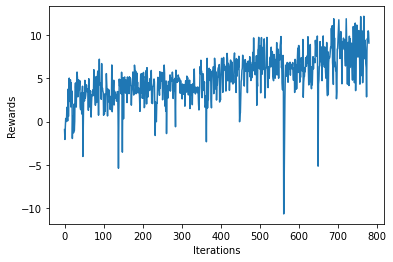

 78%|██████████████████████████████████████████████████████████▌                | 78102/100000 [53:30<12:06, 30.15it/s]

Updated Weights
Mean Reward = 10.49
55


 78%|██████████████████████████████████████████████████████████▋                | 78205/100000 [53:33<12:05, 30.04it/s]

Updated Weights
Mean Reward = 10.14
57


 78%|██████████████████████████████████████████████████████████▋                | 78304/100000 [53:36<13:00, 27.81it/s]

Updated Weights
Mean Reward = 3.41
32


 78%|██████████████████████████████████████████████████████████▊                | 78403/100000 [53:40<14:10, 25.39it/s]

Updated Weights
Mean Reward = 4.11
30


 78%|██████████████████████████████████████████████████████████▊                | 78498/100000 [53:43<12:53, 27.81it/s]

Updated Weights
Mean Reward = 7.6
33


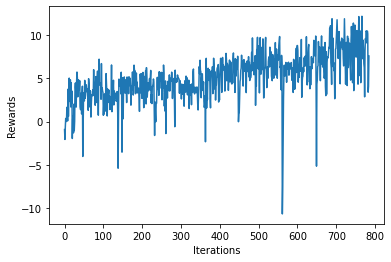

 79%|██████████████████████████████████████████████████████████▉                | 78605/100000 [53:47<12:30, 28.49it/s]

Updated Weights
Mean Reward = 7.59
31


 79%|███████████████████████████████████████████████████████████                | 78705/100000 [53:51<11:41, 30.35it/s]

Updated Weights
Mean Reward = 8.82
40


 79%|███████████████████████████████████████████████████████████                | 78804/100000 [53:54<14:08, 24.97it/s]

Updated Weights
Mean Reward = 10.14
44


 79%|███████████████████████████████████████████████████████████▏               | 78906/100000 [53:58<11:58, 29.36it/s]

Updated Weights
Mean Reward = 8.83
34


 79%|███████████████████████████████████████████████████████████▎               | 79000/100000 [54:01<10:03, 34.81it/s]

Updated Weights
Mean Reward = 10.39
51


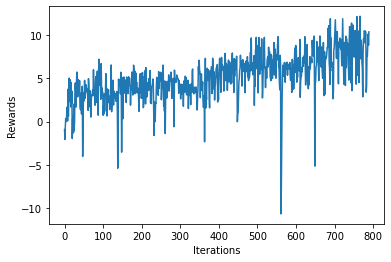

 79%|███████████████████████████████████████████████████████████▎               | 79103/100000 [54:04<12:35, 27.65it/s]

Updated Weights
Mean Reward = 7.52
39


 79%|███████████████████████████████████████████████████████████▍               | 79204/100000 [54:08<12:34, 27.56it/s]

Updated Weights
Mean Reward = 9.38
42


 79%|███████████████████████████████████████████████████████████▍               | 79304/100000 [54:11<11:35, 29.76it/s]

Updated Weights
Mean Reward = 8.92
41


 79%|███████████████████████████████████████████████████████████▌               | 79404/100000 [54:14<12:39, 27.13it/s]

Updated Weights
Mean Reward = 9.05
45


 79%|███████████████████████████████████████████████████████████▌               | 79499/100000 [54:18<11:54, 28.70it/s]

Updated Weights
Mean Reward = 7.5
35


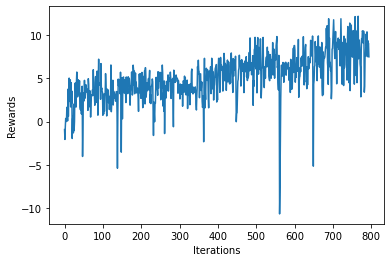

 80%|███████████████████████████████████████████████████████████▋               | 79602/100000 [54:22<14:04, 24.16it/s]

Updated Weights
Mean Reward = 8.9
40


 80%|███████████████████████████████████████████████████████████▊               | 79704/100000 [54:26<12:17, 27.53it/s]

Updated Weights
Mean Reward = 9.68
46


 80%|███████████████████████████████████████████████████████████▊               | 79804/100000 [54:31<15:40, 21.47it/s]

Updated Weights
Mean Reward = 7.98
39


 80%|███████████████████████████████████████████████████████████▉               | 79904/100000 [54:36<16:07, 20.77it/s]

Updated Weights
Mean Reward = 8.8
36


 80%|███████████████████████████████████████████████████████████▉               | 79999/100000 [54:41<16:39, 20.02it/s]

Updated Weights
Mean Reward = 8.56
34


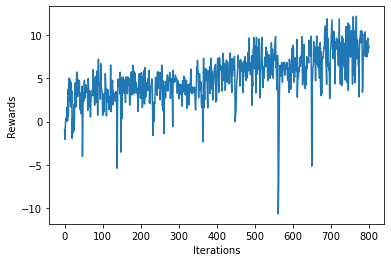

 80%|████████████████████████████████████████████████████████████               | 80103/100000 [54:46<16:27, 20.15it/s]

Updated Weights
Mean Reward = 10.56
47


 80%|████████████████████████████████████████████████████████████▏              | 80205/100000 [54:51<17:22, 18.99it/s]

Updated Weights
Mean Reward = 8.78
39


 80%|████████████████████████████████████████████████████████████▏              | 80302/100000 [54:56<13:13, 24.81it/s]

Updated Weights
Mean Reward = 7.13
42


 80%|████████████████████████████████████████████████████████████▎              | 80403/100000 [55:01<16:19, 20.01it/s]

Updated Weights
Mean Reward = 8.21
49


 80%|████████████████████████████████████████████████████████████▎              | 80499/100000 [55:04<10:03, 32.32it/s]

Updated Weights
Mean Reward = 12.05
66


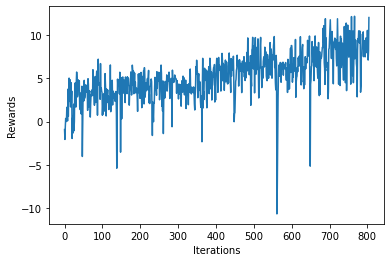

 81%|████████████████████████████████████████████████████████████▍              | 80603/100000 [55:09<14:52, 21.74it/s]

Updated Weights
Mean Reward = 8.69
43


 81%|████████████████████████████████████████████████████████████▌              | 80704/100000 [55:14<16:04, 20.01it/s]

Updated Weights
Mean Reward = 9.07
54


 81%|████████████████████████████████████████████████████████████▌              | 80802/100000 [55:18<15:36, 20.50it/s]

Updated Weights
Mean Reward = 6.22
42


 81%|████████████████████████████████████████████████████████████▋              | 80907/100000 [55:23<12:52, 24.73it/s]

Updated Weights
Mean Reward = 9.06
47


 81%|████████████████████████████████████████████████████████████▊              | 81000/100000 [55:28<15:00, 21.09it/s]

Updated Weights
Mean Reward = 7.82
43


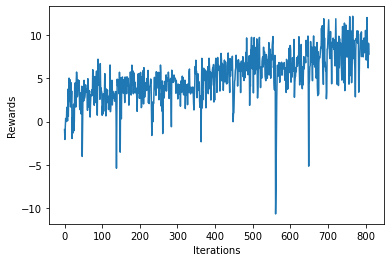

 81%|████████████████████████████████████████████████████████████▊              | 81103/100000 [55:32<15:33, 20.24it/s]

Updated Weights
Mean Reward = 11.17
66


 81%|████████████████████████████████████████████████████████████▉              | 81204/100000 [55:37<14:26, 21.70it/s]

Updated Weights
Mean Reward = 6.24
44


 81%|████████████████████████████████████████████████████████████▉              | 81303/100000 [55:43<17:35, 17.72it/s]

Updated Weights
Mean Reward = 2.53
28


 81%|█████████████████████████████████████████████████████████████              | 81402/100000 [55:48<18:04, 17.15it/s]

Updated Weights
Mean Reward = 4.88
23


 82%|█████████████████████████████████████████████████████████████              | 81500/100000 [55:54<14:06, 21.86it/s]

Updated Weights
Mean Reward = 8.16
33


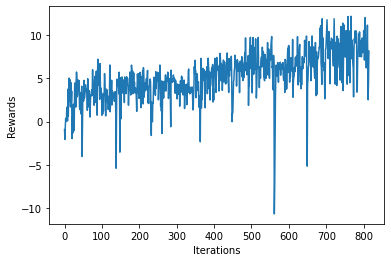

 82%|█████████████████████████████████████████████████████████████▏             | 81602/100000 [55:59<13:58, 21.94it/s]

Updated Weights
Mean Reward = 9.57
44


 82%|█████████████████████████████████████████████████████████████▎             | 81704/100000 [56:04<15:04, 20.22it/s]

Updated Weights
Mean Reward = 7.94
36


 82%|█████████████████████████████████████████████████████████████▎             | 81804/100000 [56:09<14:02, 21.59it/s]

Updated Weights
Mean Reward = 9.11
40


 82%|█████████████████████████████████████████████████████████████▍             | 81904/100000 [56:14<15:11, 19.85it/s]

Updated Weights
Mean Reward = 9.73
48


 82%|█████████████████████████████████████████████████████████████▍             | 81998/100000 [56:18<12:10, 24.64it/s]

Updated Weights
Mean Reward = 9.03
50


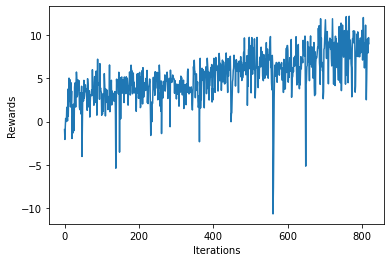

 82%|█████████████████████████████████████████████████████████████▌             | 82102/100000 [56:24<17:33, 16.99it/s]

Updated Weights
Mean Reward = 8.67
44


 82%|█████████████████████████████████████████████████████████████▋             | 82203/100000 [56:28<14:22, 20.62it/s]

Updated Weights
Mean Reward = 9.91
50


 82%|█████████████████████████████████████████████████████████████▋             | 82302/100000 [56:33<14:15, 20.68it/s]

Updated Weights
Mean Reward = 9.84
45


 82%|█████████████████████████████████████████████████████████████▊             | 82403/100000 [56:38<12:51, 22.80it/s]

Updated Weights
Mean Reward = 10.54
53


 82%|█████████████████████████████████████████████████████████████▉             | 82500/100000 [56:43<15:27, 18.88it/s]

Updated Weights
Mean Reward = 5.35
36


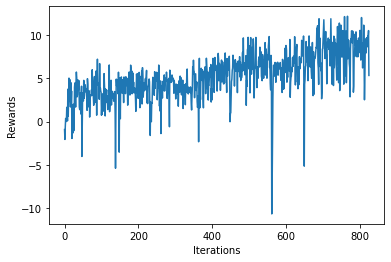

 83%|█████████████████████████████████████████████████████████████▉             | 82602/100000 [56:49<17:42, 16.38it/s]

Updated Weights
Mean Reward = 1.19
14


 83%|██████████████████████████████████████████████████████████████             | 82704/100000 [56:55<17:53, 16.10it/s]

Updated Weights
Mean Reward = 6.51
27


 83%|██████████████████████████████████████████████████████████████             | 82803/100000 [57:01<15:16, 18.76it/s]

Updated Weights
Mean Reward = 7.15
28


 83%|██████████████████████████████████████████████████████████████▏            | 82904/100000 [57:05<13:14, 21.51it/s]

Updated Weights
Mean Reward = 9.65
45


 83%|██████████████████████████████████████████████████████████████▎            | 83000/100000 [57:10<13:17, 21.31it/s]

Updated Weights
Mean Reward = 9.74
48


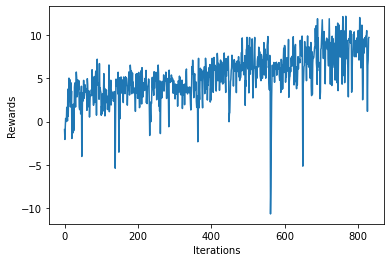

 83%|██████████████████████████████████████████████████████████████▎            | 83104/100000 [57:15<14:19, 19.66it/s]

Updated Weights
Mean Reward = 10.91
52


 83%|██████████████████████████████████████████████████████████████▍            | 83204/100000 [57:20<15:00, 18.65it/s]

Updated Weights
Mean Reward = 9.09
38


 83%|██████████████████████████████████████████████████████████████▍            | 83302/100000 [57:25<13:33, 20.53it/s]

Updated Weights
Mean Reward = 8.78
37


 83%|██████████████████████████████████████████████████████████████▌            | 83404/100000 [57:30<11:06, 24.89it/s]

Updated Weights
Mean Reward = 9.71
44


 83%|██████████████████████████████████████████████████████████████▌            | 83498/100000 [57:34<13:37, 20.18it/s]

Updated Weights
Mean Reward = 11.05
58


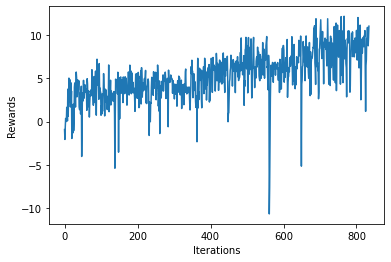

 84%|██████████████████████████████████████████████████████████████▋            | 83602/100000 [57:40<15:57, 17.13it/s]

Updated Weights
Mean Reward = 7.99
33


 84%|██████████████████████████████████████████████████████████████▊            | 83702/100000 [57:45<16:06, 16.86it/s]

Updated Weights
Mean Reward = 5.88
24


 84%|██████████████████████████████████████████████████████████████▊            | 83805/100000 [57:51<11:55, 22.64it/s]

Updated Weights
Mean Reward = 9.3
40


 84%|██████████████████████████████████████████████████████████████▉            | 83902/100000 [57:55<12:00, 22.34it/s]

Updated Weights
Mean Reward = 9.16
48


 84%|██████████████████████████████████████████████████████████████▉            | 83998/100000 [58:00<12:57, 20.57it/s]

Updated Weights
Mean Reward = 8.1
41


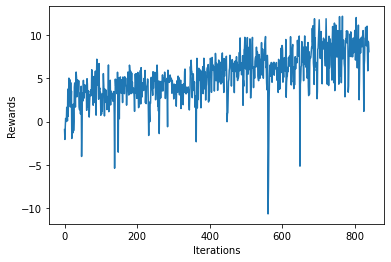

 84%|███████████████████████████████████████████████████████████████            | 84102/100000 [58:05<15:11, 17.45it/s]

Updated Weights
Mean Reward = 8.76
38


 84%|███████████████████████████████████████████████████████████████▏           | 84205/100000 [58:10<12:42, 20.73it/s]

Updated Weights
Mean Reward = 8.43
38


 84%|███████████████████████████████████████████████████████████████▏           | 84303/100000 [58:14<11:11, 23.37it/s]

Updated Weights
Mean Reward = 11.56
65


 84%|███████████████████████████████████████████████████████████████▎           | 84402/100000 [58:19<15:48, 16.45it/s]

Updated Weights
Mean Reward = 5.15
36


 84%|███████████████████████████████████████████████████████████████▍           | 84500/100000 [58:25<14:58, 17.26it/s]

Updated Weights
Mean Reward = 2.43
22


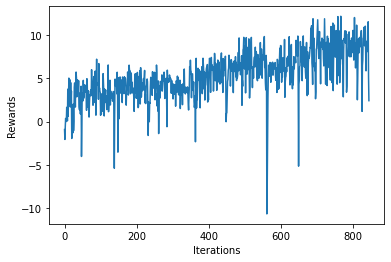

 85%|███████████████████████████████████████████████████████████████▍           | 84605/100000 [58:31<13:21, 19.21it/s]

Updated Weights
Mean Reward = 3.98
16


 85%|███████████████████████████████████████████████████████████████▌           | 84704/100000 [58:36<10:42, 23.82it/s]

Updated Weights
Mean Reward = 4.1
27


 85%|███████████████████████████████████████████████████████████████▌           | 84804/100000 [58:40<10:08, 24.97it/s]

Updated Weights
Mean Reward = 7.85
30


 85%|███████████████████████████████████████████████████████████████▋           | 84905/100000 [58:44<09:09, 27.47it/s]

Updated Weights
Mean Reward = 10.17
47


 85%|███████████████████████████████████████████████████████████████▊           | 85000/100000 [58:47<08:08, 30.69it/s]

Updated Weights
Mean Reward = 11.75
61


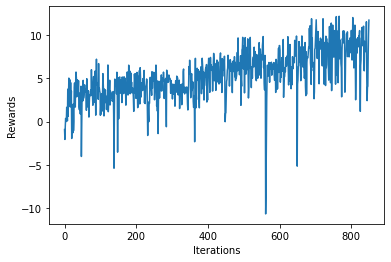

 85%|███████████████████████████████████████████████████████████████▊           | 85103/100000 [58:51<10:21, 23.98it/s]

Updated Weights
Mean Reward = 10.03
50


 85%|███████████████████████████████████████████████████████████████▉           | 85203/100000 [58:55<11:30, 21.43it/s]

Updated Weights
Mean Reward = 9.03
37


 85%|███████████████████████████████████████████████████████████████▉           | 85306/100000 [58:59<07:58, 30.72it/s]

Updated Weights
Mean Reward = 10.2
54


 85%|████████████████████████████████████████████████████████████████           | 85403/100000 [59:02<07:14, 33.61it/s]

Updated Weights
Mean Reward = 11.38
59


 86%|████████████████████████████████████████████████████████████████▏          | 85500/100000 [59:06<10:40, 22.63it/s]

Updated Weights
Mean Reward = 4.89
30


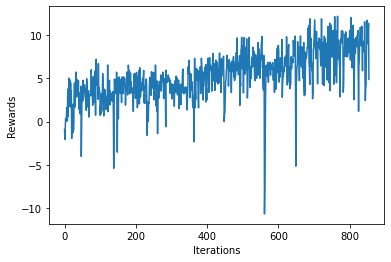

 86%|████████████████████████████████████████████████████████████████▏          | 85602/100000 [59:11<10:27, 22.96it/s]

Updated Weights
Mean Reward = 4.04
22


 86%|████████████████████████████████████████████████████████████████▎          | 85705/100000 [59:15<09:06, 26.16it/s]

Updated Weights
Mean Reward = 7.24
32


 86%|████████████████████████████████████████████████████████████████▎          | 85804/100000 [59:18<08:00, 29.55it/s]

Updated Weights
Mean Reward = 9.17
40


 86%|████████████████████████████████████████████████████████████████▍          | 85901/100000 [59:21<07:24, 31.69it/s]

Updated Weights
Mean Reward = 10.3
53


 86%|████████████████████████████████████████████████████████████████▍          | 85998/100000 [59:25<08:19, 28.02it/s]

Updated Weights
Mean Reward = 9.69
51


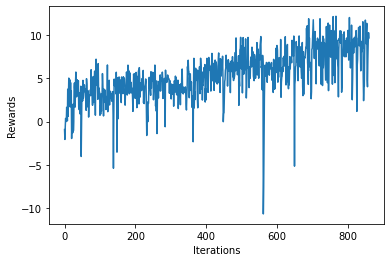

 86%|████████████████████████████████████████████████████████████████▌          | 86106/100000 [59:29<08:59, 25.77it/s]

Updated Weights
Mean Reward = 9.88
46


 86%|████████████████████████████████████████████████████████████████▋          | 86203/100000 [59:32<09:34, 24.03it/s]

Updated Weights
Mean Reward = 8.02
50


 86%|████████████████████████████████████████████████████████████████▋          | 86304/100000 [59:36<07:29, 30.50it/s]

Updated Weights
Mean Reward = 10.65
64


 86%|████████████████████████████████████████████████████████████████▊          | 86403/100000 [59:42<13:46, 16.45it/s]

Updated Weights
Mean Reward = 1.78
24


 86%|████████████████████████████████████████████████████████████████▊          | 86499/100000 [59:47<10:12, 22.03it/s]

Updated Weights
Mean Reward = 3.41
30


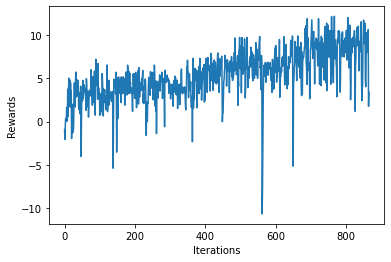

 87%|████████████████████████████████████████████████████████████████▉          | 86603/100000 [59:52<11:57, 18.66it/s]

Updated Weights
Mean Reward = 7.27
36


 87%|█████████████████████████████████████████████████████████████████          | 86703/100000 [59:57<09:45, 22.73it/s]

Updated Weights
Mean Reward = 8.51
45


 87%|███████████████████████████████████████████████████████████████▎         | 86802/100000 [1:00:01<10:12, 21.55it/s]

Updated Weights
Mean Reward = 9.61
46


 87%|███████████████████████████████████████████████████████████████▍         | 86903/100000 [1:00:06<08:58, 24.30it/s]

Updated Weights
Mean Reward = 10.79
52


 87%|███████████████████████████████████████████████████████████████▌         | 86998/100000 [1:00:09<10:06, 21.43it/s]

Updated Weights
Mean Reward = 11.21
55


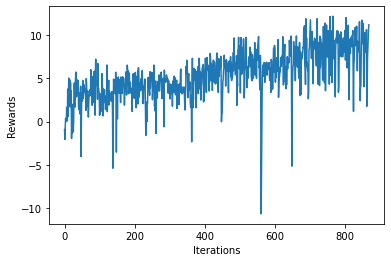

 87%|███████████████████████████████████████████████████████████████▌         | 87102/100000 [1:00:15<07:28, 28.78it/s]

Updated Weights
Mean Reward = 7.27
33


 87%|███████████████████████████████████████████████████████████████▋         | 87205/100000 [1:00:18<07:51, 27.12it/s]

Updated Weights
Mean Reward = 7.25
27


 87%|███████████████████████████████████████████████████████████████▋         | 87306/100000 [1:00:22<07:21, 28.76it/s]

Updated Weights
Mean Reward = 9.21
39


 87%|███████████████████████████████████████████████████████████████▊         | 87404/100000 [1:00:25<07:22, 28.48it/s]

Updated Weights
Mean Reward = 9.45
43


 88%|███████████████████████████████████████████████████████████████▉         | 87500/100000 [1:00:28<06:54, 30.18it/s]

Updated Weights
Mean Reward = 8.57
42


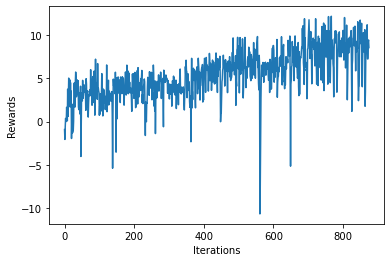

 88%|███████████████████████████████████████████████████████████████▉         | 87603/100000 [1:00:31<06:26, 32.06it/s]

Updated Weights
Mean Reward = 9.73
46


 88%|████████████████████████████████████████████████████████████████         | 87704/100000 [1:00:35<07:15, 28.21it/s]

Updated Weights
Mean Reward = 8.66
41


 88%|████████████████████████████████████████████████████████████████         | 87806/100000 [1:00:38<06:34, 30.89it/s]

Updated Weights
Mean Reward = 7.96
49


 88%|████████████████████████████████████████████████████████████████▏        | 87904/100000 [1:00:41<06:43, 29.99it/s]

Updated Weights
Mean Reward = 10.37
50


 88%|████████████████████████████████████████████████████████████████▏        | 87996/100000 [1:00:44<05:42, 35.07it/s]

Updated Weights
Mean Reward = 11.01
57


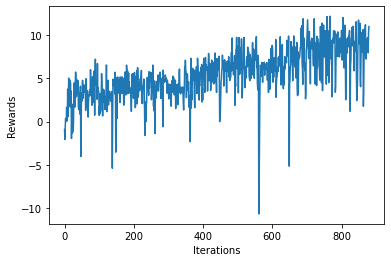

 88%|████████████████████████████████████████████████████████████████▎        | 88102/100000 [1:00:47<06:11, 32.02it/s]

Updated Weights
Mean Reward = 8.94
48


 88%|████████████████████████████████████████████████████████████████▍        | 88205/100000 [1:00:50<06:48, 28.85it/s]

Updated Weights
Mean Reward = 10.19
49


 88%|████████████████████████████████████████████████████████████████▍        | 88304/100000 [1:00:53<05:12, 37.48it/s]

Updated Weights
Mean Reward = 10.12
56


 88%|████████████████████████████████████████████████████████████████▌        | 88406/100000 [1:00:56<05:55, 32.65it/s]

Updated Weights
Mean Reward = 10.85
60


 88%|████████████████████████████████████████████████████████████████▌        | 88500/100000 [1:00:59<06:40, 28.71it/s]

Updated Weights
Mean Reward = 5.35
36


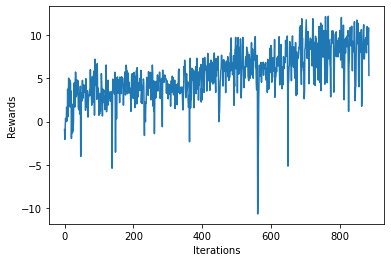

 89%|████████████████████████████████████████████████████████████████▋        | 88608/100000 [1:01:03<06:00, 31.57it/s]

Updated Weights
Mean Reward = 8.56
44


 89%|████████████████████████████████████████████████████████████████▊        | 88705/100000 [1:01:06<06:03, 31.08it/s]

Updated Weights
Mean Reward = 8.68
46


 89%|████████████████████████████████████████████████████████████████▊        | 88807/100000 [1:01:09<05:19, 35.07it/s]

Updated Weights
Mean Reward = 9.6
46


 89%|████████████████████████████████████████████████████████████████▉        | 88906/100000 [1:01:12<06:14, 29.60it/s]

Updated Weights
Mean Reward = 8.78
45


 89%|████████████████████████████████████████████████████████████████▉        | 88999/100000 [1:01:15<06:35, 27.80it/s]

Updated Weights
Mean Reward = 8.48
43


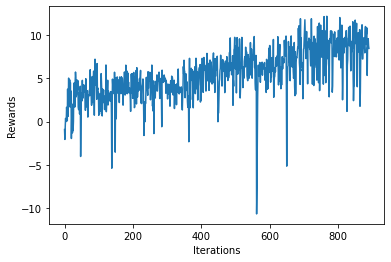

 89%|█████████████████████████████████████████████████████████████████        | 89105/100000 [1:01:18<06:03, 29.98it/s]

Updated Weights
Mean Reward = 10.11
57


 89%|█████████████████████████████████████████████████████████████████        | 89203/100000 [1:01:21<06:03, 29.69it/s]

Updated Weights
Mean Reward = 8.8
44


 89%|█████████████████████████████████████████████████████████████████▏       | 89304/100000 [1:01:24<05:06, 34.88it/s]

Updated Weights
Mean Reward = 10.04
53


 89%|█████████████████████████████████████████████████████████████████▎       | 89406/100000 [1:01:27<04:54, 35.93it/s]

Updated Weights
Mean Reward = 9.61
54


 89%|█████████████████████████████████████████████████████████████████▎       | 89498/100000 [1:01:30<04:33, 38.40it/s]

Updated Weights
Mean Reward = 11.37
58


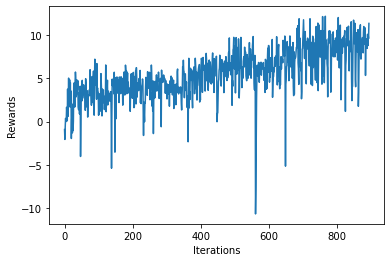

 90%|█████████████████████████████████████████████████████████████████▍       | 89606/100000 [1:01:34<05:11, 33.40it/s]

Updated Weights
Mean Reward = 9.22
48


 90%|█████████████████████████████████████████████████████████████████▍       | 89706/100000 [1:01:37<04:55, 34.86it/s]

Updated Weights
Mean Reward = 8.49
44


 90%|█████████████████████████████████████████████████████████████████▌       | 89806/100000 [1:01:40<05:28, 31.06it/s]

Updated Weights
Mean Reward = 8.71
49


 90%|█████████████████████████████████████████████████████████████████▋       | 89905/100000 [1:01:43<05:30, 30.54it/s]

Updated Weights
Mean Reward = 9.5
51


 90%|█████████████████████████████████████████████████████████████████▋       | 89996/100000 [1:01:46<05:49, 28.66it/s]

Updated Weights
Mean Reward = 10.0
55


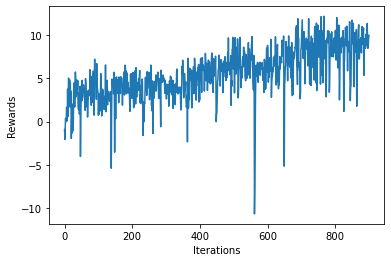

 90%|█████████████████████████████████████████████████████████████████▊       | 90105/100000 [1:01:49<05:47, 28.51it/s]

Updated Weights
Mean Reward = 8.14
46


 90%|█████████████████████████████████████████████████████████████████▊       | 90202/100000 [1:01:53<06:32, 24.94it/s]

Updated Weights
Mean Reward = 2.9
21


 90%|█████████████████████████████████████████████████████████████████▉       | 90305/100000 [1:01:57<06:39, 24.27it/s]

Updated Weights
Mean Reward = 5.59
21


 90%|█████████████████████████████████████████████████████████████████▉       | 90405/100000 [1:02:01<06:19, 25.31it/s]

Updated Weights
Mean Reward = 2.89
21


 90%|██████████████████████████████████████████████████████████████████       | 90500/100000 [1:02:04<05:11, 30.48it/s]

Updated Weights
Mean Reward = 8.71
44


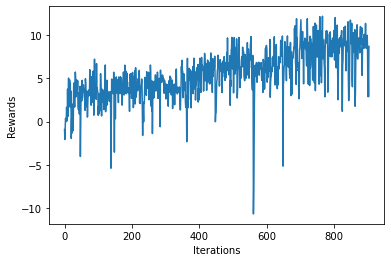

 91%|██████████████████████████████████████████████████████████████████▏      | 90607/100000 [1:02:07<03:56, 39.74it/s]

Updated Weights
Mean Reward = 11.37
62


 91%|██████████████████████████████████████████████████████████████████▏      | 90704/100000 [1:02:10<05:53, 26.31it/s]

Updated Weights
Mean Reward = 9.18
48


 91%|██████████████████████████████████████████████████████████████████▎      | 90806/100000 [1:02:13<05:25, 28.21it/s]

Updated Weights
Mean Reward = 4.91
33


 91%|██████████████████████████████████████████████████████████████████▎      | 90904/100000 [1:02:17<05:32, 27.37it/s]

Updated Weights
Mean Reward = 4.93
30


 91%|██████████████████████████████████████████████████████████████████▍      | 90999/100000 [1:02:20<04:37, 32.39it/s]

Updated Weights
Mean Reward = 8.08
41


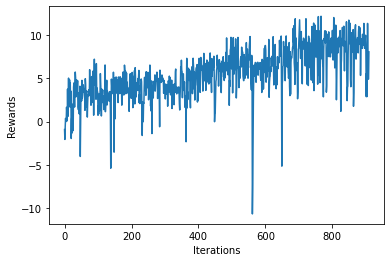

 91%|██████████████████████████████████████████████████████████████████▌      | 91109/100000 [1:02:23<03:57, 37.37it/s]

Updated Weights
Mean Reward = 9.13
47


 91%|██████████████████████████████████████████████████████████████████▌      | 91206/100000 [1:02:26<04:03, 36.09it/s]

Updated Weights
Mean Reward = 9.93
57


 91%|██████████████████████████████████████████████████████████████████▋      | 91306/100000 [1:02:29<04:25, 32.75it/s]

Updated Weights
Mean Reward = 9.86
50


 91%|██████████████████████████████████████████████████████████████████▋      | 91405/100000 [1:02:32<04:46, 30.03it/s]

Updated Weights
Mean Reward = 10.37
53


 91%|██████████████████████████████████████████████████████████████████▊      | 91497/100000 [1:02:35<04:18, 32.91it/s]

Updated Weights
Mean Reward = 6.51
41


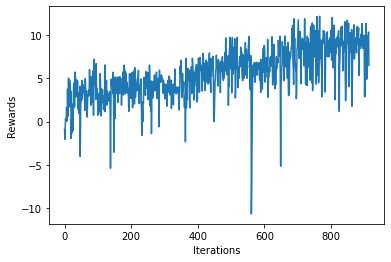

 92%|██████████████████████████████████████████████████████████████████▊      | 91605/100000 [1:02:38<04:13, 33.18it/s]

Updated Weights
Mean Reward = 9.47
54


 92%|██████████████████████████████████████████████████████████████████▉      | 91703/100000 [1:02:41<05:00, 27.62it/s]

Updated Weights
Mean Reward = 7.45
42


 92%|███████████████████████████████████████████████████████████████████      | 91805/100000 [1:02:45<04:27, 30.69it/s]

Updated Weights
Mean Reward = 7.75
40


 92%|███████████████████████████████████████████████████████████████████      | 91907/100000 [1:02:48<04:17, 31.46it/s]

Updated Weights
Mean Reward = 6.93
44


 92%|███████████████████████████████████████████████████████████████████▏     | 91998/100000 [1:02:51<04:03, 32.82it/s]

Updated Weights
Mean Reward = 8.94
49


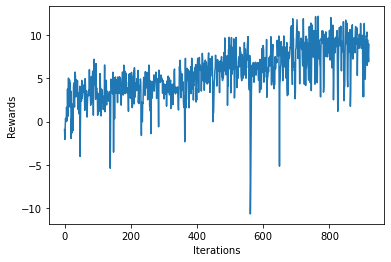

 92%|███████████████████████████████████████████████████████████████████▏     | 92105/100000 [1:02:54<04:23, 29.97it/s]

Updated Weights
Mean Reward = 8.79
52


 92%|███████████████████████████████████████████████████████████████████▎     | 92208/100000 [1:02:57<04:19, 30.02it/s]

Updated Weights
Mean Reward = 4.26
33


 92%|███████████████████████████████████████████████████████████████████▍     | 92304/100000 [1:03:00<03:32, 36.14it/s]

Updated Weights
Mean Reward = 9.2
48


 92%|███████████████████████████████████████████████████████████████████▍     | 92404/100000 [1:03:04<04:15, 29.79it/s]

Updated Weights
Mean Reward = 8.4
42


 92%|███████████████████████████████████████████████████████████████████▌     | 92499/100000 [1:03:07<03:39, 34.19it/s]

Updated Weights
Mean Reward = 9.4
44


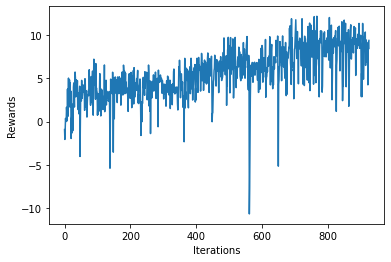

 93%|███████████████████████████████████████████████████████████████████▌     | 92607/100000 [1:03:10<03:53, 31.60it/s]

Updated Weights
Mean Reward = 9.43
45


 93%|███████████████████████████████████████████████████████████████████▋     | 92708/100000 [1:03:13<03:30, 34.59it/s]

Updated Weights
Mean Reward = 10.07
50


 93%|███████████████████████████████████████████████████████████████████▊     | 92809/100000 [1:03:16<03:15, 36.86it/s]

Updated Weights
Mean Reward = 9.36
47


 93%|███████████████████████████████████████████████████████████████████▊     | 92906/100000 [1:03:19<03:30, 33.70it/s]

Updated Weights
Mean Reward = 9.98
53


 93%|███████████████████████████████████████████████████████████████████▉     | 92999/100000 [1:03:22<03:43, 31.29it/s]

Updated Weights
Mean Reward = 10.66
58


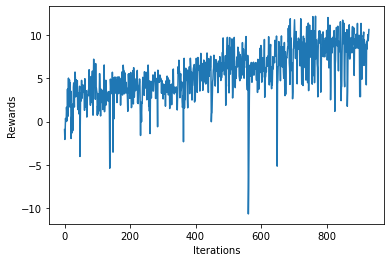

 93%|███████████████████████████████████████████████████████████████████▉     | 93108/100000 [1:03:25<03:08, 36.49it/s]

Updated Weights
Mean Reward = 10.85
61


 93%|████████████████████████████████████████████████████████████████████     | 93206/100000 [1:03:28<04:02, 28.01it/s]

Updated Weights
Mean Reward = 7.03
42


 93%|████████████████████████████████████████████████████████████████████     | 93303/100000 [1:03:31<03:40, 30.34it/s]

Updated Weights
Mean Reward = 8.04
47


 93%|████████████████████████████████████████████████████████████████████▏    | 93403/100000 [1:03:34<03:43, 29.55it/s]

Updated Weights
Mean Reward = 6.54
36


 93%|████████████████████████████████████████████████████████████████████▎    | 93499/100000 [1:03:37<04:31, 23.96it/s]

Updated Weights
Mean Reward = 7.76
41


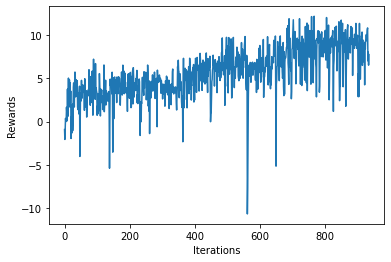

 94%|████████████████████████████████████████████████████████████████████▎    | 93605/100000 [1:03:41<02:54, 36.68it/s]

Updated Weights
Mean Reward = 10.09
53


 94%|████████████████████████████████████████████████████████████████████▍    | 93705/100000 [1:03:43<03:14, 32.30it/s]

Updated Weights
Mean Reward = 9.85
57


 94%|████████████████████████████████████████████████████████████████████▍    | 93805/100000 [1:03:47<03:10, 32.60it/s]

Updated Weights
Mean Reward = 7.3
42


 94%|████████████████████████████████████████████████████████████████████▌    | 93904/100000 [1:03:50<03:17, 30.91it/s]

Updated Weights
Mean Reward = 8.0
40


 94%|████████████████████████████████████████████████████████████████████▌    | 93999/100000 [1:03:53<03:30, 28.45it/s]

Updated Weights
Mean Reward = 7.07
37


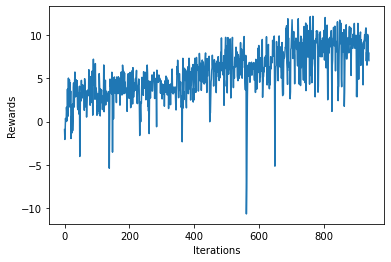

 94%|████████████████████████████████████████████████████████████████████▋    | 94104/100000 [1:03:57<03:14, 30.35it/s]

Updated Weights
Mean Reward = 8.26
43


 94%|████████████████████████████████████████████████████████████████████▊    | 94206/100000 [1:04:00<03:03, 31.60it/s]

Updated Weights
Mean Reward = 8.41
44


 94%|████████████████████████████████████████████████████████████████████▊    | 94305/100000 [1:04:03<02:53, 32.78it/s]

Updated Weights
Mean Reward = 10.24
60


 94%|████████████████████████████████████████████████████████████████████▉    | 94406/100000 [1:04:06<02:35, 36.07it/s]

Updated Weights
Mean Reward = 6.07
43


 94%|████████████████████████████████████████████████████████████████████▉    | 94499/100000 [1:04:09<02:36, 35.26it/s]

Updated Weights
Mean Reward = 9.25
52


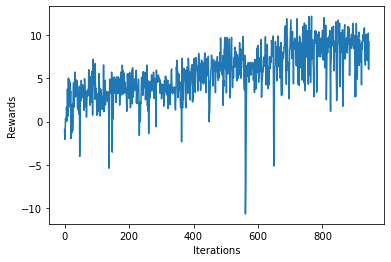

 95%|█████████████████████████████████████████████████████████████████████    | 94604/100000 [1:04:13<03:44, 24.04it/s]

Updated Weights
Mean Reward = -5.88
17


 95%|█████████████████████████████████████████████████████████████████████▏   | 94705/100000 [1:04:17<03:35, 24.54it/s]

Updated Weights
Mean Reward = -1.97
26


 95%|█████████████████████████████████████████████████████████████████████▏   | 94803/100000 [1:04:21<03:43, 23.21it/s]

Updated Weights
Mean Reward = 3.44
31


 95%|█████████████████████████████████████████████████████████████████████▎   | 94902/100000 [1:04:25<04:32, 18.72it/s]

Updated Weights
Mean Reward = 7.54
49


 95%|█████████████████████████████████████████████████████████████████████▎   | 94999/100000 [1:04:29<04:14, 19.67it/s]

Updated Weights
Mean Reward = 8.63
41


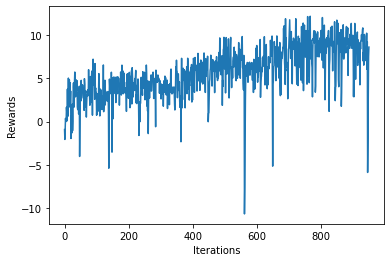

 95%|█████████████████████████████████████████████████████████████████████▍   | 95104/100000 [1:04:36<03:49, 21.38it/s]

Updated Weights
Mean Reward = 8.85
43


 95%|█████████████████████████████████████████████████████████████████████▍   | 95203/100000 [1:04:40<03:46, 21.23it/s]

Updated Weights
Mean Reward = 8.36
44


 95%|█████████████████████████████████████████████████████████████████████▌   | 95305/100000 [1:04:45<03:33, 22.02it/s]

Updated Weights
Mean Reward = 10.07
52


 95%|█████████████████████████████████████████████████████████████████████▋   | 95404/100000 [1:04:49<03:10, 24.19it/s]

Updated Weights
Mean Reward = 9.36
54


 95%|█████████████████████████████████████████████████████████████████████▋   | 95499/100000 [1:04:54<04:13, 17.77it/s]

Updated Weights
Mean Reward = 8.9
45


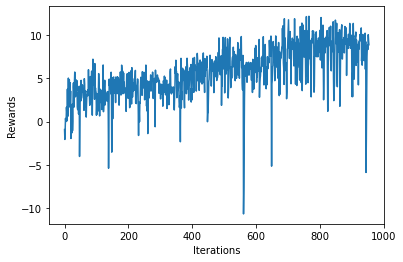

 96%|█████████████████████████████████████████████████████████████████████▊   | 95601/100000 [1:05:01<04:47, 15.30it/s]

Updated Weights
Mean Reward = 10.31
45


 96%|█████████████████████████████████████████████████████████████████████▊   | 95702/100000 [1:05:08<04:51, 14.74it/s]

Updated Weights
Mean Reward = 10.51
56


 96%|█████████████████████████████████████████████████████████████████████▉   | 95804/100000 [1:05:15<03:37, 19.32it/s]

Updated Weights
Mean Reward = 9.92
52


 96%|██████████████████████████████████████████████████████████████████████   | 95903/100000 [1:05:20<02:15, 30.31it/s]

Updated Weights
Mean Reward = 9.82
47


 96%|██████████████████████████████████████████████████████████████████████   | 95999/100000 [1:05:23<01:52, 35.53it/s]

Updated Weights
Mean Reward = 11.18
58


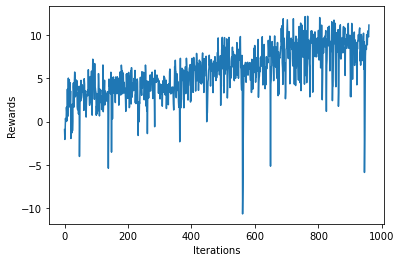

 96%|██████████████████████████████████████████████████████████████████████▏  | 96107/100000 [1:05:26<01:43, 37.60it/s]

Updated Weights
Mean Reward = 10.64
63


 96%|██████████████████████████████████████████████████████████████████████▏  | 96207/100000 [1:05:30<01:58, 32.13it/s]

Updated Weights
Mean Reward = 10.07
61


 96%|██████████████████████████████████████████████████████████████████████▎  | 96306/100000 [1:05:33<02:00, 30.68it/s]

Updated Weights
Mean Reward = 10.1
52


 96%|██████████████████████████████████████████████████████████████████████▎  | 96403/100000 [1:05:37<02:21, 25.48it/s]

Updated Weights
Mean Reward = 10.99
59


 96%|██████████████████████████████████████████████████████████████████████▍  | 96498/100000 [1:05:40<01:41, 34.66it/s]

Updated Weights
Mean Reward = 9.89
55


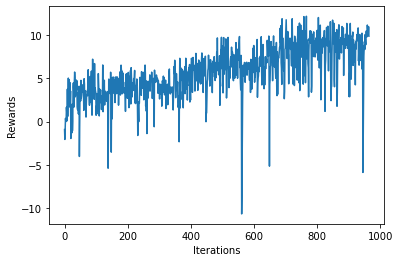

 97%|██████████████████████████████████████████████████████████████████████▌  | 96605/100000 [1:05:45<02:57, 19.17it/s]

Updated Weights
Mean Reward = 5.31
25


 97%|██████████████████████████████████████████████████████████████████████▌  | 96702/100000 [1:05:49<02:20, 23.52it/s]

Updated Weights
Mean Reward = 2.76
31


 97%|██████████████████████████████████████████████████████████████████████▋  | 96804/100000 [1:05:54<02:50, 18.79it/s]

Updated Weights
Mean Reward = 3.41
25


 97%|██████████████████████████████████████████████████████████████████████▋  | 96905/100000 [1:05:59<02:20, 22.05it/s]

Updated Weights
Mean Reward = 5.81
23


 97%|██████████████████████████████████████████████████████████████████████▊  | 96998/100000 [1:06:03<02:18, 21.74it/s]

Updated Weights
Mean Reward = 7.49
27


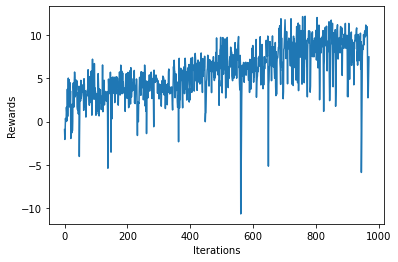

 97%|██████████████████████████████████████████████████████████████████████▉  | 97104/100000 [1:06:08<01:45, 27.40it/s]

Updated Weights
Mean Reward = 9.13
43


 97%|██████████████████████████████████████████████████████████████████████▉  | 97203/100000 [1:06:12<02:03, 22.62it/s]

Updated Weights
Mean Reward = 10.89
58


 97%|███████████████████████████████████████████████████████████████████████  | 97304/100000 [1:06:16<02:06, 21.27it/s]

Updated Weights
Mean Reward = 10.03
43


 97%|███████████████████████████████████████████████████████████████████████  | 97406/100000 [1:06:21<01:34, 27.34it/s]

Updated Weights
Mean Reward = 10.26
44


 97%|███████████████████████████████████████████████████████████████████████▏ | 97499/100000 [1:06:24<01:27, 28.71it/s]

Updated Weights
Mean Reward = 10.09
47


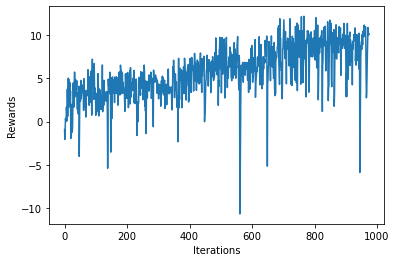

 98%|███████████████████████████████████████████████████████████████████████▎ | 97603/100000 [1:06:28<01:12, 32.99it/s]

Updated Weights
Mean Reward = 11.31
59


 98%|███████████████████████████████████████████████████████████████████████▎ | 97706/100000 [1:06:31<01:09, 33.13it/s]

Updated Weights
Mean Reward = 10.57
56


 98%|███████████████████████████████████████████████████████████████████████▍ | 97802/100000 [1:06:34<01:08, 31.87it/s]

Updated Weights
Mean Reward = 12.4
62


 98%|███████████████████████████████████████████████████████████████████████▍ | 97906/100000 [1:06:37<00:57, 36.63it/s]

Updated Weights
Mean Reward = 11.59
61


 98%|███████████████████████████████████████████████████████████████████████▌ | 97999/100000 [1:06:41<01:13, 27.36it/s]

Updated Weights
Mean Reward = 11.0
61


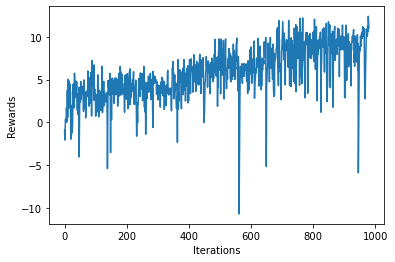

 98%|███████████████████████████████████████████████████████████████████████▌ | 98106/100000 [1:06:45<01:10, 27.00it/s]

Updated Weights
Mean Reward = 8.12
42


 98%|███████████████████████████████████████████████████████████████████████▋ | 98202/100000 [1:06:49<00:58, 30.53it/s]

Updated Weights
Mean Reward = 9.64
47


 98%|███████████████████████████████████████████████████████████████████████▊ | 98302/100000 [1:06:53<01:16, 22.13it/s]

Updated Weights
Mean Reward = 6.85
33


 98%|███████████████████████████████████████████████████████████████████████▊ | 98405/100000 [1:06:57<01:09, 22.95it/s]

Updated Weights
Mean Reward = 6.44
27


 98%|███████████████████████████████████████████████████████████████████████▉ | 98500/100000 [1:07:01<00:56, 26.36it/s]

Updated Weights
Mean Reward = 7.85
32


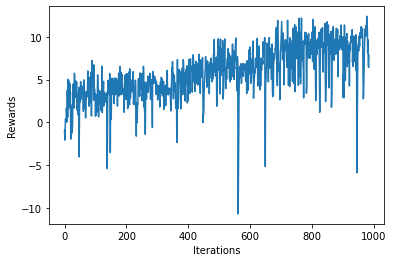

 99%|███████████████████████████████████████████████████████████████████████▉ | 98606/100000 [1:07:06<01:02, 22.34it/s]

Updated Weights
Mean Reward = 7.6
32


 99%|████████████████████████████████████████████████████████████████████████ | 98706/100000 [1:07:09<00:45, 28.71it/s]

Updated Weights
Mean Reward = 11.85
60


 99%|████████████████████████████████████████████████████████████████████████▏| 98802/100000 [1:07:12<00:51, 23.24it/s]

Updated Weights
Mean Reward = 10.36
65


 99%|████████████████████████████████████████████████████████████████████████▏| 98902/100000 [1:07:17<00:54, 20.04it/s]

Updated Weights
Mean Reward = -1.42
17


 99%|████████████████████████████████████████████████████████████████████████▎| 98998/100000 [1:07:21<00:48, 20.53it/s]

Updated Weights
Mean Reward = 0.13
12


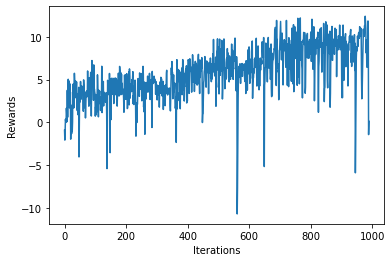

 99%|████████████████████████████████████████████████████████████████████████▎| 99104/100000 [1:07:26<00:41, 21.55it/s]

Updated Weights
Mean Reward = 7.49
36


 99%|████████████████████████████████████████████████████████████████████████▍| 99204/100000 [1:07:30<00:32, 24.13it/s]

Updated Weights
Mean Reward = 10.79
48


 99%|████████████████████████████████████████████████████████████████████████▍| 99307/100000 [1:07:33<00:26, 26.40it/s]

Updated Weights
Mean Reward = 9.24
51


 99%|████████████████████████████████████████████████████████████████████████▌| 99404/100000 [1:07:37<00:27, 21.35it/s]

Updated Weights
Mean Reward = 11.13
54


 99%|████████████████████████████████████████████████████████████████████████▋| 99498/100000 [1:07:42<00:23, 21.60it/s]

Updated Weights
Mean Reward = 10.17
46


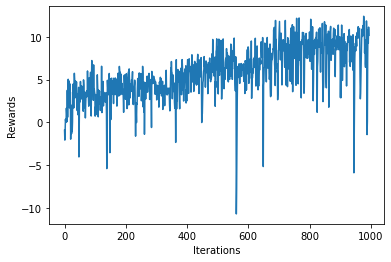

100%|████████████████████████████████████████████████████████████████████████▋| 99601/100000 [1:07:46<00:16, 24.17it/s]

Updated Weights
Mean Reward = 10.19
50


100%|████████████████████████████████████████████████████████████████████████▊| 99702/100000 [1:07:51<00:13, 21.33it/s]

Updated Weights
Mean Reward = 10.32
53


100%|████████████████████████████████████████████████████████████████████████▊| 99805/100000 [1:07:56<00:07, 25.08it/s]

Updated Weights
Mean Reward = 9.62
44


100%|████████████████████████████████████████████████████████████████████████▉| 99904/100000 [1:08:00<00:04, 20.67it/s]

Updated Weights
Mean Reward = 11.09
55


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:08:05<00:00, 24.48it/s]


In [6]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()

    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
        print('Updated Weights')

       
    if epoch>50 and epoch%250==0:
        user_agent.epsilon*=0.9
        user_agent.epsilon = max(user_agent.epsilon, 0.1)

    mean_rewards.append(episode_reward)
    if epoch%100==0 and epoch:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [35]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
state = [start[0], start[1], dest[0], dest[1]]
while not done and step<max_steps:
    print(state)
    state = np.array(state)
    next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1


[0.0, 0.8, 0.2, 0.9]
[0.1, 0.8, 0.2, 0.9]
[0.2, 0.8, 0.2, 0.9]


In [10]:
print(done)

1


In [9]:
user_agent.model.save_weights('user_agent.h5')